<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
download = False
if not os.path.isfile("./t10k-images-idx3-ubyte.gz"):
    download = True

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

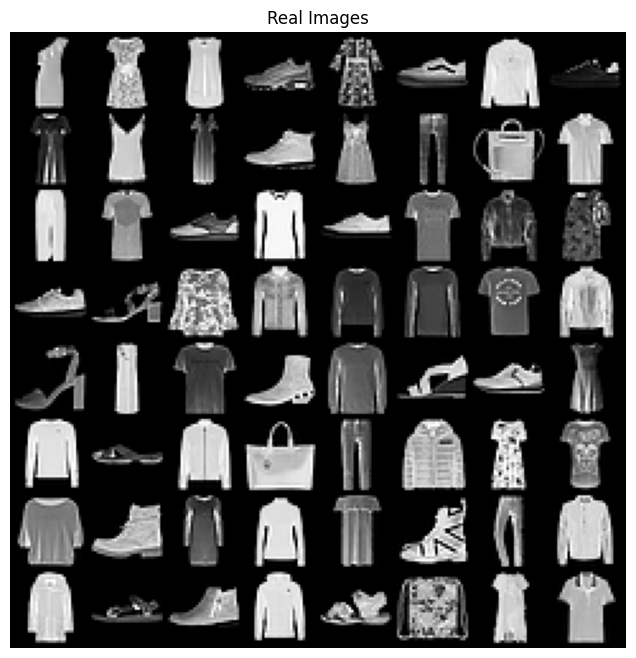

In [4]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

![image.png](attachment:./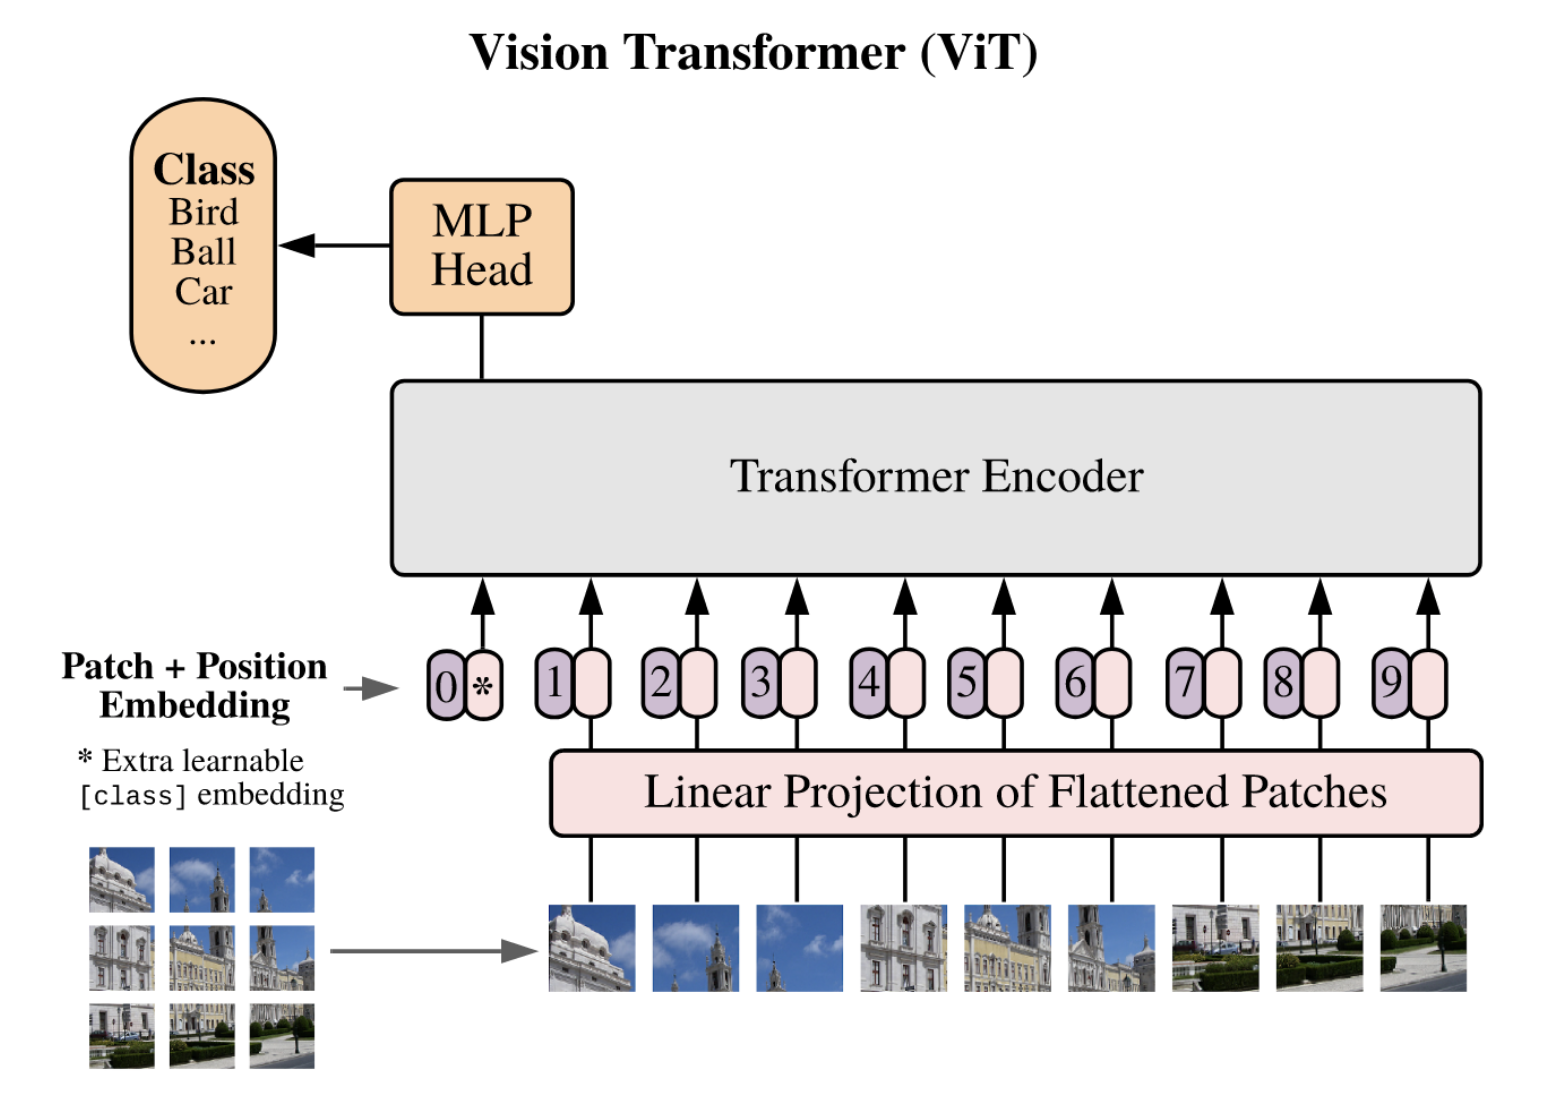)

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """
      x.shape : (Batch, Channels, height, width)
    """
    x = self.projection(x)
    
    B, C, H, W = x.size() # Here C = embedding_dim

    # Reshape from B x C x H x W to B x N x C where N is H*W (the number of 'tokens').
    x = x.view(B, C, -1) # Flatten the H and W dimensions.
      
    # Shape is now B x C x N, we simply need to permute to get B x N x C 
    x = x.permute(0, 2, 1)

    # x.size() -> B, N, C
    return x

In [6]:
PatchEmbed(in_chan=2)(torch.randn(32, 2, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

![image.png](attachment:./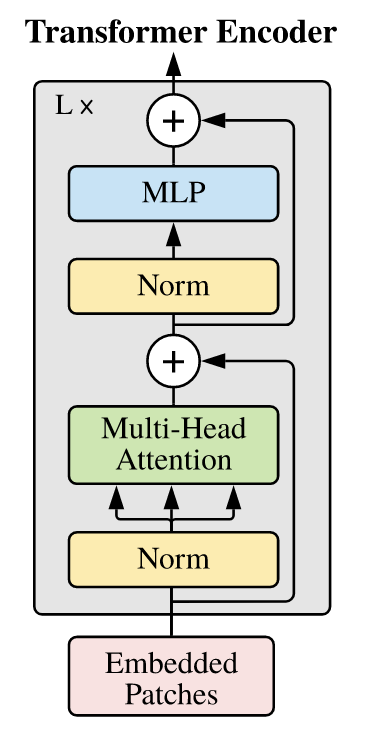)

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:

class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features)) 

  def forward(self, x):
    return self.seq(x)


MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart? What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

**Answer in the reports 😉**

## Q3: Self-attention

In [8]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, final_linear=True):
    super().__init__()
    self.scale = embed_dim**0.5
    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    if final_linear:
      self.final_linear = nn.Linear(embed_dim, embed_dim)
    else:
      self.final_linear = lambda x: x

  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image 
    C : taille d'un embedding 
    """
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the final version using the attention V, and the final projection
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v
    return self.final_linear(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Answer in the reports 😉**

In [9]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
      
    print(q.size())

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    return x

  def transpose_qkv(self, X):
      """Transposition for parallel computation of multiple attention heads."""
      # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). 
      # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      # Shape of output X: (batch_size, num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      X = X.permute(0, 2, 1, 3)
      # Shape of output: (batch_size * num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      return X.reshape(-1, X.shape[2], X.shape[3])
  
  
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [10]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Validate that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by the number of heads.")

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads  # Determine the dimension size of each head
        self.scale = head_dim ** -0.5  # Scale factor for the dot product

        # These are the linear layers used for the multi-head attention
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # This is the final linear layer used after the self-attention
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, number of tokens, and embedding dimension

        # First, we pass through the linear layers
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Reshape Q, K, V for the attention computation
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)

        # Scaled dot-product attention calculation
        ###################### On divise ou multipli par la scale attention ?
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenating the multi-head attention results
        out = out.permute(0, 2, 1, 3).contiguous().view(B, N, C)  # Shape: (B, N, C)

        # Final linear layer
        out = self.projection(out)  # Shape: (B, N, C)

        return out

    
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).size()

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Equations**:

**Answer in the reports 😉**

In [11]:
# normalisation : use layer norm from pytorch, similar to batch normalisation but the mean & std is computed across the channel feature
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    out = self.norm(x)
    out = self.attention(out)
    x = out + x
    out = self.norm(x)
    out = self.mlp(out)
    return out + x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [12]:

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        # Multi-head self-attention mechanism
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward neural network (MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),  # Linear layer
            nn.GELU(),  # Activation function
            nn.Linear(mlp_ratio * embed_dim, embed_dim),  # Linear layer
        )

    def forward(self, x):
        # Apply multi-head attention followed by layer normalization
        attention_output = self.attention(x)
        x = self.norm1(x + attention_output)  # Residual connection

        # Apply feed-forward neural network followed by layer normalization
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)  # Residual connection

        return x

    
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

![](https://www.researchgate.net/publication/348947034/figure/fig2/AS:986572736446471@1612228678819/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the.png)

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

1. Explain what is a Class token and why we use it? 
2. Explain what is the positional embedding (PE) and why it is important?

**Answer in the reports 😉**

### Sinusoidal PE

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(Block(embed_dim, num_heads=num_heads, mlp_ratio=num_heads))
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
            nn.Linear(embed_dim, nb_classes),
            nn.Softmax(dim=-1)
        )

  @staticmethod
  def get_positional_embeddings(sequence_length, d):
    """
    given the number of tokens and the dimensionality of each of them, 
    outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.
    """
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
  
  def forward(self, x):
    batch_size = x.size(0)
    x = self.patch_embed(x) ## image to patches => B, N, C

    ## concatenating class token of shape (1, embedding dim) for every example
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)
    
    ## adding positional embedding
    x += self.pos_embed.repeat(batch_size, 1, 1)

    ## forward in the transformer
    x = self.blocks(x)[:, 0, :] # We take only the CLS token
    
    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output
  


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
  model.eval()
  acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  loss = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)
    loss += F.cross_entropy(yhat, y)
    acc(yhat.argmax(dim=1), y)

  model.train()
  return loss.item() / len(loader), acc.compute().item()

And run! Feel free to try other hyperparameters.

In [15]:
import torchmetrics
from tqdm import tqdm
def main(epochs = 10, embed_dim = 32, patch_size = 7, nb_blocks = 2, num_classes=10, num_heads=4, mlp_ratio=4, model=None, tqdm_batch=False):
  if not model:
    model = ViT(embed_dim, nb_blocks, patch_size, num_heads=num_heads, mlp_ratio=mlp_ratio).cuda()
  if tqdm_batch:
    train_loader_main = tqdm(train_loader)
  else:
    train_loader_main = train_loader
  opt = torch.optim.Adam(model.parameters())
  acc_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  acc_train_list = []
  acc_test_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in (pbar := tqdm(range(epochs))):
    train_loss = 0.
    for x, y in train_loader_main:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()
      acc_train(yhat.argmax(dim=1), y)
      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(acc_train.compute().item())
    acc_train.reset()
    
    # Test eval
    loss_test, acc_test = eval_model(model, test_loader, num_classes)
    acc_test_list.append(acc_test)
    loss_test_list.append(loss_test)
    pbar.set_description(f"acc_train {acc_train_list[-1]:.3f} | acc_test {acc_test:.3f}")
  return acc_train_list, acc_test_list, loss_train_list, loss_test_list
  #   print(f"--- Epoch {epoch} ---")
  #   print(f"Train loss: {train_loss / len(train_loader)}")
  # print(f"Test accuracy: {acc}")
# main()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
def plot_plot_optimizers(plot_optimizers, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in plot_optimizers.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train accuracy / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test accuracy / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train loss / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")

    ax[3].set_title("Test loss / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Loss")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"./clear_run/{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

In [17]:
plot_optimizers_embed_dim = {}
for embed_dim in [16,32,64,128]:
    stats = main(epochs=25, embed_dim=embed_dim)
    plot_optimizers_embed_dim[embed_dim] = stats

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.580 | acc_test 0.732:   0%|                                                                       | 0/25 [00:07<?, ?it/s]

acc_train 0.580 | acc_test 0.732:   4%|██▌                                                            | 1/25 [00:07<02:59,  7.47s/it]

acc_train 0.773 | acc_test 0.781:   4%|██▌                                                            | 1/25 [00:14<02:59,  7.47s/it]

acc_train 0.773 | acc_test 0.781:   8%|█████                                                          | 2/25 [00:14<02:46,  7.23s/it]

acc_train 0.802 | acc_test 0.800:   8%|█████                                                          | 2/25 [00:21<02:46,  7.23s/it]

acc_train 0.802 | acc_test 0.800:  12%|███████▌                                                       | 3/25 [00:21<02:37,  7.16s/it]

acc_train 0.813 | acc_test 0.804:  12%|███████▌                                                       | 3/25 [00:28<02:37,  7.16s/it]

acc_train 0.813 | acc_test 0.804:  16%|██████████                                                     | 4/25 [00:28<02:28,  7.06s/it]

acc_train 0.821 | acc_test 0.799:  16%|██████████                                                     | 4/25 [00:35<02:28,  7.06s/it]

acc_train 0.821 | acc_test 0.799:  20%|████████████▌                                                  | 5/25 [00:35<02:19,  7.00s/it]

acc_train 0.824 | acc_test 0.811:  20%|████████████▌                                                  | 5/25 [00:42<02:19,  7.00s/it]

acc_train 0.824 | acc_test 0.811:  24%|███████████████                                                | 6/25 [00:42<02:12,  6.96s/it]

acc_train 0.829 | acc_test 0.816:  24%|███████████████                                                | 6/25 [00:49<02:12,  6.96s/it]

acc_train 0.829 | acc_test 0.816:  28%|█████████████████▋                                             | 7/25 [00:49<02:04,  6.93s/it]

acc_train 0.833 | acc_test 0.823:  28%|█████████████████▋                                             | 7/25 [00:56<02:04,  6.93s/it]

acc_train 0.833 | acc_test 0.823:  32%|████████████████████▏                                          | 8/25 [00:56<01:57,  6.92s/it]

acc_train 0.837 | acc_test 0.820:  32%|████████████████████▏                                          | 8/25 [01:03<01:57,  6.92s/it]

acc_train 0.837 | acc_test 0.820:  36%|██████████████████████▋                                        | 9/25 [01:03<01:51,  6.95s/it]

acc_train 0.840 | acc_test 0.827:  36%|██████████████████████▋                                        | 9/25 [01:10<01:51,  6.95s/it]

acc_train 0.840 | acc_test 0.827:  40%|████████████████████████▊                                     | 10/25 [01:10<01:44,  6.97s/it]

acc_train 0.844 | acc_test 0.830:  40%|████████████████████████▊                                     | 10/25 [01:16<01:44,  6.97s/it]

acc_train 0.844 | acc_test 0.830:  44%|███████████████████████████▎                                  | 11/25 [01:16<01:36,  6.87s/it]

acc_train 0.845 | acc_test 0.836:  44%|███████████████████████████▎                                  | 11/25 [01:23<01:36,  6.87s/it]

acc_train 0.845 | acc_test 0.836:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:30,  6.99s/it]

acc_train 0.851 | acc_test 0.835:  48%|█████████████████████████████▊                                | 12/25 [01:30<01:30,  6.99s/it]

acc_train 0.851 | acc_test 0.835:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:23,  6.95s/it]

acc_train 0.850 | acc_test 0.840:  52%|████████████████████████████████▏                             | 13/25 [01:37<01:23,  6.95s/it]

acc_train 0.850 | acc_test 0.840:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:15,  6.86s/it]

acc_train 0.853 | acc_test 0.840:  56%|██████████████████████████████████▋                           | 14/25 [01:44<01:15,  6.86s/it]

acc_train 0.853 | acc_test 0.840:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:08,  6.80s/it]

acc_train 0.854 | acc_test 0.836:  60%|█████████████████████████████████████▏                        | 15/25 [01:50<01:08,  6.80s/it]

acc_train 0.854 | acc_test 0.836:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<01:01,  6.80s/it]

acc_train 0.856 | acc_test 0.845:  64%|███████████████████████████████████████▋                      | 16/25 [01:57<01:01,  6.80s/it]

acc_train 0.856 | acc_test 0.845:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:54,  6.76s/it]

acc_train 0.859 | acc_test 0.836:  68%|██████████████████████████████████████████▏                   | 17/25 [02:04<00:54,  6.76s/it]

acc_train 0.859 | acc_test 0.836:  72%|████████████████████████████████████████████▋                 | 18/25 [02:04<00:47,  6.81s/it]

acc_train 0.858 | acc_test 0.850:  72%|████████████████████████████████████████████▋                 | 18/25 [02:11<00:47,  6.81s/it]

acc_train 0.858 | acc_test 0.850:  76%|███████████████████████████████████████████████               | 19/25 [02:11<00:40,  6.80s/it]

acc_train 0.862 | acc_test 0.844:  76%|███████████████████████████████████████████████               | 19/25 [02:18<00:40,  6.80s/it]

acc_train 0.862 | acc_test 0.844:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:18<00:34,  6.85s/it]

acc_train 0.863 | acc_test 0.849:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:25<00:34,  6.85s/it]

acc_train 0.863 | acc_test 0.849:  84%|████████████████████████████████████████████████████          | 21/25 [02:25<00:27,  6.86s/it]

acc_train 0.863 | acc_test 0.844:  84%|████████████████████████████████████████████████████          | 21/25 [02:32<00:27,  6.86s/it]

acc_train 0.863 | acc_test 0.844:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:20,  6.87s/it]

acc_train 0.864 | acc_test 0.847:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:38<00:20,  6.87s/it]

acc_train 0.864 | acc_test 0.847:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.87s/it]

acc_train 0.864 | acc_test 0.849:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:45<00:13,  6.87s/it]

acc_train 0.864 | acc_test 0.849:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.88s/it]

acc_train 0.868 | acc_test 0.851:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:52<00:06,  6.88s/it]

acc_train 0.868 | acc_test 0.851: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:52<00:00,  6.83s/it]

acc_train 0.868 | acc_test 0.851: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:52<00:00,  6.90s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.669 | acc_test 0.767:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.669 | acc_test 0.767:   4%|██▌                                                            | 1/25 [00:06<02:40,  6.67s/it]

acc_train 0.797 | acc_test 0.802:   4%|██▌                                                            | 1/25 [00:13<02:40,  6.67s/it]

acc_train 0.797 | acc_test 0.802:   8%|█████                                                          | 2/25 [00:13<02:33,  6.66s/it]

acc_train 0.814 | acc_test 0.810:   8%|█████                                                          | 2/25 [00:20<02:33,  6.66s/it]

acc_train 0.814 | acc_test 0.810:  12%|███████▌                                                       | 3/25 [00:20<02:27,  6.71s/it]

acc_train 0.822 | acc_test 0.816:  12%|███████▌                                                       | 3/25 [00:26<02:27,  6.71s/it]

acc_train 0.822 | acc_test 0.816:  16%|██████████                                                     | 4/25 [00:26<02:22,  6.77s/it]

acc_train 0.830 | acc_test 0.823:  16%|██████████                                                     | 4/25 [00:33<02:22,  6.77s/it]

acc_train 0.830 | acc_test 0.823:  20%|████████████▌                                                  | 5/25 [00:33<02:15,  6.78s/it]

acc_train 0.836 | acc_test 0.831:  20%|████████████▌                                                  | 5/25 [00:40<02:15,  6.78s/it]

acc_train 0.836 | acc_test 0.831:  24%|███████████████                                                | 6/25 [00:40<02:09,  6.80s/it]

acc_train 0.841 | acc_test 0.828:  24%|███████████████                                                | 6/25 [00:47<02:09,  6.80s/it]

acc_train 0.841 | acc_test 0.828:  28%|█████████████████▋                                             | 7/25 [00:47<02:01,  6.74s/it]

acc_train 0.845 | acc_test 0.834:  28%|█████████████████▋                                             | 7/25 [00:53<02:01,  6.74s/it]

acc_train 0.845 | acc_test 0.834:  32%|████████████████████▏                                          | 8/25 [00:53<01:54,  6.71s/it]

acc_train 0.849 | acc_test 0.842:  32%|████████████████████▏                                          | 8/25 [01:00<01:54,  6.71s/it]

acc_train 0.849 | acc_test 0.842:  36%|██████████████████████▋                                        | 9/25 [01:00<01:47,  6.69s/it]

acc_train 0.852 | acc_test 0.833:  36%|██████████████████████▋                                        | 9/25 [01:07<01:47,  6.69s/it]

acc_train 0.852 | acc_test 0.833:  40%|████████████████████████▊                                     | 10/25 [01:07<01:41,  6.75s/it]

acc_train 0.854 | acc_test 0.839:  40%|████████████████████████▊                                     | 10/25 [01:14<01:41,  6.75s/it]

acc_train 0.854 | acc_test 0.839:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:34,  6.77s/it]

acc_train 0.857 | acc_test 0.847:  44%|███████████████████████████▎                                  | 11/25 [01:21<01:34,  6.77s/it]

acc_train 0.857 | acc_test 0.847:  48%|█████████████████████████████▊                                | 12/25 [01:21<01:28,  6.82s/it]

acc_train 0.859 | acc_test 0.842:  48%|█████████████████████████████▊                                | 12/25 [01:28<01:28,  6.82s/it]

acc_train 0.859 | acc_test 0.842:  52%|████████████████████████████████▏                             | 13/25 [01:28<01:22,  6.85s/it]

acc_train 0.857 | acc_test 0.848:  52%|████████████████████████████████▏                             | 13/25 [01:34<01:22,  6.85s/it]

acc_train 0.857 | acc_test 0.848:  56%|██████████████████████████████████▋                           | 14/25 [01:34<01:15,  6.84s/it]

acc_train 0.864 | acc_test 0.841:  56%|██████████████████████████████████▋                           | 14/25 [01:41<01:15,  6.84s/it]

acc_train 0.864 | acc_test 0.841:  60%|█████████████████████████████████████▏                        | 15/25 [01:41<01:08,  6.83s/it]

acc_train 0.863 | acc_test 0.854:  60%|█████████████████████████████████████▏                        | 15/25 [01:48<01:08,  6.83s/it]

acc_train 0.863 | acc_test 0.854:  64%|███████████████████████████████████████▋                      | 16/25 [01:48<01:01,  6.88s/it]

acc_train 0.866 | acc_test 0.836:  64%|███████████████████████████████████████▋                      | 16/25 [01:55<01:01,  6.88s/it]

acc_train 0.866 | acc_test 0.836:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:54,  6.86s/it]

acc_train 0.868 | acc_test 0.849:  68%|██████████████████████████████████████████▏                   | 17/25 [02:02<00:54,  6.86s/it]

acc_train 0.868 | acc_test 0.849:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:47,  6.79s/it]

acc_train 0.868 | acc_test 0.857:  72%|████████████████████████████████████████████▋                 | 18/25 [02:08<00:47,  6.79s/it]

acc_train 0.868 | acc_test 0.857:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:40,  6.74s/it]

acc_train 0.868 | acc_test 0.846:  76%|███████████████████████████████████████████████               | 19/25 [02:15<00:40,  6.74s/it]

acc_train 0.868 | acc_test 0.846:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:33,  6.71s/it]

acc_train 0.873 | acc_test 0.854:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:22<00:33,  6.71s/it]

acc_train 0.873 | acc_test 0.854:  84%|████████████████████████████████████████████████████          | 21/25 [02:22<00:26,  6.71s/it]

acc_train 0.873 | acc_test 0.850:  84%|████████████████████████████████████████████████████          | 21/25 [02:28<00:26,  6.71s/it]

acc_train 0.873 | acc_test 0.850:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:20,  6.72s/it]

acc_train 0.873 | acc_test 0.850:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:35<00:20,  6.72s/it]

acc_train 0.873 | acc_test 0.850:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:13,  6.69s/it]

acc_train 0.874 | acc_test 0.854:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:42<00:13,  6.69s/it]

acc_train 0.874 | acc_test 0.854:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:42<00:06,  6.72s/it]

acc_train 0.877 | acc_test 0.859:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:49<00:06,  6.72s/it]

acc_train 0.877 | acc_test 0.859: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:49<00:00,  6.77s/it]

acc_train 0.877 | acc_test 0.859: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:49<00:00,  6.77s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.672 | acc_test 0.770:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.672 | acc_test 0.770:   4%|██▌                                                            | 1/25 [00:06<02:41,  6.75s/it]

acc_train 0.803 | acc_test 0.797:   4%|██▌                                                            | 1/25 [00:13<02:41,  6.75s/it]

acc_train 0.803 | acc_test 0.797:   8%|█████                                                          | 2/25 [00:13<02:37,  6.86s/it]

acc_train 0.813 | acc_test 0.807:   8%|█████                                                          | 2/25 [00:20<02:37,  6.86s/it]

acc_train 0.813 | acc_test 0.807:  12%|███████▌                                                       | 3/25 [00:20<02:31,  6.87s/it]

acc_train 0.823 | acc_test 0.827:  12%|███████▌                                                       | 3/25 [00:27<02:31,  6.87s/it]

acc_train 0.823 | acc_test 0.827:  16%|██████████                                                     | 4/25 [00:27<02:22,  6.79s/it]

acc_train 0.829 | acc_test 0.826:  16%|██████████                                                     | 4/25 [00:33<02:22,  6.79s/it]

acc_train 0.829 | acc_test 0.826:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.75s/it]

acc_train 0.836 | acc_test 0.832:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.75s/it]

acc_train 0.836 | acc_test 0.832:  24%|███████████████                                                | 6/25 [00:40<02:08,  6.74s/it]

acc_train 0.837 | acc_test 0.822:  24%|███████████████                                                | 6/25 [00:47<02:08,  6.74s/it]

acc_train 0.837 | acc_test 0.822:  28%|█████████████████▋                                             | 7/25 [00:47<02:02,  6.81s/it]

acc_train 0.842 | acc_test 0.825:  28%|█████████████████▋                                             | 7/25 [00:54<02:02,  6.81s/it]

acc_train 0.842 | acc_test 0.825:  32%|████████████████████▏                                          | 8/25 [00:54<01:55,  6.78s/it]

acc_train 0.845 | acc_test 0.817:  32%|████████████████████▏                                          | 8/25 [01:01<01:55,  6.78s/it]

acc_train 0.845 | acc_test 0.817:  36%|██████████████████████▋                                        | 9/25 [01:01<01:49,  6.83s/it]

acc_train 0.848 | acc_test 0.841:  36%|██████████████████████▋                                        | 9/25 [01:08<01:49,  6.83s/it]

acc_train 0.848 | acc_test 0.841:  40%|████████████████████████▊                                     | 10/25 [01:08<01:42,  6.82s/it]

acc_train 0.851 | acc_test 0.841:  40%|████████████████████████▊                                     | 10/25 [01:14<01:42,  6.82s/it]

acc_train 0.851 | acc_test 0.841:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:34,  6.77s/it]

acc_train 0.853 | acc_test 0.840:  44%|███████████████████████████▎                                  | 11/25 [01:21<01:34,  6.77s/it]

acc_train 0.853 | acc_test 0.840:  48%|█████████████████████████████▊                                | 12/25 [01:21<01:30,  6.93s/it]

acc_train 0.854 | acc_test 0.842:  48%|█████████████████████████████▊                                | 12/25 [01:28<01:30,  6.93s/it]

acc_train 0.854 | acc_test 0.842:  52%|████████████████████████████████▏                             | 13/25 [01:28<01:22,  6.85s/it]

acc_train 0.856 | acc_test 0.844:  52%|████████████████████████████████▏                             | 13/25 [01:35<01:22,  6.85s/it]

acc_train 0.856 | acc_test 0.844:  56%|██████████████████████████████████▋                           | 14/25 [01:35<01:14,  6.79s/it]

acc_train 0.858 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [01:41<01:14,  6.79s/it]

acc_train 0.858 | acc_test 0.845:  60%|█████████████████████████████████████▏                        | 15/25 [01:41<01:07,  6.75s/it]

acc_train 0.856 | acc_test 0.834:  60%|█████████████████████████████████████▏                        | 15/25 [01:48<01:07,  6.75s/it]

acc_train 0.856 | acc_test 0.834:  64%|███████████████████████████████████████▋                      | 16/25 [01:48<01:00,  6.73s/it]

acc_train 0.861 | acc_test 0.843:  64%|███████████████████████████████████████▋                      | 16/25 [01:55<01:00,  6.73s/it]

acc_train 0.861 | acc_test 0.843:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:53,  6.71s/it]

acc_train 0.862 | acc_test 0.848:  68%|██████████████████████████████████████████▏                   | 17/25 [02:02<00:53,  6.71s/it]

acc_train 0.862 | acc_test 0.848:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:47,  6.79s/it]

acc_train 0.863 | acc_test 0.846:  72%|████████████████████████████████████████████▋                 | 18/25 [02:09<00:47,  6.79s/it]

acc_train 0.863 | acc_test 0.846:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:40,  6.81s/it]

acc_train 0.860 | acc_test 0.845:  76%|███████████████████████████████████████████████               | 19/25 [02:16<00:40,  6.81s/it]

acc_train 0.860 | acc_test 0.845:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:16<00:34,  6.94s/it]

acc_train 0.863 | acc_test 0.854:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:23<00:34,  6.94s/it]

acc_train 0.863 | acc_test 0.854:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:27,  6.86s/it]

acc_train 0.864 | acc_test 0.840:  84%|████████████████████████████████████████████████████          | 21/25 [02:30<00:27,  6.86s/it]

acc_train 0.864 | acc_test 0.840:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:20,  6.92s/it]

acc_train 0.866 | acc_test 0.847:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:36<00:20,  6.92s/it]

acc_train 0.866 | acc_test 0.847:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:13,  6.84s/it]

acc_train 0.866 | acc_test 0.858:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:43<00:13,  6.84s/it]

acc_train 0.866 | acc_test 0.858:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:43<00:06,  6.79s/it]

acc_train 0.867 | acc_test 0.848:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:50<00:06,  6.79s/it]

acc_train 0.867 | acc_test 0.848: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.91s/it]

acc_train 0.867 | acc_test 0.848: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.83s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.697 | acc_test 0.737:   0%|                                                                       | 0/25 [00:07<?, ?it/s]

acc_train 0.697 | acc_test 0.737:   4%|██▌                                                            | 1/25 [00:07<02:51,  7.16s/it]

acc_train 0.772 | acc_test 0.779:   4%|██▌                                                            | 1/25 [00:14<02:51,  7.16s/it]

acc_train 0.772 | acc_test 0.779:   8%|█████                                                          | 2/25 [00:14<02:45,  7.17s/it]

acc_train 0.784 | acc_test 0.773:   8%|█████                                                          | 2/25 [00:21<02:45,  7.17s/it]

acc_train 0.784 | acc_test 0.773:  12%|███████▌                                                       | 3/25 [00:21<02:34,  7.02s/it]

acc_train 0.787 | acc_test 0.784:  12%|███████▌                                                       | 3/25 [00:27<02:34,  7.02s/it]

acc_train 0.787 | acc_test 0.784:  16%|██████████                                                     | 4/25 [00:27<02:24,  6.89s/it]

acc_train 0.795 | acc_test 0.796:  16%|██████████                                                     | 4/25 [00:34<02:24,  6.89s/it]

acc_train 0.795 | acc_test 0.796:  20%|████████████▌                                                  | 5/25 [00:34<02:18,  6.91s/it]

acc_train 0.795 | acc_test 0.789:  20%|████████████▌                                                  | 5/25 [00:41<02:18,  6.91s/it]

acc_train 0.795 | acc_test 0.789:  24%|███████████████                                                | 6/25 [00:41<02:12,  6.96s/it]

acc_train 0.785 | acc_test 0.796:  24%|███████████████                                                | 6/25 [00:48<02:12,  6.96s/it]

acc_train 0.785 | acc_test 0.796:  28%|█████████████████▋                                             | 7/25 [00:48<02:05,  6.98s/it]

acc_train 0.790 | acc_test 0.789:  28%|█████████████████▋                                             | 7/25 [00:55<02:05,  6.98s/it]

acc_train 0.790 | acc_test 0.789:  32%|████████████████████▏                                          | 8/25 [00:55<01:58,  6.96s/it]

acc_train 0.800 | acc_test 0.790:  32%|████████████████████▏                                          | 8/25 [01:02<01:58,  6.96s/it]

acc_train 0.800 | acc_test 0.790:  36%|██████████████████████▋                                        | 9/25 [01:02<01:51,  6.95s/it]

acc_train 0.784 | acc_test 0.672:  36%|██████████████████████▋                                        | 9/25 [01:09<01:51,  6.95s/it]

acc_train 0.784 | acc_test 0.672:  40%|████████████████████████▊                                     | 10/25 [01:09<01:43,  6.92s/it]

acc_train 0.786 | acc_test 0.736:  40%|████████████████████████▊                                     | 10/25 [01:16<01:43,  6.92s/it]

acc_train 0.786 | acc_test 0.736:  44%|███████████████████████████▎                                  | 11/25 [01:16<01:36,  6.89s/it]

acc_train 0.784 | acc_test 0.783:  44%|███████████████████████████▎                                  | 11/25 [01:23<01:36,  6.89s/it]

acc_train 0.784 | acc_test 0.783:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:29,  6.86s/it]

acc_train 0.797 | acc_test 0.796:  48%|█████████████████████████████▊                                | 12/25 [01:30<01:29,  6.86s/it]

acc_train 0.797 | acc_test 0.796:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:23,  6.92s/it]

acc_train 0.794 | acc_test 0.800:  52%|████████████████████████████████▏                             | 13/25 [01:37<01:23,  6.92s/it]

acc_train 0.794 | acc_test 0.800:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:16,  6.91s/it]

acc_train 0.775 | acc_test 0.754:  56%|██████████████████████████████████▋                           | 14/25 [01:43<01:16,  6.91s/it]

acc_train 0.775 | acc_test 0.754:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:08,  6.89s/it]

acc_train 0.795 | acc_test 0.786:  60%|█████████████████████████████████████▏                        | 15/25 [01:50<01:08,  6.89s/it]

acc_train 0.795 | acc_test 0.786:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<01:01,  6.83s/it]

acc_train 0.798 | acc_test 0.786:  64%|███████████████████████████████████████▋                      | 16/25 [01:57<01:01,  6.83s/it]

acc_train 0.798 | acc_test 0.786:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:54,  6.83s/it]

acc_train 0.799 | acc_test 0.789:  68%|██████████████████████████████████████████▏                   | 17/25 [02:04<00:54,  6.83s/it]

acc_train 0.799 | acc_test 0.789:  72%|████████████████████████████████████████████▋                 | 18/25 [02:04<00:47,  6.79s/it]

acc_train 0.784 | acc_test 0.782:  72%|████████████████████████████████████████████▋                 | 18/25 [02:10<00:47,  6.79s/it]

acc_train 0.784 | acc_test 0.782:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:40,  6.76s/it]

acc_train 0.796 | acc_test 0.800:  76%|███████████████████████████████████████████████               | 19/25 [02:17<00:40,  6.76s/it]

acc_train 0.796 | acc_test 0.800:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:17<00:34,  6.83s/it]

acc_train 0.806 | acc_test 0.806:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:24<00:34,  6.83s/it]

acc_train 0.806 | acc_test 0.806:  84%|████████████████████████████████████████████████████          | 21/25 [02:24<00:27,  6.85s/it]

acc_train 0.808 | acc_test 0.800:  84%|████████████████████████████████████████████████████          | 21/25 [02:32<00:27,  6.85s/it]

acc_train 0.808 | acc_test 0.800:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:20,  7.00s/it]

acc_train 0.789 | acc_test 0.760:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:38<00:20,  7.00s/it]

acc_train 0.789 | acc_test 0.760:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.90s/it]

acc_train 0.794 | acc_test 0.793:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:45<00:13,  6.90s/it]

acc_train 0.794 | acc_test 0.793:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.88s/it]

acc_train 0.809 | acc_test 0.801:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:52<00:06,  6.88s/it]

acc_train 0.809 | acc_test 0.801: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:52<00:00,  6.82s/it]

acc_train 0.809 | acc_test 0.801: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:52<00:00,  6.89s/it]

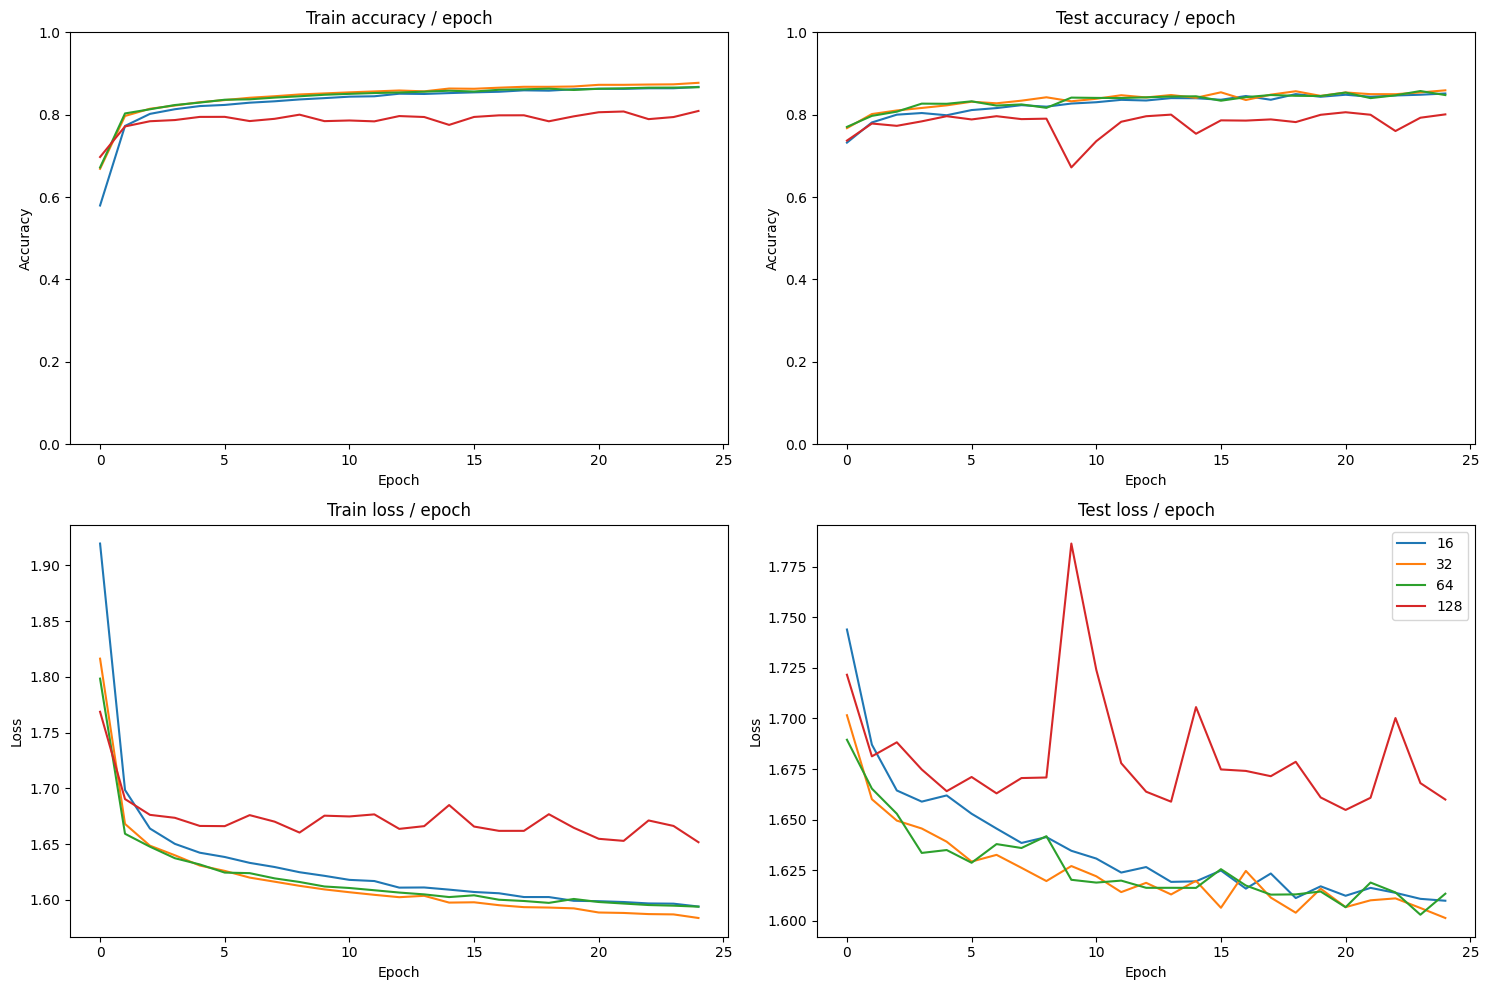

In [18]:
plot_plot_optimizers(plot_optimizers_embed_dim, 'embed_dim_influence_25')

In [19]:
plot_optimizers_patch_size = {}
for patch_size in [2,4,7,14, 28]:
    stats = main(epochs=25, patch_size=patch_size)
    plot_optimizers_patch_size[patch_size] = stats

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.576 | acc_test 0.724:   0%|                                                                       | 0/25 [00:09<?, ?it/s]

acc_train 0.576 | acc_test 0.724:   4%|██▌                                                            | 1/25 [00:09<03:50,  9.61s/it]

acc_train 0.764 | acc_test 0.767:   4%|██▌                                                            | 1/25 [00:19<03:50,  9.61s/it]

acc_train 0.764 | acc_test 0.767:   8%|█████                                                          | 2/25 [00:19<03:38,  9.51s/it]

acc_train 0.787 | acc_test 0.785:   8%|█████                                                          | 2/25 [00:28<03:38,  9.51s/it]

acc_train 0.787 | acc_test 0.785:  12%|███████▌                                                       | 3/25 [00:28<03:30,  9.57s/it]

acc_train 0.800 | acc_test 0.796:  12%|███████▌                                                       | 3/25 [00:38<03:30,  9.57s/it]

acc_train 0.800 | acc_test 0.796:  16%|██████████                                                     | 4/25 [00:38<03:21,  9.61s/it]

acc_train 0.809 | acc_test 0.801:  16%|██████████                                                     | 4/25 [00:48<03:21,  9.61s/it]

acc_train 0.809 | acc_test 0.801:  20%|████████████▌                                                  | 5/25 [00:48<03:13,  9.65s/it]

acc_train 0.811 | acc_test 0.808:  20%|████████████▌                                                  | 5/25 [00:57<03:13,  9.65s/it]

acc_train 0.811 | acc_test 0.808:  24%|███████████████                                                | 6/25 [00:57<03:02,  9.62s/it]

acc_train 0.816 | acc_test 0.818:  24%|███████████████                                                | 6/25 [01:07<03:02,  9.62s/it]

acc_train 0.816 | acc_test 0.818:  28%|█████████████████▋                                             | 7/25 [01:07<02:53,  9.64s/it]

acc_train 0.820 | acc_test 0.806:  28%|█████████████████▋                                             | 7/25 [01:16<02:53,  9.64s/it]

acc_train 0.820 | acc_test 0.806:  32%|████████████████████▏                                          | 8/25 [01:16<02:43,  9.61s/it]

acc_train 0.820 | acc_test 0.814:  32%|████████████████████▏                                          | 8/25 [01:26<02:43,  9.61s/it]

acc_train 0.820 | acc_test 0.814:  36%|██████████████████████▋                                        | 9/25 [01:26<02:33,  9.58s/it]

acc_train 0.824 | acc_test 0.819:  36%|██████████████████████▋                                        | 9/25 [01:36<02:33,  9.58s/it]

acc_train 0.824 | acc_test 0.819:  40%|████████████████████████▊                                     | 10/25 [01:36<02:23,  9.59s/it]

acc_train 0.824 | acc_test 0.820:  40%|████████████████████████▊                                     | 10/25 [01:45<02:23,  9.59s/it]

acc_train 0.824 | acc_test 0.820:  44%|███████████████████████████▎                                  | 11/25 [01:45<02:13,  9.54s/it]

acc_train 0.828 | acc_test 0.812:  44%|███████████████████████████▎                                  | 11/25 [01:54<02:13,  9.54s/it]

acc_train 0.828 | acc_test 0.812:  48%|█████████████████████████████▊                                | 12/25 [01:54<02:03,  9.53s/it]

acc_train 0.829 | acc_test 0.823:  48%|█████████████████████████████▊                                | 12/25 [02:04<02:03,  9.53s/it]

acc_train 0.829 | acc_test 0.823:  52%|████████████████████████████████▏                             | 13/25 [02:04<01:54,  9.50s/it]

acc_train 0.830 | acc_test 0.824:  52%|████████████████████████████████▏                             | 13/25 [02:13<01:54,  9.50s/it]

acc_train 0.830 | acc_test 0.824:  56%|██████████████████████████████████▋                           | 14/25 [02:13<01:44,  9.48s/it]

acc_train 0.832 | acc_test 0.827:  56%|██████████████████████████████████▋                           | 14/25 [02:23<01:44,  9.48s/it]

acc_train 0.832 | acc_test 0.827:  60%|█████████████████████████████████████▏                        | 15/25 [02:23<01:34,  9.46s/it]

acc_train 0.834 | acc_test 0.828:  60%|█████████████████████████████████████▏                        | 15/25 [02:32<01:34,  9.46s/it]

acc_train 0.834 | acc_test 0.828:  64%|███████████████████████████████████████▋                      | 16/25 [02:32<01:25,  9.45s/it]

acc_train 0.836 | acc_test 0.827:  64%|███████████████████████████████████████▋                      | 16/25 [02:42<01:25,  9.45s/it]

acc_train 0.836 | acc_test 0.827:  68%|██████████████████████████████████████████▏                   | 17/25 [02:42<01:15,  9.43s/it]

acc_train 0.835 | acc_test 0.830:  68%|██████████████████████████████████████████▏                   | 17/25 [02:51<01:15,  9.43s/it]

acc_train 0.835 | acc_test 0.830:  72%|████████████████████████████████████████████▋                 | 18/25 [02:51<01:05,  9.42s/it]

acc_train 0.836 | acc_test 0.818:  72%|████████████████████████████████████████████▋                 | 18/25 [03:00<01:05,  9.42s/it]

acc_train 0.836 | acc_test 0.818:  76%|███████████████████████████████████████████████               | 19/25 [03:00<00:56,  9.42s/it]

acc_train 0.839 | acc_test 0.828:  76%|███████████████████████████████████████████████               | 19/25 [03:10<00:56,  9.42s/it]

acc_train 0.839 | acc_test 0.828:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:10<00:47,  9.42s/it]

acc_train 0.839 | acc_test 0.831:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:19<00:47,  9.42s/it]

acc_train 0.839 | acc_test 0.831:  84%|████████████████████████████████████████████████████          | 21/25 [03:19<00:37,  9.47s/it]

acc_train 0.838 | acc_test 0.825:  84%|████████████████████████████████████████████████████          | 21/25 [03:29<00:37,  9.47s/it]

acc_train 0.838 | acc_test 0.825:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:29<00:28,  9.51s/it]

acc_train 0.840 | acc_test 0.822:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:38<00:28,  9.51s/it]

acc_train 0.840 | acc_test 0.822:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:38<00:19,  9.51s/it]

acc_train 0.842 | acc_test 0.841:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:48<00:19,  9.51s/it]

acc_train 0.842 | acc_test 0.841:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:48<00:09,  9.51s/it]

acc_train 0.844 | acc_test 0.837:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:58<00:09,  9.51s/it]

acc_train 0.844 | acc_test 0.837: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:58<00:00,  9.57s/it]

acc_train 0.844 | acc_test 0.837: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:58<00:00,  9.53s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.585 | acc_test 0.738:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.585 | acc_test 0.738:   4%|██▌                                                            | 1/25 [00:06<02:39,  6.63s/it]

acc_train 0.765 | acc_test 0.775:   4%|██▌                                                            | 1/25 [00:13<02:39,  6.63s/it]

acc_train 0.765 | acc_test 0.775:   8%|█████                                                          | 2/25 [00:13<02:34,  6.74s/it]

acc_train 0.791 | acc_test 0.795:   8%|█████                                                          | 2/25 [00:20<02:34,  6.74s/it]

acc_train 0.791 | acc_test 0.795:  12%|███████▌                                                       | 3/25 [00:20<02:33,  7.00s/it]

acc_train 0.807 | acc_test 0.794:  12%|███████▌                                                       | 3/25 [00:27<02:33,  7.00s/it]

acc_train 0.807 | acc_test 0.794:  16%|██████████                                                     | 4/25 [00:27<02:23,  6.85s/it]

acc_train 0.812 | acc_test 0.799:  16%|██████████                                                     | 4/25 [00:33<02:23,  6.85s/it]

acc_train 0.812 | acc_test 0.799:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.72s/it]

acc_train 0.815 | acc_test 0.809:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.72s/it]

acc_train 0.815 | acc_test 0.809:  24%|███████████████                                                | 6/25 [00:40<02:06,  6.65s/it]

acc_train 0.820 | acc_test 0.804:  24%|███████████████                                                | 6/25 [00:47<02:06,  6.65s/it]

acc_train 0.820 | acc_test 0.804:  28%|█████████████████▋                                             | 7/25 [00:47<02:00,  6.68s/it]

acc_train 0.824 | acc_test 0.811:  28%|█████████████████▋                                             | 7/25 [00:54<02:00,  6.68s/it]

acc_train 0.824 | acc_test 0.811:  32%|████████████████████▏                                          | 8/25 [00:54<01:56,  6.83s/it]

acc_train 0.826 | acc_test 0.817:  32%|████████████████████▏                                          | 8/25 [01:00<01:56,  6.83s/it]

acc_train 0.826 | acc_test 0.817:  36%|██████████████████████▋                                        | 9/25 [01:00<01:47,  6.74s/it]

acc_train 0.829 | acc_test 0.815:  36%|██████████████████████▋                                        | 9/25 [01:07<01:47,  6.74s/it]

acc_train 0.829 | acc_test 0.815:  40%|████████████████████████▊                                     | 10/25 [01:07<01:40,  6.69s/it]

acc_train 0.832 | acc_test 0.819:  40%|████████████████████████▊                                     | 10/25 [01:14<01:40,  6.69s/it]

acc_train 0.832 | acc_test 0.819:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:33,  6.69s/it]

acc_train 0.837 | acc_test 0.822:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:33,  6.69s/it]

acc_train 0.837 | acc_test 0.822:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:27,  6.74s/it]

acc_train 0.837 | acc_test 0.826:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:27,  6.74s/it]

acc_train 0.837 | acc_test 0.826:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:20,  6.68s/it]

acc_train 0.840 | acc_test 0.830:  52%|████████████████████████████████▏                             | 13/25 [01:34<01:20,  6.68s/it]

acc_train 0.840 | acc_test 0.830:  56%|██████████████████████████████████▋                           | 14/25 [01:34<01:12,  6.63s/it]

acc_train 0.844 | acc_test 0.828:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:12,  6.63s/it]

acc_train 0.844 | acc_test 0.828:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:06,  6.61s/it]

acc_train 0.846 | acc_test 0.833:  60%|█████████████████████████████████████▏                        | 15/25 [01:47<01:06,  6.61s/it]

acc_train 0.846 | acc_test 0.833:  64%|███████████████████████████████████████▋                      | 16/25 [01:47<01:00,  6.68s/it]

acc_train 0.847 | acc_test 0.820:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.68s/it]

acc_train 0.847 | acc_test 0.820:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:53,  6.73s/it]

acc_train 0.850 | acc_test 0.820:  68%|██████████████████████████████████████████▏                   | 17/25 [02:00<00:53,  6.73s/it]

acc_train 0.850 | acc_test 0.820:  72%|████████████████████████████████████████████▋                 | 18/25 [02:00<00:46,  6.66s/it]

acc_train 0.853 | acc_test 0.832:  72%|████████████████████████████████████████████▋                 | 18/25 [02:07<00:46,  6.66s/it]

acc_train 0.853 | acc_test 0.832:  76%|███████████████████████████████████████████████               | 19/25 [02:07<00:39,  6.62s/it]

acc_train 0.854 | acc_test 0.838:  76%|███████████████████████████████████████████████               | 19/25 [02:14<00:39,  6.62s/it]

acc_train 0.854 | acc_test 0.838:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:14<00:33,  6.74s/it]

acc_train 0.854 | acc_test 0.841:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:20<00:33,  6.74s/it]

acc_train 0.854 | acc_test 0.841:  84%|████████████████████████████████████████████████████          | 21/25 [02:20<00:26,  6.71s/it]

acc_train 0.856 | acc_test 0.839:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:26,  6.71s/it]

acc_train 0.856 | acc_test 0.839:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:20,  6.68s/it]

acc_train 0.855 | acc_test 0.833:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:34<00:20,  6.68s/it]

acc_train 0.855 | acc_test 0.833:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:13,  6.63s/it]

acc_train 0.859 | acc_test 0.845:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:40<00:13,  6.63s/it]

acc_train 0.859 | acc_test 0.845:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.67s/it]

acc_train 0.860 | acc_test 0.846:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:47<00:06,  6.67s/it]

acc_train 0.860 | acc_test 0.846: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.67s/it]

acc_train 0.860 | acc_test 0.846: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.70s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.626 | acc_test 0.740:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.626 | acc_test 0.740:   4%|██▌                                                            | 1/25 [00:06<02:43,  6.80s/it]

acc_train 0.769 | acc_test 0.767:   4%|██▌                                                            | 1/25 [00:13<02:43,  6.80s/it]

acc_train 0.769 | acc_test 0.767:   8%|█████                                                          | 2/25 [00:13<02:31,  6.60s/it]

acc_train 0.793 | acc_test 0.800:   8%|█████                                                          | 2/25 [00:20<02:31,  6.60s/it]

acc_train 0.793 | acc_test 0.800:  12%|███████▌                                                       | 3/25 [00:20<02:27,  6.70s/it]

acc_train 0.805 | acc_test 0.799:  12%|███████▌                                                       | 3/25 [00:26<02:27,  6.70s/it]

acc_train 0.805 | acc_test 0.799:  16%|██████████                                                     | 4/25 [00:26<02:20,  6.67s/it]

acc_train 0.812 | acc_test 0.804:  16%|██████████                                                     | 4/25 [00:33<02:20,  6.67s/it]

acc_train 0.812 | acc_test 0.804:  20%|████████████▌                                                  | 5/25 [00:33<02:15,  6.76s/it]

acc_train 0.818 | acc_test 0.803:  20%|████████████▌                                                  | 5/25 [00:40<02:15,  6.76s/it]

acc_train 0.818 | acc_test 0.803:  24%|███████████████                                                | 6/25 [00:40<02:07,  6.70s/it]

acc_train 0.822 | acc_test 0.813:  24%|███████████████                                                | 6/25 [00:46<02:07,  6.70s/it]

acc_train 0.822 | acc_test 0.813:  28%|█████████████████▋                                             | 7/25 [00:46<02:00,  6.68s/it]

acc_train 0.826 | acc_test 0.809:  28%|█████████████████▋                                             | 7/25 [00:53<02:00,  6.68s/it]

acc_train 0.826 | acc_test 0.809:  32%|████████████████████▏                                          | 8/25 [00:53<01:53,  6.65s/it]

acc_train 0.830 | acc_test 0.802:  32%|████████████████████▏                                          | 8/25 [01:00<01:53,  6.65s/it]

acc_train 0.830 | acc_test 0.802:  36%|██████████████████████▋                                        | 9/25 [01:00<01:47,  6.73s/it]

acc_train 0.834 | acc_test 0.817:  36%|██████████████████████▋                                        | 9/25 [01:06<01:47,  6.73s/it]

acc_train 0.834 | acc_test 0.817:  40%|████████████████████████▊                                     | 10/25 [01:06<01:40,  6.69s/it]

acc_train 0.835 | acc_test 0.821:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.69s/it]

acc_train 0.835 | acc_test 0.821:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:33,  6.66s/it]

acc_train 0.837 | acc_test 0.829:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:33,  6.66s/it]

acc_train 0.837 | acc_test 0.829:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:26,  6.66s/it]

acc_train 0.842 | acc_test 0.827:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:26,  6.66s/it]

acc_train 0.842 | acc_test 0.827:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:19,  6.61s/it]

acc_train 0.844 | acc_test 0.818:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:19,  6.61s/it]

acc_train 0.844 | acc_test 0.818:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:12,  6.58s/it]

acc_train 0.845 | acc_test 0.833:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:12,  6.58s/it]

acc_train 0.845 | acc_test 0.833:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:05,  6.55s/it]

acc_train 0.848 | acc_test 0.837:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:05,  6.55s/it]

acc_train 0.848 | acc_test 0.837:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:58,  6.53s/it]

acc_train 0.852 | acc_test 0.818:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:58,  6.53s/it]

acc_train 0.852 | acc_test 0.818:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:52,  6.51s/it]

acc_train 0.850 | acc_test 0.835:  68%|██████████████████████████████████████████▏                   | 17/25 [01:59<00:52,  6.51s/it]

acc_train 0.850 | acc_test 0.835:  72%|████████████████████████████████████████████▋                 | 18/25 [01:59<00:45,  6.56s/it]

acc_train 0.856 | acc_test 0.838:  72%|████████████████████████████████████████████▋                 | 18/25 [02:05<00:45,  6.56s/it]

acc_train 0.856 | acc_test 0.838:  76%|███████████████████████████████████████████████               | 19/25 [02:05<00:39,  6.57s/it]

acc_train 0.856 | acc_test 0.831:  76%|███████████████████████████████████████████████               | 19/25 [02:12<00:39,  6.57s/it]

acc_train 0.856 | acc_test 0.831:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:12<00:32,  6.59s/it]

acc_train 0.857 | acc_test 0.841:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:19<00:32,  6.59s/it]

acc_train 0.857 | acc_test 0.841:  84%|████████████████████████████████████████████████████          | 21/25 [02:19<00:26,  6.59s/it]

acc_train 0.859 | acc_test 0.840:  84%|████████████████████████████████████████████████████          | 21/25 [02:25<00:26,  6.59s/it]

acc_train 0.859 | acc_test 0.840:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:25<00:19,  6.63s/it]

acc_train 0.863 | acc_test 0.844:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:19,  6.63s/it]

acc_train 0.863 | acc_test 0.844:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:32<00:13,  6.59s/it]

acc_train 0.864 | acc_test 0.847:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.59s/it]

acc_train 0.864 | acc_test 0.847:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:38<00:06,  6.56s/it]

acc_train 0.864 | acc_test 0.842:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.56s/it]

acc_train 0.864 | acc_test 0.842: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.57s/it]

acc_train 0.864 | acc_test 0.842: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.62s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.690 | acc_test 0.782:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.690 | acc_test 0.782:   4%|██▌                                                            | 1/25 [00:06<02:34,  6.45s/it]

acc_train 0.802 | acc_test 0.826:   4%|██▌                                                            | 1/25 [00:12<02:34,  6.45s/it]

acc_train 0.802 | acc_test 0.826:   8%|█████                                                          | 2/25 [00:12<02:28,  6.44s/it]

acc_train 0.835 | acc_test 0.826:   8%|█████                                                          | 2/25 [00:19<02:28,  6.44s/it]

acc_train 0.835 | acc_test 0.826:  12%|███████▌                                                       | 3/25 [00:19<02:21,  6.44s/it]

acc_train 0.842 | acc_test 0.817:  12%|███████▌                                                       | 3/25 [00:25<02:21,  6.44s/it]

acc_train 0.842 | acc_test 0.817:  16%|██████████                                                     | 4/25 [00:25<02:15,  6.44s/it]

acc_train 0.845 | acc_test 0.832:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.44s/it]

acc_train 0.845 | acc_test 0.832:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.49s/it]

acc_train 0.854 | acc_test 0.837:  20%|████████████▌                                                  | 5/25 [00:39<02:09,  6.49s/it]

acc_train 0.854 | acc_test 0.837:  24%|███████████████                                                | 6/25 [00:39<02:04,  6.58s/it]

acc_train 0.857 | acc_test 0.843:  24%|███████████████                                                | 6/25 [00:45<02:04,  6.58s/it]

acc_train 0.857 | acc_test 0.843:  28%|█████████████████▋                                             | 7/25 [00:45<01:58,  6.57s/it]

acc_train 0.861 | acc_test 0.849:  28%|█████████████████▋                                             | 7/25 [00:52<01:58,  6.57s/it]

acc_train 0.861 | acc_test 0.849:  32%|████████████████████▏                                          | 8/25 [00:52<01:51,  6.54s/it]

acc_train 0.862 | acc_test 0.852:  32%|████████████████████▏                                          | 8/25 [00:58<01:51,  6.54s/it]

acc_train 0.862 | acc_test 0.852:  36%|██████████████████████▋                                        | 9/25 [00:58<01:44,  6.52s/it]

acc_train 0.865 | acc_test 0.853:  36%|██████████████████████▋                                        | 9/25 [01:05<01:44,  6.52s/it]

acc_train 0.865 | acc_test 0.853:  40%|████████████████████████▊                                     | 10/25 [01:05<01:38,  6.58s/it]

acc_train 0.865 | acc_test 0.856:  40%|████████████████████████▊                                     | 10/25 [01:11<01:38,  6.58s/it]

acc_train 0.865 | acc_test 0.856:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:32,  6.58s/it]

acc_train 0.868 | acc_test 0.856:  44%|███████████████████████████▎                                  | 11/25 [01:18<01:32,  6.58s/it]

acc_train 0.868 | acc_test 0.856:  48%|█████████████████████████████▊                                | 12/25 [01:18<01:25,  6.59s/it]

acc_train 0.871 | acc_test 0.855:  48%|█████████████████████████████▊                                | 12/25 [01:25<01:25,  6.59s/it]

acc_train 0.871 | acc_test 0.855:  52%|████████████████████████████████▏                             | 13/25 [01:25<01:19,  6.60s/it]

acc_train 0.873 | acc_test 0.851:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:19,  6.60s/it]

acc_train 0.873 | acc_test 0.851:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:12,  6.57s/it]

acc_train 0.872 | acc_test 0.854:  56%|██████████████████████████████████▋                           | 14/25 [01:38<01:12,  6.57s/it]

acc_train 0.872 | acc_test 0.854:  60%|█████████████████████████████████████▏                        | 15/25 [01:38<01:06,  6.61s/it]

acc_train 0.873 | acc_test 0.850:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:06,  6.61s/it]

acc_train 0.873 | acc_test 0.850:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:59,  6.56s/it]

acc_train 0.877 | acc_test 0.854:  64%|███████████████████████████████████████▋                      | 16/25 [01:51<00:59,  6.56s/it]

acc_train 0.877 | acc_test 0.854:  68%|██████████████████████████████████████████▏                   | 17/25 [01:51<00:52,  6.52s/it]

acc_train 0.878 | acc_test 0.854:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:52,  6.52s/it]

acc_train 0.878 | acc_test 0.854:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:45,  6.50s/it]

acc_train 0.878 | acc_test 0.859:  72%|████████████████████████████████████████████▋                 | 18/25 [02:04<00:45,  6.50s/it]

acc_train 0.878 | acc_test 0.859:  76%|███████████████████████████████████████████████               | 19/25 [02:04<00:38,  6.48s/it]

acc_train 0.880 | acc_test 0.860:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:38,  6.48s/it]

acc_train 0.880 | acc_test 0.860:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.47s/it]

acc_train 0.880 | acc_test 0.851:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:17<00:32,  6.47s/it]

acc_train 0.880 | acc_test 0.851:  84%|████████████████████████████████████████████████████          | 21/25 [02:17<00:26,  6.51s/it]

acc_train 0.878 | acc_test 0.862:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:26,  6.51s/it]

acc_train 0.878 | acc_test 0.862:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:23<00:19,  6.49s/it]

acc_train 0.880 | acc_test 0.859:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:19,  6.49s/it]

acc_train 0.880 | acc_test 0.859:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:30<00:12,  6.47s/it]

acc_train 0.881 | acc_test 0.859:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:12,  6.47s/it]

acc_train 0.881 | acc_test 0.859:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:36<00:06,  6.46s/it]

acc_train 0.882 | acc_test 0.863:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:43<00:06,  6.46s/it]

acc_train 0.882 | acc_test 0.863: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.50s/it]

acc_train 0.882 | acc_test 0.863: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.52s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.765 | acc_test 0.814:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.765 | acc_test 0.814:   4%|██▌                                                            | 1/25 [00:06<02:34,  6.44s/it]

acc_train 0.831 | acc_test 0.830:   4%|██▌                                                            | 1/25 [00:12<02:34,  6.44s/it]

acc_train 0.831 | acc_test 0.830:   8%|█████                                                          | 2/25 [00:12<02:27,  6.43s/it]

acc_train 0.842 | acc_test 0.808:   8%|█████                                                          | 2/25 [00:19<02:27,  6.43s/it]

acc_train 0.842 | acc_test 0.808:  12%|███████▌                                                       | 3/25 [00:19<02:21,  6.43s/it]

acc_train 0.845 | acc_test 0.839:  12%|███████▌                                                       | 3/25 [00:25<02:21,  6.43s/it]

acc_train 0.845 | acc_test 0.839:  16%|██████████                                                     | 4/25 [00:25<02:15,  6.43s/it]

acc_train 0.847 | acc_test 0.844:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.43s/it]

acc_train 0.847 | acc_test 0.844:  20%|████████████▌                                                  | 5/25 [00:32<02:08,  6.43s/it]

acc_train 0.849 | acc_test 0.835:  20%|████████████▌                                                  | 5/25 [00:38<02:08,  6.43s/it]

acc_train 0.849 | acc_test 0.835:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.43s/it]

acc_train 0.854 | acc_test 0.840:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.43s/it]

acc_train 0.854 | acc_test 0.840:  28%|█████████████████▋                                             | 7/25 [00:45<01:55,  6.43s/it]

acc_train 0.855 | acc_test 0.851:  28%|█████████████████▋                                             | 7/25 [00:51<01:55,  6.43s/it]

acc_train 0.855 | acc_test 0.851:  32%|████████████████████▏                                          | 8/25 [00:51<01:50,  6.50s/it]

acc_train 0.858 | acc_test 0.845:  32%|████████████████████▏                                          | 8/25 [00:58<01:50,  6.50s/it]

acc_train 0.858 | acc_test 0.845:  36%|██████████████████████▋                                        | 9/25 [00:58<01:43,  6.47s/it]

acc_train 0.859 | acc_test 0.837:  36%|██████████████████████▋                                        | 9/25 [01:04<01:43,  6.47s/it]

acc_train 0.859 | acc_test 0.837:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.46s/it]

acc_train 0.863 | acc_test 0.852:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.46s/it]

acc_train 0.863 | acc_test 0.852:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:30,  6.45s/it]

acc_train 0.861 | acc_test 0.856:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.45s/it]

acc_train 0.861 | acc_test 0.856:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:24,  6.47s/it]

acc_train 0.862 | acc_test 0.844:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:24,  6.47s/it]

acc_train 0.862 | acc_test 0.844:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:17,  6.46s/it]

acc_train 0.863 | acc_test 0.849:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.46s/it]

acc_train 0.863 | acc_test 0.849:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:11,  6.50s/it]

acc_train 0.862 | acc_test 0.838:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:11,  6.50s/it]

acc_train 0.862 | acc_test 0.838:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.48s/it]

acc_train 0.866 | acc_test 0.852:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.48s/it]

acc_train 0.866 | acc_test 0.852:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:58,  6.47s/it]

acc_train 0.866 | acc_test 0.853:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:58,  6.47s/it]

acc_train 0.866 | acc_test 0.853:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.45s/it]

acc_train 0.866 | acc_test 0.841:  68%|██████████████████████████████████████████▏                   | 17/25 [01:56<00:51,  6.45s/it]

acc_train 0.866 | acc_test 0.841:  72%|████████████████████████████████████████████▋                 | 18/25 [01:56<00:45,  6.45s/it]

acc_train 0.867 | acc_test 0.835:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:45,  6.45s/it]

acc_train 0.867 | acc_test 0.835:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.46s/it]

acc_train 0.869 | acc_test 0.849:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:38,  6.46s/it]

acc_train 0.869 | acc_test 0.849:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:09<00:32,  6.45s/it]

acc_train 0.872 | acc_test 0.846:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.45s/it]

acc_train 0.872 | acc_test 0.846:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.44s/it]

acc_train 0.868 | acc_test 0.855:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.44s/it]

acc_train 0.868 | acc_test 0.855:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.43s/it]

acc_train 0.874 | acc_test 0.859:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.43s/it]

acc_train 0.874 | acc_test 0.859:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:12,  6.48s/it]

acc_train 0.868 | acc_test 0.854:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:12,  6.48s/it]

acc_train 0.868 | acc_test 0.854:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:34<00:06,  6.46s/it]

acc_train 0.870 | acc_test 0.850:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.46s/it]

acc_train 0.870 | acc_test 0.850: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]

acc_train 0.870 | acc_test 0.850: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]

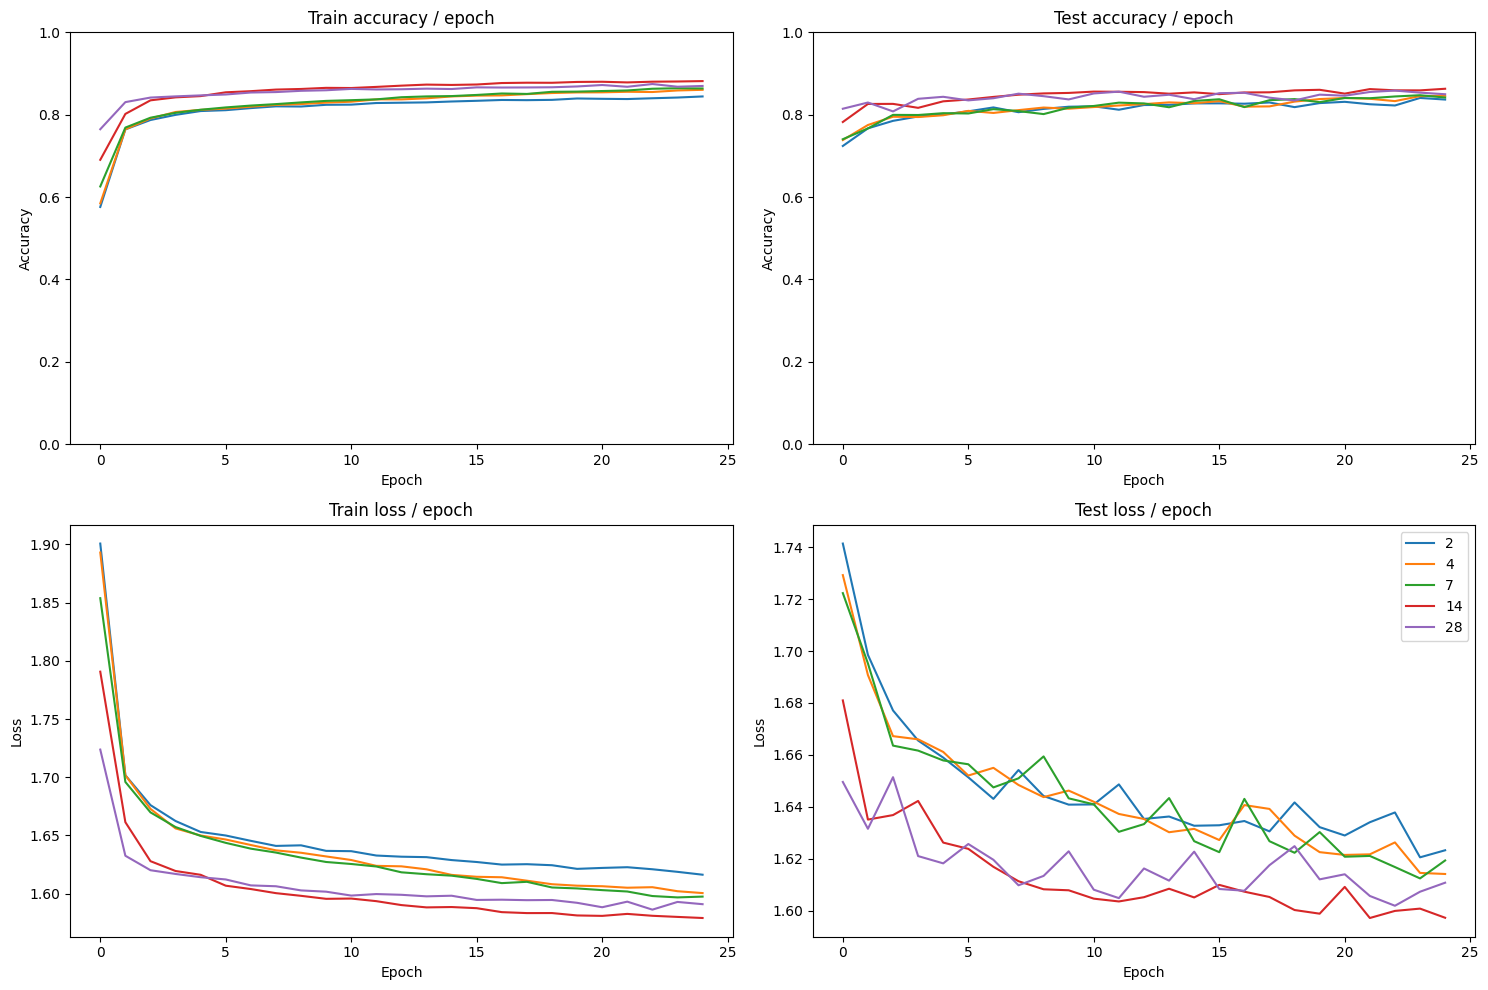

In [20]:
plot_plot_optimizers(plot_optimizers_patch_size, 'patch_size_influence_25')

In [21]:
plot_optimizers_nb_blocks = {}
for nb_blocks in [2,4,6,8]:
    stats = main(epochs=25, nb_blocks=nb_blocks)
    plot_optimizers_nb_blocks[nb_blocks] = stats

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.629 | acc_test 0.750:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.629 | acc_test 0.750:   4%|██▌                                                            | 1/25 [00:06<02:44,  6.85s/it]

acc_train 0.773 | acc_test 0.779:   4%|██▌                                                            | 1/25 [00:13<02:44,  6.85s/it]

acc_train 0.773 | acc_test 0.779:   8%|█████                                                          | 2/25 [00:13<02:33,  6.69s/it]

acc_train 0.797 | acc_test 0.801:   8%|█████                                                          | 2/25 [00:19<02:33,  6.69s/it]

acc_train 0.797 | acc_test 0.801:  12%|███████▌                                                       | 3/25 [00:19<02:25,  6.63s/it]

acc_train 0.807 | acc_test 0.793:  12%|███████▌                                                       | 3/25 [00:26<02:25,  6.63s/it]

acc_train 0.807 | acc_test 0.793:  16%|██████████                                                     | 4/25 [00:26<02:19,  6.66s/it]

acc_train 0.817 | acc_test 0.808:  16%|██████████                                                     | 4/25 [00:33<02:19,  6.66s/it]

acc_train 0.817 | acc_test 0.808:  20%|████████████▌                                                  | 5/25 [00:33<02:13,  6.66s/it]

acc_train 0.826 | acc_test 0.815:  20%|████████████▌                                                  | 5/25 [00:39<02:13,  6.66s/it]

acc_train 0.826 | acc_test 0.815:  24%|███████████████                                                | 6/25 [00:39<02:05,  6.63s/it]

acc_train 0.833 | acc_test 0.822:  24%|███████████████                                                | 6/25 [00:46<02:05,  6.63s/it]

acc_train 0.833 | acc_test 0.822:  28%|█████████████████▋                                             | 7/25 [00:46<01:58,  6.59s/it]

acc_train 0.836 | acc_test 0.825:  28%|█████████████████▋                                             | 7/25 [00:53<01:58,  6.59s/it]

acc_train 0.836 | acc_test 0.825:  32%|████████████████████▏                                          | 8/25 [00:53<01:55,  6.78s/it]

acc_train 0.840 | acc_test 0.817:  32%|████████████████████▏                                          | 8/25 [01:00<01:55,  6.78s/it]

acc_train 0.840 | acc_test 0.817:  36%|██████████████████████▋                                        | 9/25 [01:00<01:47,  6.73s/it]

acc_train 0.838 | acc_test 0.839:  36%|██████████████████████▋                                        | 9/25 [01:06<01:47,  6.73s/it]

acc_train 0.838 | acc_test 0.839:  40%|████████████████████████▊                                     | 10/25 [01:06<01:40,  6.69s/it]

acc_train 0.844 | acc_test 0.839:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.69s/it]

acc_train 0.844 | acc_test 0.839:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:33,  6.67s/it]

acc_train 0.847 | acc_test 0.838:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:33,  6.67s/it]

acc_train 0.847 | acc_test 0.838:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:27,  6.69s/it]

acc_train 0.850 | acc_test 0.838:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:27,  6.69s/it]

acc_train 0.850 | acc_test 0.838:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:19,  6.66s/it]

acc_train 0.853 | acc_test 0.843:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:19,  6.66s/it]

acc_train 0.853 | acc_test 0.843:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:13,  6.65s/it]

acc_train 0.854 | acc_test 0.832:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:13,  6.65s/it]

acc_train 0.854 | acc_test 0.832:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:06,  6.68s/it]

acc_train 0.855 | acc_test 0.832:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:06,  6.68s/it]

acc_train 0.855 | acc_test 0.832:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:59,  6.62s/it]

acc_train 0.857 | acc_test 0.842:  64%|███████████████████████████████████████▋                      | 16/25 [01:53<00:59,  6.62s/it]

acc_train 0.857 | acc_test 0.842:  68%|██████████████████████████████████████████▏                   | 17/25 [01:53<00:52,  6.58s/it]

acc_train 0.859 | acc_test 0.847:  68%|██████████████████████████████████████████▏                   | 17/25 [01:59<00:52,  6.58s/it]

acc_train 0.859 | acc_test 0.847:  72%|████████████████████████████████████████████▋                 | 18/25 [01:59<00:45,  6.54s/it]

acc_train 0.861 | acc_test 0.840:  72%|████████████████████████████████████████████▋                 | 18/25 [02:06<00:45,  6.54s/it]

acc_train 0.861 | acc_test 0.840:  76%|███████████████████████████████████████████████               | 19/25 [02:06<00:39,  6.59s/it]

acc_train 0.863 | acc_test 0.842:  76%|███████████████████████████████████████████████               | 19/25 [02:12<00:39,  6.59s/it]

acc_train 0.863 | acc_test 0.842:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:12<00:33,  6.61s/it]

acc_train 0.863 | acc_test 0.850:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:19<00:33,  6.61s/it]

acc_train 0.863 | acc_test 0.850:  84%|████████████████████████████████████████████████████          | 21/25 [02:19<00:26,  6.56s/it]

acc_train 0.867 | acc_test 0.842:  84%|████████████████████████████████████████████████████          | 21/25 [02:26<00:26,  6.56s/it]

acc_train 0.867 | acc_test 0.842:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:26<00:19,  6.59s/it]

acc_train 0.866 | acc_test 0.847:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:19,  6.59s/it]

acc_train 0.866 | acc_test 0.847:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:32<00:13,  6.58s/it]

acc_train 0.869 | acc_test 0.853:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:39<00:13,  6.58s/it]

acc_train 0.869 | acc_test 0.853:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:39<00:06,  6.60s/it]

acc_train 0.871 | acc_test 0.856:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.60s/it]

acc_train 0.871 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.59s/it]

acc_train 0.871 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.63s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.666 | acc_test 0.781:   0%|                                                                       | 0/25 [00:07<?, ?it/s]

acc_train 0.666 | acc_test 0.781:   4%|██▌                                                            | 1/25 [00:07<03:10,  7.94s/it]

acc_train 0.798 | acc_test 0.809:   4%|██▌                                                            | 1/25 [00:15<03:10,  7.94s/it]

acc_train 0.798 | acc_test 0.809:   8%|█████                                                          | 2/25 [00:15<02:59,  7.80s/it]

acc_train 0.810 | acc_test 0.804:   8%|█████                                                          | 2/25 [00:23<02:59,  7.80s/it]

acc_train 0.810 | acc_test 0.804:  12%|███████▌                                                       | 3/25 [00:23<02:50,  7.75s/it]

acc_train 0.822 | acc_test 0.828:  12%|███████▌                                                       | 3/25 [00:31<02:50,  7.75s/it]

acc_train 0.822 | acc_test 0.828:  16%|██████████                                                     | 4/25 [00:31<02:43,  7.78s/it]

acc_train 0.831 | acc_test 0.824:  16%|██████████                                                     | 4/25 [00:38<02:43,  7.78s/it]

acc_train 0.831 | acc_test 0.824:  20%|████████████▌                                                  | 5/25 [00:38<02:35,  7.76s/it]

acc_train 0.837 | acc_test 0.814:  20%|████████████▌                                                  | 5/25 [00:46<02:35,  7.76s/it]

acc_train 0.837 | acc_test 0.814:  24%|███████████████                                                | 6/25 [00:46<02:28,  7.81s/it]

acc_train 0.842 | acc_test 0.836:  24%|███████████████                                                | 6/25 [00:54<02:28,  7.81s/it]

acc_train 0.842 | acc_test 0.836:  28%|█████████████████▋                                             | 7/25 [00:54<02:19,  7.77s/it]

acc_train 0.843 | acc_test 0.841:  28%|█████████████████▋                                             | 7/25 [01:02<02:19,  7.77s/it]

acc_train 0.843 | acc_test 0.841:  32%|████████████████████▏                                          | 8/25 [01:02<02:13,  7.83s/it]

acc_train 0.850 | acc_test 0.839:  32%|████████████████████▏                                          | 8/25 [01:10<02:13,  7.83s/it]

acc_train 0.850 | acc_test 0.839:  36%|██████████████████████▋                                        | 9/25 [01:10<02:04,  7.78s/it]

acc_train 0.848 | acc_test 0.844:  36%|██████████████████████▋                                        | 9/25 [01:17<02:04,  7.78s/it]

acc_train 0.848 | acc_test 0.844:  40%|████████████████████████▊                                     | 10/25 [01:17<01:57,  7.80s/it]

acc_train 0.854 | acc_test 0.841:  40%|████████████████████████▊                                     | 10/25 [01:25<01:57,  7.80s/it]

acc_train 0.854 | acc_test 0.841:  44%|███████████████████████████▎                                  | 11/25 [01:25<01:48,  7.77s/it]

acc_train 0.860 | acc_test 0.836:  44%|███████████████████████████▎                                  | 11/25 [01:33<01:48,  7.77s/it]

acc_train 0.860 | acc_test 0.836:  48%|█████████████████████████████▊                                | 12/25 [01:33<01:41,  7.79s/it]

acc_train 0.860 | acc_test 0.845:  48%|█████████████████████████████▊                                | 12/25 [01:41<01:41,  7.79s/it]

acc_train 0.860 | acc_test 0.845:  52%|████████████████████████████████▏                             | 13/25 [01:41<01:33,  7.83s/it]

acc_train 0.863 | acc_test 0.849:  52%|████████████████████████████████▏                             | 13/25 [01:49<01:33,  7.83s/it]

acc_train 0.863 | acc_test 0.849:  56%|██████████████████████████████████▋                           | 14/25 [01:49<01:25,  7.78s/it]

acc_train 0.863 | acc_test 0.849:  56%|██████████████████████████████████▋                           | 14/25 [01:56<01:25,  7.78s/it]

acc_train 0.863 | acc_test 0.849:  60%|█████████████████████████████████████▏                        | 15/25 [01:56<01:18,  7.81s/it]

acc_train 0.866 | acc_test 0.855:  60%|█████████████████████████████████████▏                        | 15/25 [02:04<01:18,  7.81s/it]

acc_train 0.866 | acc_test 0.855:  64%|███████████████████████████████████████▋                      | 16/25 [02:04<01:10,  7.82s/it]

acc_train 0.867 | acc_test 0.850:  64%|███████████████████████████████████████▋                      | 16/25 [02:12<01:10,  7.82s/it]

acc_train 0.867 | acc_test 0.850:  68%|██████████████████████████████████████████▏                   | 17/25 [02:12<01:02,  7.82s/it]

acc_train 0.867 | acc_test 0.856:  68%|██████████████████████████████████████████▏                   | 17/25 [02:20<01:02,  7.82s/it]

acc_train 0.867 | acc_test 0.856:  72%|████████████████████████████████████████████▋                 | 18/25 [02:20<00:54,  7.83s/it]

acc_train 0.870 | acc_test 0.861:  72%|████████████████████████████████████████████▋                 | 18/25 [02:28<00:54,  7.83s/it]

acc_train 0.870 | acc_test 0.861:  76%|███████████████████████████████████████████████               | 19/25 [02:28<00:46,  7.79s/it]

acc_train 0.871 | acc_test 0.861:  76%|███████████████████████████████████████████████               | 19/25 [02:35<00:46,  7.79s/it]

acc_train 0.871 | acc_test 0.861:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:35<00:38,  7.77s/it]

acc_train 0.872 | acc_test 0.859:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:43<00:38,  7.77s/it]

acc_train 0.872 | acc_test 0.859:  84%|████████████████████████████████████████████████████          | 21/25 [02:43<00:31,  7.76s/it]

acc_train 0.873 | acc_test 0.858:  84%|████████████████████████████████████████████████████          | 21/25 [02:51<00:31,  7.76s/it]

acc_train 0.873 | acc_test 0.858:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:51<00:23,  7.74s/it]

acc_train 0.875 | acc_test 0.862:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:59<00:23,  7.74s/it]

acc_train 0.875 | acc_test 0.862:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:59<00:15,  7.74s/it]

acc_train 0.872 | acc_test 0.856:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:06<00:15,  7.74s/it]

acc_train 0.872 | acc_test 0.856:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:06<00:07,  7.73s/it]

acc_train 0.875 | acc_test 0.856:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:14<00:07,  7.73s/it]

acc_train 0.875 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:14<00:00,  7.72s/it]

acc_train 0.875 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:14<00:00,  7.78s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.663 | acc_test 0.742:   0%|                                                                       | 0/25 [00:08<?, ?it/s]

acc_train 0.663 | acc_test 0.742:   4%|██▌                                                            | 1/25 [00:08<03:35,  8.97s/it]

acc_train 0.768 | acc_test 0.765:   4%|██▌                                                            | 1/25 [00:18<03:35,  8.97s/it]

acc_train 0.768 | acc_test 0.765:   8%|█████                                                          | 2/25 [00:18<03:28,  9.07s/it]

acc_train 0.800 | acc_test 0.813:   8%|█████                                                          | 2/25 [00:27<03:28,  9.07s/it]

acc_train 0.800 | acc_test 0.813:  12%|███████▌                                                       | 3/25 [00:27<03:18,  9.01s/it]

acc_train 0.820 | acc_test 0.807:  12%|███████▌                                                       | 3/25 [00:36<03:18,  9.01s/it]

acc_train 0.820 | acc_test 0.807:  16%|██████████                                                     | 4/25 [00:36<03:10,  9.06s/it]

acc_train 0.829 | acc_test 0.819:  16%|██████████                                                     | 4/25 [00:45<03:10,  9.06s/it]

acc_train 0.829 | acc_test 0.819:  20%|████████████▌                                                  | 5/25 [00:45<03:01,  9.06s/it]

acc_train 0.833 | acc_test 0.826:  20%|████████████▌                                                  | 5/25 [00:54<03:01,  9.06s/it]

acc_train 0.833 | acc_test 0.826:  24%|███████████████                                                | 6/25 [00:54<02:51,  9.03s/it]

acc_train 0.837 | acc_test 0.814:  24%|███████████████                                                | 6/25 [01:03<02:51,  9.03s/it]

acc_train 0.837 | acc_test 0.814:  28%|█████████████████▋                                             | 7/25 [01:03<02:42,  9.01s/it]

acc_train 0.839 | acc_test 0.849:  28%|█████████████████▋                                             | 7/25 [01:12<02:42,  9.01s/it]

acc_train 0.839 | acc_test 0.849:  32%|████████████████████▏                                          | 8/25 [01:12<02:33,  9.05s/it]

acc_train 0.848 | acc_test 0.835:  32%|████████████████████▏                                          | 8/25 [01:21<02:33,  9.05s/it]

acc_train 0.848 | acc_test 0.835:  36%|██████████████████████▋                                        | 9/25 [01:21<02:24,  9.03s/it]

acc_train 0.850 | acc_test 0.845:  36%|██████████████████████▋                                        | 9/25 [01:30<02:24,  9.03s/it]

acc_train 0.850 | acc_test 0.845:  40%|████████████████████████▊                                     | 10/25 [01:30<02:15,  9.04s/it]

acc_train 0.852 | acc_test 0.845:  40%|████████████████████████▊                                     | 10/25 [01:39<02:15,  9.04s/it]

acc_train 0.852 | acc_test 0.845:  44%|███████████████████████████▎                                  | 11/25 [01:39<02:06,  9.06s/it]

acc_train 0.855 | acc_test 0.844:  44%|███████████████████████████▎                                  | 11/25 [01:48<02:06,  9.06s/it]

acc_train 0.855 | acc_test 0.844:  48%|█████████████████████████████▊                                | 12/25 [01:48<01:59,  9.16s/it]

acc_train 0.859 | acc_test 0.838:  48%|█████████████████████████████▊                                | 12/25 [01:57<01:59,  9.16s/it]

acc_train 0.859 | acc_test 0.838:  52%|████████████████████████████████▏                             | 13/25 [01:57<01:49,  9.15s/it]

acc_train 0.857 | acc_test 0.845:  52%|████████████████████████████████▏                             | 13/25 [02:06<01:49,  9.15s/it]

acc_train 0.857 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [02:06<01:39,  9.08s/it]

acc_train 0.860 | acc_test 0.851:  56%|██████████████████████████████████▋                           | 14/25 [02:15<01:39,  9.08s/it]

acc_train 0.860 | acc_test 0.851:  60%|█████████████████████████████████████▏                        | 15/25 [02:15<01:30,  9.08s/it]

acc_train 0.859 | acc_test 0.840:  60%|█████████████████████████████████████▏                        | 15/25 [02:25<01:30,  9.08s/it]

acc_train 0.859 | acc_test 0.840:  64%|███████████████████████████████████████▋                      | 16/25 [02:25<01:21,  9.08s/it]

acc_train 0.865 | acc_test 0.852:  64%|███████████████████████████████████████▋                      | 16/25 [02:34<01:21,  9.08s/it]

acc_train 0.865 | acc_test 0.852:  68%|██████████████████████████████████████████▏                   | 17/25 [02:34<01:12,  9.08s/it]

acc_train 0.867 | acc_test 0.848:  68%|██████████████████████████████████████████▏                   | 17/25 [02:43<01:12,  9.08s/it]

acc_train 0.867 | acc_test 0.848:  72%|████████████████████████████████████████████▋                 | 18/25 [02:43<01:03,  9.03s/it]

acc_train 0.867 | acc_test 0.860:  72%|████████████████████████████████████████████▋                 | 18/25 [02:51<01:03,  9.03s/it]

acc_train 0.867 | acc_test 0.860:  76%|███████████████████████████████████████████████               | 19/25 [02:51<00:53,  8.99s/it]

acc_train 0.868 | acc_test 0.857:  76%|███████████████████████████████████████████████               | 19/25 [03:00<00:53,  8.99s/it]

acc_train 0.868 | acc_test 0.857:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:00<00:44,  8.96s/it]

acc_train 0.868 | acc_test 0.842:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:09<00:44,  8.96s/it]

acc_train 0.868 | acc_test 0.842:  84%|████████████████████████████████████████████████████          | 21/25 [03:09<00:35,  8.94s/it]

acc_train 0.868 | acc_test 0.849:  84%|████████████████████████████████████████████████████          | 21/25 [03:18<00:35,  8.94s/it]

acc_train 0.868 | acc_test 0.849:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:18<00:26,  8.92s/it]

acc_train 0.870 | acc_test 0.857:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:27<00:26,  8.92s/it]

acc_train 0.870 | acc_test 0.857:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:27<00:17,  8.91s/it]

acc_train 0.869 | acc_test 0.852:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:36<00:17,  8.91s/it]

acc_train 0.869 | acc_test 0.852:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:36<00:08,  8.91s/it]

acc_train 0.872 | acc_test 0.859:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:45<00:08,  8.91s/it]

acc_train 0.872 | acc_test 0.859: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:45<00:00,  8.95s/it]

acc_train 0.872 | acc_test 0.859: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:45<00:00,  9.02s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.633 | acc_test 0.734:   0%|                                                                       | 0/25 [00:10<?, ?it/s]

acc_train 0.633 | acc_test 0.734:   4%|██▌                                                            | 1/25 [00:10<04:04, 10.17s/it]

acc_train 0.752 | acc_test 0.758:   4%|██▌                                                            | 1/25 [00:20<04:04, 10.17s/it]

acc_train 0.752 | acc_test 0.758:   8%|█████                                                          | 2/25 [00:20<03:56, 10.27s/it]

acc_train 0.767 | acc_test 0.769:   8%|█████                                                          | 2/25 [00:31<03:56, 10.27s/it]

acc_train 0.767 | acc_test 0.769:  12%|███████▌                                                       | 3/25 [00:31<03:48, 10.40s/it]

acc_train 0.780 | acc_test 0.780:  12%|███████▌                                                       | 3/25 [00:41<03:48, 10.40s/it]

acc_train 0.780 | acc_test 0.780:  16%|██████████                                                     | 4/25 [00:41<03:40, 10.48s/it]

acc_train 0.786 | acc_test 0.785:  16%|██████████                                                     | 4/25 [00:51<03:40, 10.48s/it]

acc_train 0.786 | acc_test 0.785:  20%|████████████▌                                                  | 5/25 [00:51<03:28, 10.41s/it]

acc_train 0.791 | acc_test 0.776:  20%|████████████▌                                                  | 5/25 [01:02<03:28, 10.41s/it]

acc_train 0.791 | acc_test 0.776:  24%|███████████████                                                | 6/25 [01:02<03:16, 10.36s/it]

acc_train 0.791 | acc_test 0.785:  24%|███████████████                                                | 6/25 [01:12<03:16, 10.36s/it]

acc_train 0.791 | acc_test 0.785:  28%|█████████████████▋                                             | 7/25 [01:12<03:05, 10.33s/it]

acc_train 0.793 | acc_test 0.789:  28%|█████████████████▋                                             | 7/25 [01:22<03:05, 10.33s/it]

acc_train 0.793 | acc_test 0.789:  32%|████████████████████▏                                          | 8/25 [01:22<02:55, 10.32s/it]

acc_train 0.800 | acc_test 0.806:  32%|████████████████████▏                                          | 8/25 [01:33<02:55, 10.32s/it]

acc_train 0.800 | acc_test 0.806:  36%|██████████████████████▋                                        | 9/25 [01:33<02:45, 10.33s/it]

acc_train 0.827 | acc_test 0.817:  36%|██████████████████████▋                                        | 9/25 [01:43<02:45, 10.33s/it]

acc_train 0.827 | acc_test 0.817:  40%|████████████████████████▊                                     | 10/25 [01:43<02:35, 10.35s/it]

acc_train 0.827 | acc_test 0.829:  40%|████████████████████████▊                                     | 10/25 [01:54<02:35, 10.35s/it]

acc_train 0.827 | acc_test 0.829:  44%|███████████████████████████▎                                  | 11/25 [01:54<02:25, 10.41s/it]

acc_train 0.834 | acc_test 0.816:  44%|███████████████████████████▎                                  | 11/25 [02:04<02:25, 10.41s/it]

acc_train 0.834 | acc_test 0.816:  48%|█████████████████████████████▊                                | 12/25 [02:04<02:14, 10.38s/it]

acc_train 0.840 | acc_test 0.820:  48%|█████████████████████████████▊                                | 12/25 [02:14<02:14, 10.38s/it]

acc_train 0.840 | acc_test 0.820:  52%|████████████████████████████████▏                             | 13/25 [02:14<02:04, 10.37s/it]

acc_train 0.839 | acc_test 0.836:  52%|████████████████████████████████▏                             | 13/25 [02:25<02:04, 10.37s/it]

acc_train 0.839 | acc_test 0.836:  56%|██████████████████████████████████▋                           | 14/25 [02:25<01:53, 10.35s/it]

acc_train 0.842 | acc_test 0.834:  56%|██████████████████████████████████▋                           | 14/25 [02:35<01:53, 10.35s/it]

acc_train 0.842 | acc_test 0.834:  60%|█████████████████████████████████████▏                        | 15/25 [02:35<01:43, 10.35s/it]

acc_train 0.841 | acc_test 0.839:  60%|█████████████████████████████████████▏                        | 15/25 [02:45<01:43, 10.35s/it]

acc_train 0.841 | acc_test 0.839:  64%|███████████████████████████████████████▋                      | 16/25 [02:45<01:33, 10.34s/it]

acc_train 0.843 | acc_test 0.814:  64%|███████████████████████████████████████▋                      | 16/25 [02:55<01:33, 10.34s/it]

acc_train 0.843 | acc_test 0.814:  68%|██████████████████████████████████████████▏                   | 17/25 [02:55<01:22, 10.33s/it]

acc_train 0.843 | acc_test 0.836:  68%|██████████████████████████████████████████▏                   | 17/25 [03:06<01:22, 10.33s/it]

acc_train 0.843 | acc_test 0.836:  72%|████████████████████████████████████████████▋                 | 18/25 [03:06<01:12, 10.33s/it]

acc_train 0.846 | acc_test 0.814:  72%|████████████████████████████████████████████▋                 | 18/25 [03:16<01:12, 10.33s/it]

acc_train 0.846 | acc_test 0.814:  76%|███████████████████████████████████████████████               | 19/25 [03:16<01:02, 10.43s/it]

acc_train 0.849 | acc_test 0.845:  76%|███████████████████████████████████████████████               | 19/25 [03:27<01:02, 10.43s/it]

acc_train 0.849 | acc_test 0.845:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:27<00:52, 10.40s/it]

acc_train 0.851 | acc_test 0.843:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:37<00:52, 10.40s/it]

acc_train 0.851 | acc_test 0.843:  84%|████████████████████████████████████████████████████          | 21/25 [03:37<00:41, 10.38s/it]

acc_train 0.856 | acc_test 0.847:  84%|████████████████████████████████████████████████████          | 21/25 [03:47<00:41, 10.38s/it]

acc_train 0.856 | acc_test 0.847:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:47<00:31, 10.36s/it]

acc_train 0.854 | acc_test 0.845:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:58<00:31, 10.36s/it]

acc_train 0.854 | acc_test 0.845:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:58<00:20, 10.35s/it]

acc_train 0.858 | acc_test 0.842:  92%|█████████████████████████████████████████████████████████     | 23/25 [04:08<00:20, 10.35s/it]

acc_train 0.858 | acc_test 0.842:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [04:08<00:10, 10.35s/it]

acc_train 0.859 | acc_test 0.836:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [04:18<00:10, 10.35s/it]

acc_train 0.859 | acc_test 0.836: 100%|██████████████████████████████████████████████████████████████| 25/25 [04:18<00:00, 10.34s/it]

acc_train 0.859 | acc_test 0.836: 100%|██████████████████████████████████████████████████████████████| 25/25 [04:18<00:00, 10.36s/it]

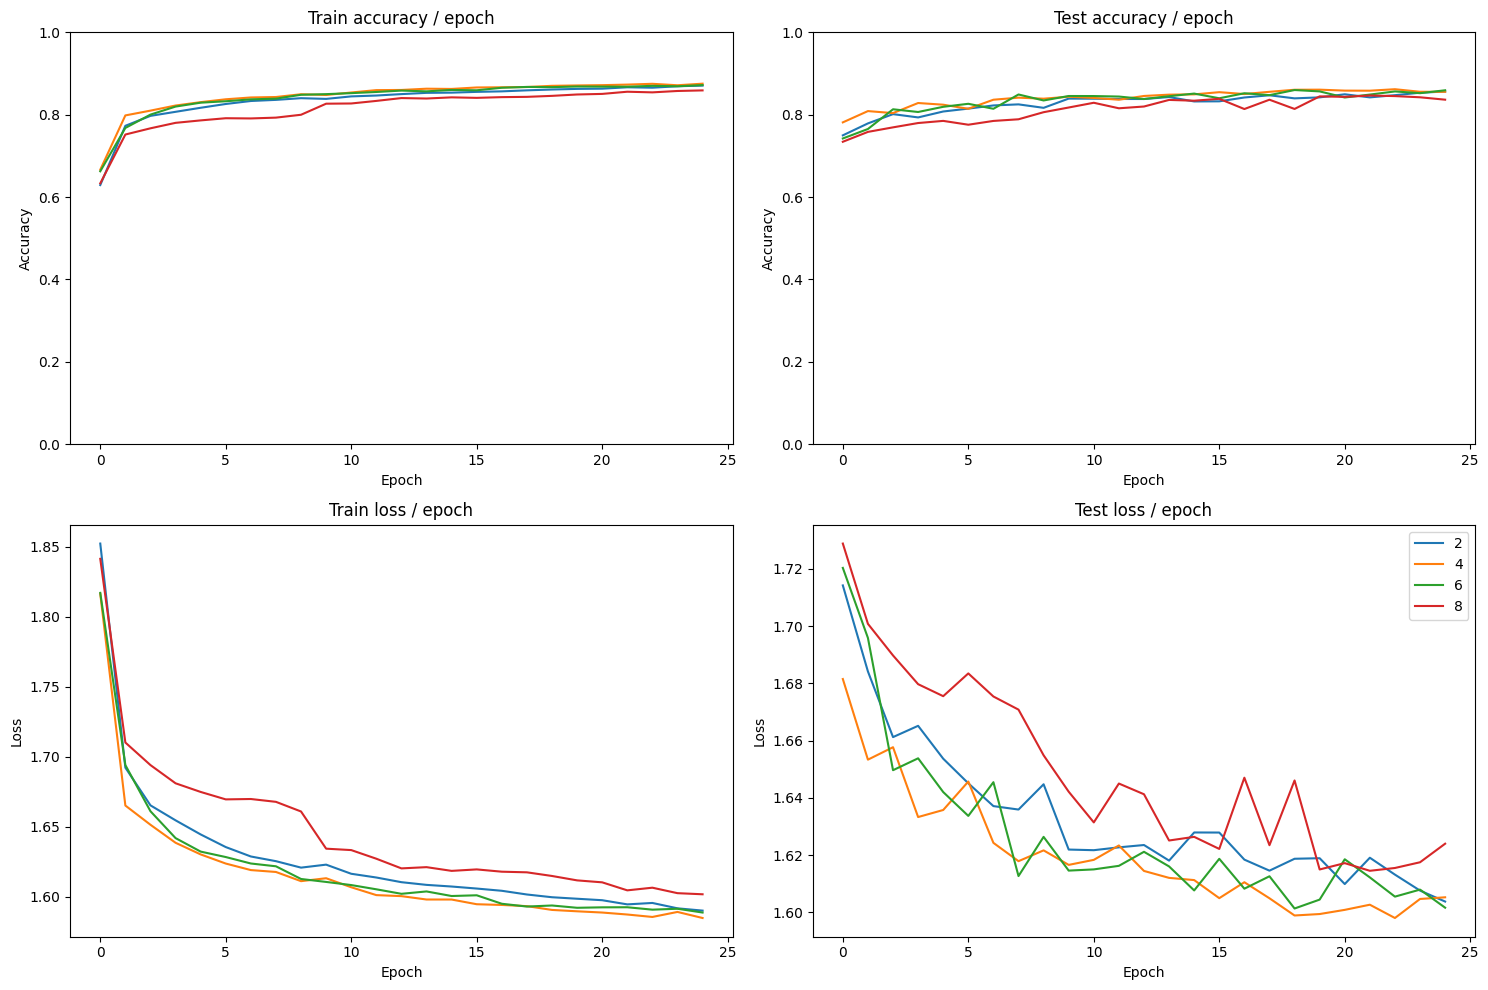

In [22]:
plot_plot_optimizers(plot_optimizers_nb_blocks, 'nb_block_influence_25')

In [23]:
plot_optimizers_num_heads = {}
for num_heads in [2,4,8,16]:
    stats = main(epochs=25, num_heads=num_heads)
    plot_optimizers_num_heads[num_heads] = stats

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.620 | acc_test 0.755:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.620 | acc_test 0.755:   4%|██▌                                                            | 1/25 [00:06<02:42,  6.77s/it]

acc_train 0.771 | acc_test 0.775:   4%|██▌                                                            | 1/25 [00:13<02:42,  6.77s/it]

acc_train 0.771 | acc_test 0.775:   8%|█████                                                          | 2/25 [00:13<02:33,  6.67s/it]

acc_train 0.789 | acc_test 0.794:   8%|█████                                                          | 2/25 [00:19<02:33,  6.67s/it]

acc_train 0.789 | acc_test 0.794:  12%|███████▌                                                       | 3/25 [00:19<02:25,  6.63s/it]

acc_train 0.803 | acc_test 0.797:  12%|███████▌                                                       | 3/25 [00:26<02:25,  6.63s/it]

acc_train 0.803 | acc_test 0.797:  16%|██████████                                                     | 4/25 [00:26<02:18,  6.61s/it]

acc_train 0.812 | acc_test 0.794:  16%|██████████                                                     | 4/25 [00:33<02:18,  6.61s/it]

acc_train 0.812 | acc_test 0.794:  20%|████████████▌                                                  | 5/25 [00:33<02:12,  6.60s/it]

acc_train 0.820 | acc_test 0.815:  20%|████████████▌                                                  | 5/25 [00:39<02:12,  6.60s/it]

acc_train 0.820 | acc_test 0.815:  24%|███████████████                                                | 6/25 [00:39<02:06,  6.64s/it]

acc_train 0.825 | acc_test 0.805:  24%|███████████████                                                | 6/25 [00:46<02:06,  6.64s/it]

acc_train 0.825 | acc_test 0.805:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.62s/it]

acc_train 0.828 | acc_test 0.815:  28%|█████████████████▋                                             | 7/25 [00:53<01:59,  6.62s/it]

acc_train 0.828 | acc_test 0.815:  32%|████████████████████▏                                          | 8/25 [00:53<01:54,  6.72s/it]

acc_train 0.831 | acc_test 0.811:  32%|████████████████████▏                                          | 8/25 [00:59<01:54,  6.72s/it]

acc_train 0.831 | acc_test 0.811:  36%|██████████████████████▋                                        | 9/25 [00:59<01:46,  6.67s/it]

acc_train 0.835 | acc_test 0.819:  36%|██████████████████████▋                                        | 9/25 [01:06<01:46,  6.67s/it]

acc_train 0.835 | acc_test 0.819:  40%|████████████████████████▊                                     | 10/25 [01:06<01:40,  6.68s/it]

acc_train 0.837 | acc_test 0.814:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.68s/it]

acc_train 0.837 | acc_test 0.814:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:33,  6.65s/it]

acc_train 0.842 | acc_test 0.830:  44%|███████████████████████████▎                                  | 11/25 [01:19<01:33,  6.65s/it]

acc_train 0.842 | acc_test 0.830:  48%|█████████████████████████████▊                                | 12/25 [01:19<01:26,  6.63s/it]

acc_train 0.842 | acc_test 0.829:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:26,  6.63s/it]

acc_train 0.842 | acc_test 0.829:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:19,  6.61s/it]

acc_train 0.842 | acc_test 0.824:  52%|████████████████████████████████▏                             | 13/25 [01:32<01:19,  6.61s/it]

acc_train 0.842 | acc_test 0.824:  56%|██████████████████████████████████▋                           | 14/25 [01:32<01:12,  6.60s/it]

acc_train 0.846 | acc_test 0.832:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:12,  6.60s/it]

acc_train 0.846 | acc_test 0.832:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:05,  6.60s/it]

acc_train 0.849 | acc_test 0.834:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:05,  6.60s/it]

acc_train 0.849 | acc_test 0.834:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:59,  6.63s/it]

acc_train 0.850 | acc_test 0.828:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:59,  6.63s/it]

acc_train 0.850 | acc_test 0.828:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:52,  6.57s/it]

acc_train 0.852 | acc_test 0.836:  68%|██████████████████████████████████████████▏                   | 17/25 [01:59<00:52,  6.57s/it]

acc_train 0.852 | acc_test 0.836:  72%|████████████████████████████████████████████▋                 | 18/25 [01:59<00:45,  6.54s/it]

acc_train 0.852 | acc_test 0.830:  72%|████████████████████████████████████████████▋                 | 18/25 [02:05<00:45,  6.54s/it]

acc_train 0.852 | acc_test 0.830:  76%|███████████████████████████████████████████████               | 19/25 [02:05<00:39,  6.52s/it]

acc_train 0.856 | acc_test 0.837:  76%|███████████████████████████████████████████████               | 19/25 [02:12<00:39,  6.52s/it]

acc_train 0.856 | acc_test 0.837:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:12<00:32,  6.55s/it]

acc_train 0.853 | acc_test 0.837:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:18<00:32,  6.55s/it]

acc_train 0.853 | acc_test 0.837:  84%|████████████████████████████████████████████████████          | 21/25 [02:18<00:26,  6.56s/it]

acc_train 0.855 | acc_test 0.836:  84%|████████████████████████████████████████████████████          | 21/25 [02:25<00:26,  6.56s/it]

acc_train 0.855 | acc_test 0.836:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:25<00:19,  6.53s/it]

acc_train 0.854 | acc_test 0.844:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:31<00:19,  6.53s/it]

acc_train 0.854 | acc_test 0.844:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:31<00:13,  6.56s/it]

acc_train 0.860 | acc_test 0.841:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.56s/it]

acc_train 0.860 | acc_test 0.841:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:38<00:06,  6.60s/it]

acc_train 0.862 | acc_test 0.846:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.60s/it]

acc_train 0.862 | acc_test 0.846: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.56s/it]

acc_train 0.862 | acc_test 0.846: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.60s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.641 | acc_test 0.756:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.641 | acc_test 0.756:   4%|██▌                                                            | 1/25 [00:06<02:36,  6.51s/it]

acc_train 0.781 | acc_test 0.787:   4%|██▌                                                            | 1/25 [00:12<02:36,  6.51s/it]

acc_train 0.781 | acc_test 0.787:   8%|█████                                                          | 2/25 [00:12<02:29,  6.49s/it]

acc_train 0.803 | acc_test 0.802:   8%|█████                                                          | 2/25 [00:19<02:29,  6.49s/it]

acc_train 0.803 | acc_test 0.802:  12%|███████▌                                                       | 3/25 [00:19<02:22,  6.49s/it]

acc_train 0.816 | acc_test 0.803:  12%|███████▌                                                       | 3/25 [00:25<02:22,  6.49s/it]

acc_train 0.816 | acc_test 0.803:  16%|██████████                                                     | 4/25 [00:25<02:16,  6.48s/it]

acc_train 0.830 | acc_test 0.821:  16%|██████████                                                     | 4/25 [00:32<02:16,  6.48s/it]

acc_train 0.830 | acc_test 0.821:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.49s/it]

acc_train 0.837 | acc_test 0.821:  20%|████████████▌                                                  | 5/25 [00:39<02:09,  6.49s/it]

acc_train 0.837 | acc_test 0.821:  24%|███████████████                                                | 6/25 [00:39<02:03,  6.52s/it]

acc_train 0.841 | acc_test 0.826:  24%|███████████████                                                | 6/25 [00:45<02:03,  6.52s/it]

acc_train 0.841 | acc_test 0.826:  28%|█████████████████▋                                             | 7/25 [00:45<01:57,  6.55s/it]

acc_train 0.845 | acc_test 0.818:  28%|█████████████████▋                                             | 7/25 [00:52<01:57,  6.55s/it]

acc_train 0.845 | acc_test 0.818:  32%|████████████████████▏                                          | 8/25 [00:52<01:50,  6.52s/it]

acc_train 0.847 | acc_test 0.837:  32%|████████████████████▏                                          | 8/25 [00:58<01:50,  6.52s/it]

acc_train 0.847 | acc_test 0.837:  36%|██████████████████████▋                                        | 9/25 [00:58<01:44,  6.50s/it]

acc_train 0.851 | acc_test 0.838:  36%|██████████████████████▋                                        | 9/25 [01:05<01:44,  6.50s/it]

acc_train 0.851 | acc_test 0.838:  40%|████████████████████████▊                                     | 10/25 [01:05<01:37,  6.49s/it]

acc_train 0.854 | acc_test 0.847:  40%|████████████████████████▊                                     | 10/25 [01:11<01:37,  6.49s/it]

acc_train 0.854 | acc_test 0.847:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:30,  6.48s/it]

acc_train 0.857 | acc_test 0.839:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.48s/it]

acc_train 0.857 | acc_test 0.839:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:24,  6.48s/it]

acc_train 0.857 | acc_test 0.846:  48%|█████████████████████████████▊                                | 12/25 [01:24<01:24,  6.48s/it]

acc_train 0.857 | acc_test 0.846:  52%|████████████████████████████████▏                             | 13/25 [01:24<01:18,  6.53s/it]

acc_train 0.861 | acc_test 0.833:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:18,  6.53s/it]

acc_train 0.861 | acc_test 0.833:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:11,  6.51s/it]

acc_train 0.860 | acc_test 0.852:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:11,  6.51s/it]

acc_train 0.860 | acc_test 0.852:  60%|█████████████████████████████████████▏                        | 15/25 [01:37<01:04,  6.50s/it]

acc_train 0.863 | acc_test 0.840:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:04,  6.50s/it]

acc_train 0.863 | acc_test 0.840:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:58,  6.49s/it]

acc_train 0.865 | acc_test 0.849:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<00:58,  6.49s/it]

acc_train 0.865 | acc_test 0.849:  68%|██████████████████████████████████████████▏                   | 17/25 [01:50<00:52,  6.59s/it]

acc_train 0.868 | acc_test 0.850:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:52,  6.59s/it]

acc_train 0.868 | acc_test 0.850:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:45,  6.55s/it]

acc_train 0.869 | acc_test 0.851:  72%|████████████████████████████████████████████▋                 | 18/25 [02:03<00:45,  6.55s/it]

acc_train 0.869 | acc_test 0.851:  76%|███████████████████████████████████████████████               | 19/25 [02:03<00:39,  6.52s/it]

acc_train 0.869 | acc_test 0.847:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:39,  6.52s/it]

acc_train 0.869 | acc_test 0.847:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.50s/it]

acc_train 0.872 | acc_test 0.853:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:16<00:32,  6.50s/it]

acc_train 0.872 | acc_test 0.853:  84%|████████████████████████████████████████████████████          | 21/25 [02:16<00:25,  6.48s/it]

acc_train 0.872 | acc_test 0.856:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:25,  6.48s/it]

acc_train 0.872 | acc_test 0.856:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:23<00:19,  6.47s/it]

acc_train 0.873 | acc_test 0.862:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:29<00:19,  6.47s/it]

acc_train 0.873 | acc_test 0.862:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:29<00:12,  6.46s/it]

acc_train 0.874 | acc_test 0.854:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:12,  6.46s/it]

acc_train 0.874 | acc_test 0.854:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:35<00:06,  6.45s/it]

acc_train 0.877 | acc_test 0.861:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:42<00:06,  6.45s/it]

acc_train 0.877 | acc_test 0.861: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.55s/it]

acc_train 0.877 | acc_test 0.861: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.51s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.637 | acc_test 0.760:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.637 | acc_test 0.760:   4%|██▌                                                            | 1/25 [00:06<02:36,  6.51s/it]

acc_train 0.782 | acc_test 0.787:   4%|██▌                                                            | 1/25 [00:13<02:36,  6.51s/it]

acc_train 0.782 | acc_test 0.787:   8%|█████                                                          | 2/25 [00:13<02:29,  6.51s/it]

acc_train 0.806 | acc_test 0.804:   8%|█████                                                          | 2/25 [00:19<02:29,  6.51s/it]

acc_train 0.806 | acc_test 0.804:  12%|███████▌                                                       | 3/25 [00:19<02:26,  6.64s/it]

acc_train 0.813 | acc_test 0.794:  12%|███████▌                                                       | 3/25 [00:26<02:26,  6.64s/it]

acc_train 0.813 | acc_test 0.794:  16%|██████████                                                     | 4/25 [00:26<02:21,  6.72s/it]

acc_train 0.820 | acc_test 0.801:  16%|██████████                                                     | 4/25 [00:33<02:21,  6.72s/it]

acc_train 0.820 | acc_test 0.801:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.71s/it]

acc_train 0.825 | acc_test 0.818:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.71s/it]

acc_train 0.825 | acc_test 0.818:  24%|███████████████                                                | 6/25 [00:40<02:08,  6.74s/it]

acc_train 0.830 | acc_test 0.796:  24%|███████████████                                                | 6/25 [00:46<02:08,  6.74s/it]

acc_train 0.830 | acc_test 0.796:  28%|█████████████████▋                                             | 7/25 [00:46<02:00,  6.72s/it]

acc_train 0.837 | acc_test 0.815:  28%|█████████████████▋                                             | 7/25 [00:53<02:00,  6.72s/it]

acc_train 0.837 | acc_test 0.815:  32%|████████████████████▏                                          | 8/25 [00:53<01:53,  6.65s/it]

acc_train 0.838 | acc_test 0.829:  32%|████████████████████▏                                          | 8/25 [00:59<01:53,  6.65s/it]

acc_train 0.838 | acc_test 0.829:  36%|██████████████████████▋                                        | 9/25 [00:59<01:45,  6.61s/it]

acc_train 0.844 | acc_test 0.820:  36%|██████████████████████▋                                        | 9/25 [01:06<01:45,  6.61s/it]

acc_train 0.844 | acc_test 0.820:  40%|████████████████████████▊                                     | 10/25 [01:06<01:40,  6.72s/it]

acc_train 0.846 | acc_test 0.839:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.72s/it]

acc_train 0.846 | acc_test 0.839:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:34,  6.76s/it]

acc_train 0.850 | acc_test 0.832:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:34,  6.76s/it]

acc_train 0.850 | acc_test 0.832:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:27,  6.74s/it]

acc_train 0.851 | acc_test 0.833:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:27,  6.74s/it]

acc_train 0.851 | acc_test 0.833:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:20,  6.74s/it]

acc_train 0.855 | acc_test 0.845:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:20,  6.74s/it]

acc_train 0.855 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:14,  6.76s/it]

acc_train 0.858 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:14,  6.76s/it]

acc_train 0.858 | acc_test 0.845:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:07,  6.74s/it]

acc_train 0.862 | acc_test 0.846:  60%|█████████████████████████████████████▏                        | 15/25 [01:47<01:07,  6.74s/it]

acc_train 0.862 | acc_test 0.846:  64%|███████████████████████████████████████▋                      | 16/25 [01:47<01:00,  6.72s/it]

acc_train 0.863 | acc_test 0.835:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.72s/it]

acc_train 0.863 | acc_test 0.835:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:53,  6.74s/it]

acc_train 0.865 | acc_test 0.852:  68%|██████████████████████████████████████████▏                   | 17/25 [02:00<00:53,  6.74s/it]

acc_train 0.865 | acc_test 0.852:  72%|████████████████████████████████████████████▋                 | 18/25 [02:00<00:47,  6.79s/it]

acc_train 0.868 | acc_test 0.852:  72%|████████████████████████████████████████████▋                 | 18/25 [02:07<00:47,  6.79s/it]

acc_train 0.868 | acc_test 0.852:  76%|███████████████████████████████████████████████               | 19/25 [02:07<00:40,  6.70s/it]

acc_train 0.867 | acc_test 0.841:  76%|███████████████████████████████████████████████               | 19/25 [02:13<00:40,  6.70s/it]

acc_train 0.867 | acc_test 0.841:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:13<00:33,  6.62s/it]

acc_train 0.868 | acc_test 0.856:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:20<00:33,  6.62s/it]

acc_train 0.868 | acc_test 0.856:  84%|████████████████████████████████████████████████████          | 21/25 [02:20<00:26,  6.57s/it]

acc_train 0.871 | acc_test 0.841:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:26,  6.57s/it]

acc_train 0.871 | acc_test 0.841:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:19,  6.65s/it]

acc_train 0.873 | acc_test 0.851:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:33<00:19,  6.65s/it]

acc_train 0.873 | acc_test 0.851:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:33<00:13,  6.66s/it]

acc_train 0.873 | acc_test 0.855:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:40<00:13,  6.66s/it]

acc_train 0.873 | acc_test 0.855:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.72s/it]

acc_train 0.874 | acc_test 0.860:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:47<00:06,  6.72s/it]

acc_train 0.874 | acc_test 0.860: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.71s/it]

acc_train 0.874 | acc_test 0.860: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.70s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.643 | acc_test 0.770:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.643 | acc_test 0.770:   4%|██▌                                                            | 1/25 [00:06<02:44,  6.86s/it]

acc_train 0.795 | acc_test 0.797:   4%|██▌                                                            | 1/25 [00:13<02:44,  6.86s/it]

acc_train 0.795 | acc_test 0.797:   8%|█████                                                          | 2/25 [00:13<02:38,  6.90s/it]

acc_train 0.817 | acc_test 0.821:   8%|█████                                                          | 2/25 [00:20<02:38,  6.90s/it]

acc_train 0.817 | acc_test 0.821:  12%|███████▌                                                       | 3/25 [00:20<02:29,  6.81s/it]

acc_train 0.828 | acc_test 0.815:  12%|███████▌                                                       | 3/25 [00:27<02:29,  6.81s/it]

acc_train 0.828 | acc_test 0.815:  16%|██████████                                                     | 4/25 [00:27<02:21,  6.74s/it]

acc_train 0.839 | acc_test 0.834:  16%|██████████                                                     | 4/25 [00:33<02:21,  6.74s/it]

acc_train 0.839 | acc_test 0.834:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.72s/it]

acc_train 0.844 | acc_test 0.841:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.72s/it]

acc_train 0.844 | acc_test 0.841:  24%|███████████████                                                | 6/25 [00:40<02:08,  6.77s/it]

acc_train 0.851 | acc_test 0.843:  24%|███████████████                                                | 6/25 [00:47<02:08,  6.77s/it]

acc_train 0.851 | acc_test 0.843:  28%|█████████████████▋                                             | 7/25 [00:47<02:02,  6.80s/it]

acc_train 0.853 | acc_test 0.844:  28%|█████████████████▋                                             | 7/25 [00:54<02:02,  6.80s/it]

acc_train 0.853 | acc_test 0.844:  32%|████████████████████▏                                          | 8/25 [00:54<01:54,  6.74s/it]

acc_train 0.857 | acc_test 0.841:  32%|████████████████████▏                                          | 8/25 [01:00<01:54,  6.74s/it]

acc_train 0.857 | acc_test 0.841:  36%|██████████████████████▋                                        | 9/25 [01:00<01:46,  6.67s/it]

acc_train 0.859 | acc_test 0.846:  36%|██████████████████████▋                                        | 9/25 [01:07<01:46,  6.67s/it]

acc_train 0.859 | acc_test 0.846:  40%|████████████████████████▊                                     | 10/25 [01:07<01:40,  6.69s/it]

acc_train 0.861 | acc_test 0.842:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.69s/it]

acc_train 0.861 | acc_test 0.842:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:33,  6.66s/it]

acc_train 0.862 | acc_test 0.836:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:33,  6.66s/it]

acc_train 0.862 | acc_test 0.836:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:26,  6.62s/it]

acc_train 0.865 | acc_test 0.858:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:26,  6.62s/it]

acc_train 0.865 | acc_test 0.858:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:19,  6.59s/it]

acc_train 0.870 | acc_test 0.853:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:19,  6.59s/it]

acc_train 0.870 | acc_test 0.853:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:12,  6.57s/it]

acc_train 0.870 | acc_test 0.858:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:12,  6.57s/it]

acc_train 0.870 | acc_test 0.858:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:05,  6.54s/it]

acc_train 0.872 | acc_test 0.851:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:05,  6.54s/it]

acc_train 0.872 | acc_test 0.851:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:58,  6.53s/it]

acc_train 0.871 | acc_test 0.851:  64%|███████████████████████████████████████▋                      | 16/25 [01:53<00:58,  6.53s/it]

acc_train 0.871 | acc_test 0.851:  68%|██████████████████████████████████████████▏                   | 17/25 [01:53<00:52,  6.53s/it]

acc_train 0.876 | acc_test 0.850:  68%|██████████████████████████████████████████▏                   | 17/25 [01:59<00:52,  6.53s/it]

acc_train 0.876 | acc_test 0.850:  72%|████████████████████████████████████████████▋                 | 18/25 [01:59<00:45,  6.52s/it]

acc_train 0.877 | acc_test 0.857:  72%|████████████████████████████████████████████▋                 | 18/25 [02:06<00:45,  6.52s/it]

acc_train 0.877 | acc_test 0.857:  76%|███████████████████████████████████████████████               | 19/25 [02:06<00:39,  6.51s/it]

acc_train 0.877 | acc_test 0.868:  76%|███████████████████████████████████████████████               | 19/25 [02:12<00:39,  6.51s/it]

acc_train 0.877 | acc_test 0.868:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:12<00:32,  6.56s/it]

acc_train 0.876 | acc_test 0.862:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:19<00:32,  6.56s/it]

acc_train 0.876 | acc_test 0.862:  84%|████████████████████████████████████████████████████          | 21/25 [02:19<00:26,  6.71s/it]

acc_train 0.878 | acc_test 0.859:  84%|████████████████████████████████████████████████████          | 21/25 [02:26<00:26,  6.71s/it]

acc_train 0.878 | acc_test 0.859:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:26<00:19,  6.65s/it]

acc_train 0.880 | acc_test 0.864:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:19,  6.65s/it]

acc_train 0.880 | acc_test 0.864:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:32<00:13,  6.60s/it]

acc_train 0.881 | acc_test 0.863:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:39<00:13,  6.60s/it]

acc_train 0.881 | acc_test 0.863:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:39<00:06,  6.56s/it]

acc_train 0.884 | acc_test 0.862:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.56s/it]

acc_train 0.884 | acc_test 0.862: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.58s/it]

acc_train 0.884 | acc_test 0.862: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.64s/it]

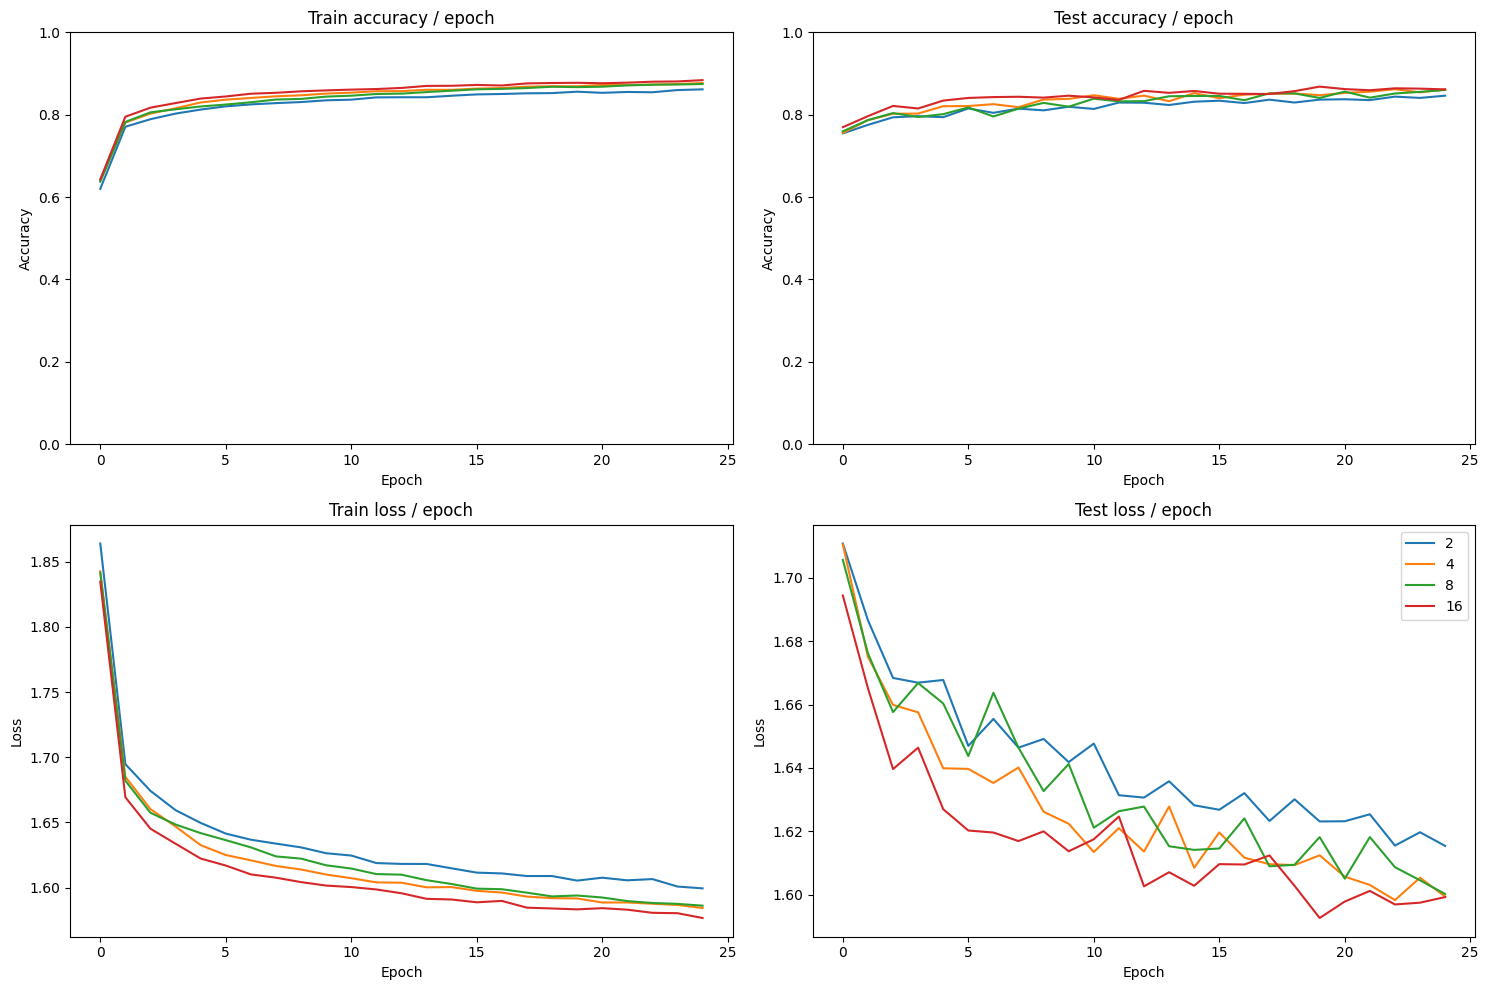

In [24]:
plot_plot_optimizers(plot_optimizers_num_heads, 'num_heads_influence_25')

In [25]:
plot_optimizers_mlp_ratio = {}
for mlp_ratio in [2,4,6,8]:
    stats = main(epochs=25, mlp_ratio=mlp_ratio)
    plot_optimizers_mlp_ratio[mlp_ratio] = stats

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.643 | acc_test 0.768:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.643 | acc_test 0.768:   4%|██▌                                                            | 1/25 [00:06<02:38,  6.62s/it]

acc_train 0.792 | acc_test 0.794:   4%|██▌                                                            | 1/25 [00:13<02:38,  6.62s/it]

acc_train 0.792 | acc_test 0.794:   8%|█████                                                          | 2/25 [00:13<02:30,  6.53s/it]

acc_train 0.807 | acc_test 0.811:   8%|█████                                                          | 2/25 [00:20<02:30,  6.53s/it]

acc_train 0.807 | acc_test 0.811:  12%|███████▌                                                       | 3/25 [00:20<02:28,  6.75s/it]

acc_train 0.819 | acc_test 0.802:  12%|███████▌                                                       | 3/25 [00:27<02:28,  6.75s/it]

acc_train 0.819 | acc_test 0.802:  16%|██████████                                                     | 4/25 [00:27<02:23,  6.82s/it]

acc_train 0.827 | acc_test 0.811:  16%|██████████                                                     | 4/25 [00:33<02:23,  6.82s/it]

acc_train 0.827 | acc_test 0.811:  20%|████████████▌                                                  | 5/25 [00:33<02:16,  6.82s/it]

acc_train 0.834 | acc_test 0.812:  20%|████████████▌                                                  | 5/25 [00:40<02:16,  6.82s/it]

acc_train 0.834 | acc_test 0.812:  24%|███████████████                                                | 6/25 [00:40<02:08,  6.74s/it]

acc_train 0.838 | acc_test 0.828:  24%|███████████████                                                | 6/25 [00:46<02:08,  6.74s/it]

acc_train 0.838 | acc_test 0.828:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.66s/it]

acc_train 0.844 | acc_test 0.837:  28%|█████████████████▋                                             | 7/25 [00:53<01:59,  6.66s/it]

acc_train 0.844 | acc_test 0.837:  32%|████████████████████▏                                          | 8/25 [00:53<01:52,  6.60s/it]

acc_train 0.848 | acc_test 0.837:  32%|████████████████████▏                                          | 8/25 [00:59<01:52,  6.60s/it]

acc_train 0.848 | acc_test 0.837:  36%|██████████████████████▋                                        | 9/25 [00:59<01:44,  6.56s/it]

acc_train 0.851 | acc_test 0.841:  36%|██████████████████████▋                                        | 9/25 [01:06<01:44,  6.56s/it]

acc_train 0.851 | acc_test 0.841:  40%|████████████████████████▊                                     | 10/25 [01:06<01:39,  6.64s/it]

acc_train 0.854 | acc_test 0.843:  40%|████████████████████████▊                                     | 10/25 [01:13<01:39,  6.64s/it]

acc_train 0.854 | acc_test 0.843:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:32,  6.59s/it]

acc_train 0.857 | acc_test 0.842:  44%|███████████████████████████▎                                  | 11/25 [01:19<01:32,  6.59s/it]

acc_train 0.857 | acc_test 0.842:  48%|█████████████████████████████▊                                | 12/25 [01:19<01:25,  6.55s/it]

acc_train 0.858 | acc_test 0.847:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:25,  6.55s/it]

acc_train 0.858 | acc_test 0.847:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:18,  6.53s/it]

acc_train 0.860 | acc_test 0.847:  52%|████████████████████████████████▏                             | 13/25 [01:32<01:18,  6.53s/it]

acc_train 0.860 | acc_test 0.847:  56%|██████████████████████████████████▋                           | 14/25 [01:32<01:11,  6.51s/it]

acc_train 0.861 | acc_test 0.840:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:11,  6.51s/it]

acc_train 0.861 | acc_test 0.840:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:05,  6.50s/it]

acc_train 0.863 | acc_test 0.855:  60%|█████████████████████████████████████▏                        | 15/25 [01:45<01:05,  6.50s/it]

acc_train 0.863 | acc_test 0.855:  64%|███████████████████████████████████████▋                      | 16/25 [01:45<00:58,  6.49s/it]

acc_train 0.866 | acc_test 0.852:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:58,  6.49s/it]

acc_train 0.866 | acc_test 0.852:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:52,  6.50s/it]

acc_train 0.866 | acc_test 0.859:  68%|██████████████████████████████████████████▏                   | 17/25 [01:58<00:52,  6.50s/it]

acc_train 0.866 | acc_test 0.859:  72%|████████████████████████████████████████████▋                 | 18/25 [01:58<00:45,  6.50s/it]

acc_train 0.868 | acc_test 0.854:  72%|████████████████████████████████████████████▋                 | 18/25 [02:05<00:45,  6.50s/it]

acc_train 0.868 | acc_test 0.854:  76%|███████████████████████████████████████████████               | 19/25 [02:05<00:38,  6.50s/it]

acc_train 0.871 | acc_test 0.839:  76%|███████████████████████████████████████████████               | 19/25 [02:11<00:38,  6.50s/it]

acc_train 0.871 | acc_test 0.839:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:11<00:32,  6.58s/it]

acc_train 0.870 | acc_test 0.857:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:18<00:32,  6.58s/it]

acc_train 0.870 | acc_test 0.857:  84%|████████████████████████████████████████████████████          | 21/25 [02:18<00:26,  6.62s/it]

acc_train 0.871 | acc_test 0.862:  84%|████████████████████████████████████████████████████          | 21/25 [02:25<00:26,  6.62s/it]

acc_train 0.871 | acc_test 0.862:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:25<00:19,  6.62s/it]

acc_train 0.873 | acc_test 0.858:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:31<00:19,  6.62s/it]

acc_train 0.873 | acc_test 0.858:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:31<00:13,  6.66s/it]

acc_train 0.873 | acc_test 0.856:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.66s/it]

acc_train 0.873 | acc_test 0.856:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:38<00:06,  6.65s/it]

acc_train 0.876 | acc_test 0.857:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.65s/it]

acc_train 0.876 | acc_test 0.857: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.70s/it]

acc_train 0.876 | acc_test 0.857: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.61s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.646 | acc_test 0.784:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.646 | acc_test 0.784:   4%|██▌                                                            | 1/25 [00:06<02:39,  6.63s/it]

acc_train 0.801 | acc_test 0.797:   4%|██▌                                                            | 1/25 [00:13<02:39,  6.63s/it]

acc_train 0.801 | acc_test 0.797:   8%|█████                                                          | 2/25 [00:13<02:32,  6.63s/it]

acc_train 0.816 | acc_test 0.814:   8%|█████                                                          | 2/25 [00:19<02:32,  6.63s/it]

acc_train 0.816 | acc_test 0.814:  12%|███████▌                                                       | 3/25 [00:19<02:26,  6.66s/it]

acc_train 0.829 | acc_test 0.814:  12%|███████▌                                                       | 3/25 [00:26<02:26,  6.66s/it]

acc_train 0.829 | acc_test 0.814:  16%|██████████                                                     | 4/25 [00:26<02:19,  6.66s/it]

acc_train 0.832 | acc_test 0.823:  16%|██████████                                                     | 4/25 [00:33<02:19,  6.66s/it]

acc_train 0.832 | acc_test 0.823:  20%|████████████▌                                                  | 5/25 [00:33<02:12,  6.60s/it]

acc_train 0.840 | acc_test 0.830:  20%|████████████▌                                                  | 5/25 [00:39<02:12,  6.60s/it]

acc_train 0.840 | acc_test 0.830:  24%|███████████████                                                | 6/25 [00:39<02:04,  6.57s/it]

acc_train 0.848 | acc_test 0.821:  24%|███████████████                                                | 6/25 [00:46<02:04,  6.57s/it]

acc_train 0.848 | acc_test 0.821:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.62s/it]

acc_train 0.849 | acc_test 0.838:  28%|█████████████████▋                                             | 7/25 [00:52<01:59,  6.62s/it]

acc_train 0.849 | acc_test 0.838:  32%|████████████████████▏                                          | 8/25 [00:52<01:51,  6.58s/it]

acc_train 0.853 | acc_test 0.838:  32%|████████████████████▏                                          | 8/25 [00:59<01:51,  6.58s/it]

acc_train 0.853 | acc_test 0.838:  36%|██████████████████████▋                                        | 9/25 [00:59<01:46,  6.67s/it]

acc_train 0.856 | acc_test 0.838:  36%|██████████████████████▋                                        | 9/25 [01:06<01:46,  6.67s/it]

acc_train 0.856 | acc_test 0.838:  40%|████████████████████████▊                                     | 10/25 [01:06<01:39,  6.65s/it]

acc_train 0.860 | acc_test 0.841:  40%|████████████████████████▊                                     | 10/25 [01:13<01:39,  6.65s/it]

acc_train 0.860 | acc_test 0.841:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:34,  6.72s/it]

acc_train 0.861 | acc_test 0.843:  44%|███████████████████████████▎                                  | 11/25 [01:19<01:34,  6.72s/it]

acc_train 0.861 | acc_test 0.843:  48%|█████████████████████████████▊                                | 12/25 [01:19<01:26,  6.68s/it]

acc_train 0.864 | acc_test 0.852:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:26,  6.68s/it]

acc_train 0.864 | acc_test 0.852:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:19,  6.65s/it]

acc_train 0.863 | acc_test 0.845:  52%|████████████████████████████████▏                             | 13/25 [01:32<01:19,  6.65s/it]

acc_train 0.863 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [01:32<01:13,  6.64s/it]

acc_train 0.865 | acc_test 0.845:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:13,  6.64s/it]

acc_train 0.865 | acc_test 0.845:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:06,  6.63s/it]

acc_train 0.866 | acc_test 0.844:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:06,  6.63s/it]

acc_train 0.866 | acc_test 0.844:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:59,  6.64s/it]

acc_train 0.870 | acc_test 0.846:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:59,  6.64s/it]

acc_train 0.870 | acc_test 0.846:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:53,  6.64s/it]

acc_train 0.870 | acc_test 0.852:  68%|██████████████████████████████████████████▏                   | 17/25 [01:59<00:53,  6.64s/it]

acc_train 0.870 | acc_test 0.852:  72%|████████████████████████████████████████████▋                 | 18/25 [01:59<00:46,  6.63s/it]

acc_train 0.871 | acc_test 0.846:  72%|████████████████████████████████████████████▋                 | 18/25 [02:06<00:46,  6.63s/it]

acc_train 0.871 | acc_test 0.846:  76%|███████████████████████████████████████████████               | 19/25 [02:06<00:40,  6.68s/it]

acc_train 0.873 | acc_test 0.855:  76%|███████████████████████████████████████████████               | 19/25 [02:13<00:40,  6.68s/it]

acc_train 0.873 | acc_test 0.855:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:13<00:33,  6.69s/it]

acc_train 0.875 | acc_test 0.857:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:19<00:33,  6.69s/it]

acc_train 0.875 | acc_test 0.857:  84%|████████████████████████████████████████████████████          | 21/25 [02:19<00:26,  6.75s/it]

acc_train 0.873 | acc_test 0.856:  84%|████████████████████████████████████████████████████          | 21/25 [02:26<00:26,  6.75s/it]

acc_train 0.873 | acc_test 0.856:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:26<00:20,  6.67s/it]

acc_train 0.875 | acc_test 0.855:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:32<00:20,  6.67s/it]

acc_train 0.875 | acc_test 0.855:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:32<00:13,  6.62s/it]

acc_train 0.878 | acc_test 0.858:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:39<00:13,  6.62s/it]

acc_train 0.878 | acc_test 0.858:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:39<00:06,  6.63s/it]

acc_train 0.878 | acc_test 0.858:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:46<00:06,  6.63s/it]

acc_train 0.878 | acc_test 0.858: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.61s/it]

acc_train 0.878 | acc_test 0.858: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:46<00:00,  6.64s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.638 | acc_test 0.764:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.638 | acc_test 0.764:   4%|██▌                                                            | 1/25 [00:06<02:36,  6.50s/it]

acc_train 0.787 | acc_test 0.795:   4%|██▌                                                            | 1/25 [00:13<02:36,  6.50s/it]

acc_train 0.787 | acc_test 0.795:   8%|█████                                                          | 2/25 [00:13<02:33,  6.69s/it]

acc_train 0.807 | acc_test 0.796:   8%|█████                                                          | 2/25 [00:19<02:33,  6.69s/it]

acc_train 0.807 | acc_test 0.796:  12%|███████▌                                                       | 3/25 [00:19<02:26,  6.65s/it]

acc_train 0.818 | acc_test 0.811:  12%|███████▌                                                       | 3/25 [00:26<02:26,  6.65s/it]

acc_train 0.818 | acc_test 0.811:  16%|██████████                                                     | 4/25 [00:26<02:19,  6.64s/it]

acc_train 0.824 | acc_test 0.819:  16%|██████████                                                     | 4/25 [00:33<02:19,  6.64s/it]

acc_train 0.824 | acc_test 0.819:  20%|████████████▌                                                  | 5/25 [00:33<02:13,  6.66s/it]

acc_train 0.832 | acc_test 0.826:  20%|████████████▌                                                  | 5/25 [00:39<02:13,  6.66s/it]

acc_train 0.832 | acc_test 0.826:  24%|███████████████                                                | 6/25 [00:39<02:05,  6.59s/it]

acc_train 0.835 | acc_test 0.827:  24%|███████████████                                                | 6/25 [00:46<02:05,  6.59s/it]

acc_train 0.835 | acc_test 0.827:  28%|█████████████████▋                                             | 7/25 [00:46<02:00,  6.69s/it]

acc_train 0.841 | acc_test 0.831:  28%|█████████████████▋                                             | 7/25 [00:53<02:00,  6.69s/it]

acc_train 0.841 | acc_test 0.831:  32%|████████████████████▏                                          | 8/25 [00:53<01:54,  6.74s/it]

acc_train 0.844 | acc_test 0.828:  32%|████████████████████▏                                          | 8/25 [01:00<01:54,  6.74s/it]

acc_train 0.844 | acc_test 0.828:  36%|██████████████████████▋                                        | 9/25 [01:00<01:48,  6.80s/it]

acc_train 0.847 | acc_test 0.838:  36%|██████████████████████▋                                        | 9/25 [01:07<01:48,  6.80s/it]

acc_train 0.847 | acc_test 0.838:  40%|████████████████████████▊                                     | 10/25 [01:07<01:42,  6.81s/it]

acc_train 0.848 | acc_test 0.831:  40%|████████████████████████▊                                     | 10/25 [01:13<01:42,  6.81s/it]

acc_train 0.848 | acc_test 0.831:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:35,  6.79s/it]

acc_train 0.851 | acc_test 0.838:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:35,  6.79s/it]

acc_train 0.851 | acc_test 0.838:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:27,  6.70s/it]

acc_train 0.854 | acc_test 0.836:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:27,  6.70s/it]

acc_train 0.854 | acc_test 0.836:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:20,  6.68s/it]

acc_train 0.855 | acc_test 0.843:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:20,  6.68s/it]

acc_train 0.855 | acc_test 0.843:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:12,  6.63s/it]

acc_train 0.858 | acc_test 0.847:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:12,  6.63s/it]

acc_train 0.858 | acc_test 0.847:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:06,  6.64s/it]

acc_train 0.862 | acc_test 0.846:  60%|█████████████████████████████████████▏                        | 15/25 [01:46<01:06,  6.64s/it]

acc_train 0.862 | acc_test 0.846:  64%|███████████████████████████████████████▋                      | 16/25 [01:46<00:59,  6.65s/it]

acc_train 0.864 | acc_test 0.850:  64%|███████████████████████████████████████▋                      | 16/25 [01:53<00:59,  6.65s/it]

acc_train 0.864 | acc_test 0.850:  68%|██████████████████████████████████████████▏                   | 17/25 [01:53<00:53,  6.74s/it]

acc_train 0.864 | acc_test 0.840:  68%|██████████████████████████████████████████▏                   | 17/25 [02:00<00:53,  6.74s/it]

acc_train 0.864 | acc_test 0.840:  72%|████████████████████████████████████████████▋                 | 18/25 [02:00<00:46,  6.70s/it]

acc_train 0.864 | acc_test 0.850:  72%|████████████████████████████████████████████▋                 | 18/25 [02:07<00:46,  6.70s/it]

acc_train 0.864 | acc_test 0.850:  76%|███████████████████████████████████████████████               | 19/25 [02:07<00:40,  6.67s/it]

acc_train 0.867 | acc_test 0.838:  76%|███████████████████████████████████████████████               | 19/25 [02:13<00:40,  6.67s/it]

acc_train 0.867 | acc_test 0.838:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:13<00:33,  6.65s/it]

acc_train 0.866 | acc_test 0.846:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:20<00:33,  6.65s/it]

acc_train 0.866 | acc_test 0.846:  84%|████████████████████████████████████████████████████          | 21/25 [02:20<00:26,  6.68s/it]

acc_train 0.866 | acc_test 0.850:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:26,  6.68s/it]

acc_train 0.866 | acc_test 0.850:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:19,  6.66s/it]

acc_train 0.871 | acc_test 0.855:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:33<00:19,  6.66s/it]

acc_train 0.871 | acc_test 0.855:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:33<00:13,  6.73s/it]

acc_train 0.873 | acc_test 0.860:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:40<00:13,  6.73s/it]

acc_train 0.873 | acc_test 0.860:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.73s/it]

acc_train 0.874 | acc_test 0.860:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:47<00:06,  6.73s/it]

acc_train 0.874 | acc_test 0.860: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.65s/it]

acc_train 0.874 | acc_test 0.860: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.69s/it]

  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]

acc_train 0.660 | acc_test 0.769:   0%|                                                                       | 0/25 [00:06<?, ?it/s]

acc_train 0.660 | acc_test 0.769:   4%|██▌                                                            | 1/25 [00:06<02:35,  6.49s/it]

acc_train 0.795 | acc_test 0.802:   4%|██▌                                                            | 1/25 [00:13<02:35,  6.49s/it]

acc_train 0.795 | acc_test 0.802:   8%|█████                                                          | 2/25 [00:13<02:30,  6.56s/it]

acc_train 0.815 | acc_test 0.811:   8%|█████                                                          | 2/25 [00:19<02:30,  6.56s/it]

acc_train 0.815 | acc_test 0.811:  12%|███████▌                                                       | 3/25 [00:19<02:23,  6.52s/it]

acc_train 0.824 | acc_test 0.819:  12%|███████▌                                                       | 3/25 [00:26<02:23,  6.52s/it]

acc_train 0.824 | acc_test 0.819:  16%|██████████                                                     | 4/25 [00:26<02:18,  6.58s/it]

acc_train 0.833 | acc_test 0.832:  16%|██████████                                                     | 4/25 [00:33<02:18,  6.58s/it]

acc_train 0.833 | acc_test 0.832:  20%|████████████▌                                                  | 5/25 [00:33<02:13,  6.66s/it]

acc_train 0.841 | acc_test 0.827:  20%|████████████▌                                                  | 5/25 [00:39<02:13,  6.66s/it]

acc_train 0.841 | acc_test 0.827:  24%|███████████████                                                | 6/25 [00:39<02:06,  6.68s/it]

acc_train 0.841 | acc_test 0.838:  24%|███████████████                                                | 6/25 [00:46<02:06,  6.68s/it]

acc_train 0.841 | acc_test 0.838:  28%|█████████████████▋                                             | 7/25 [00:46<02:01,  6.73s/it]

acc_train 0.846 | acc_test 0.840:  28%|█████████████████▋                                             | 7/25 [00:53<02:01,  6.73s/it]

acc_train 0.846 | acc_test 0.840:  32%|████████████████████▏                                          | 8/25 [00:53<01:53,  6.70s/it]

acc_train 0.849 | acc_test 0.839:  32%|████████████████████▏                                          | 8/25 [01:00<01:53,  6.70s/it]

acc_train 0.849 | acc_test 0.839:  36%|██████████████████████▋                                        | 9/25 [01:00<01:48,  6.75s/it]

acc_train 0.850 | acc_test 0.843:  36%|██████████████████████▋                                        | 9/25 [01:06<01:48,  6.75s/it]

acc_train 0.850 | acc_test 0.843:  40%|████████████████████████▊                                     | 10/25 [01:06<01:41,  6.74s/it]

acc_train 0.854 | acc_test 0.845:  40%|████████████████████████▊                                     | 10/25 [01:13<01:41,  6.74s/it]

acc_train 0.854 | acc_test 0.845:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:34,  6.74s/it]

acc_train 0.855 | acc_test 0.829:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:34,  6.74s/it]

acc_train 0.855 | acc_test 0.829:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:27,  6.77s/it]

acc_train 0.858 | acc_test 0.838:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:27,  6.77s/it]

acc_train 0.858 | acc_test 0.838:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:20,  6.73s/it]

acc_train 0.859 | acc_test 0.842:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:20,  6.73s/it]

acc_train 0.859 | acc_test 0.842:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:13,  6.70s/it]

acc_train 0.860 | acc_test 0.847:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:13,  6.70s/it]

acc_train 0.860 | acc_test 0.847:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:06,  6.68s/it]

acc_train 0.862 | acc_test 0.847:  60%|█████████████████████████████████████▏                        | 15/25 [01:47<01:06,  6.68s/it]

acc_train 0.862 | acc_test 0.847:  64%|███████████████████████████████████████▋                      | 16/25 [01:47<01:00,  6.75s/it]

acc_train 0.863 | acc_test 0.846:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.75s/it]

acc_train 0.863 | acc_test 0.846:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:54,  6.80s/it]

acc_train 0.868 | acc_test 0.849:  68%|██████████████████████████████████████████▏                   | 17/25 [02:01<00:54,  6.80s/it]

acc_train 0.868 | acc_test 0.849:  72%|████████████████████████████████████████████▋                 | 18/25 [02:01<00:47,  6.84s/it]

acc_train 0.864 | acc_test 0.848:  72%|████████████████████████████████████████████▋                 | 18/25 [02:07<00:47,  6.84s/it]

acc_train 0.864 | acc_test 0.848:  76%|███████████████████████████████████████████████               | 19/25 [02:07<00:40,  6.79s/it]

acc_train 0.869 | acc_test 0.853:  76%|███████████████████████████████████████████████               | 19/25 [02:14<00:40,  6.79s/it]

acc_train 0.869 | acc_test 0.853:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:14<00:33,  6.76s/it]

acc_train 0.872 | acc_test 0.858:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:21<00:33,  6.76s/it]

acc_train 0.872 | acc_test 0.858:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:27,  6.76s/it]

acc_train 0.871 | acc_test 0.855:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:27,  6.76s/it]

acc_train 0.871 | acc_test 0.855:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:20,  6.67s/it]

acc_train 0.873 | acc_test 0.856:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:34<00:20,  6.67s/it]

acc_train 0.873 | acc_test 0.856:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:13,  6.65s/it]

acc_train 0.875 | acc_test 0.860:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:40<00:13,  6.65s/it]

acc_train 0.875 | acc_test 0.860:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.63s/it]

acc_train 0.875 | acc_test 0.856:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:47<00:06,  6.63s/it]

acc_train 0.875 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.67s/it]

acc_train 0.875 | acc_test 0.856: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.70s/it]

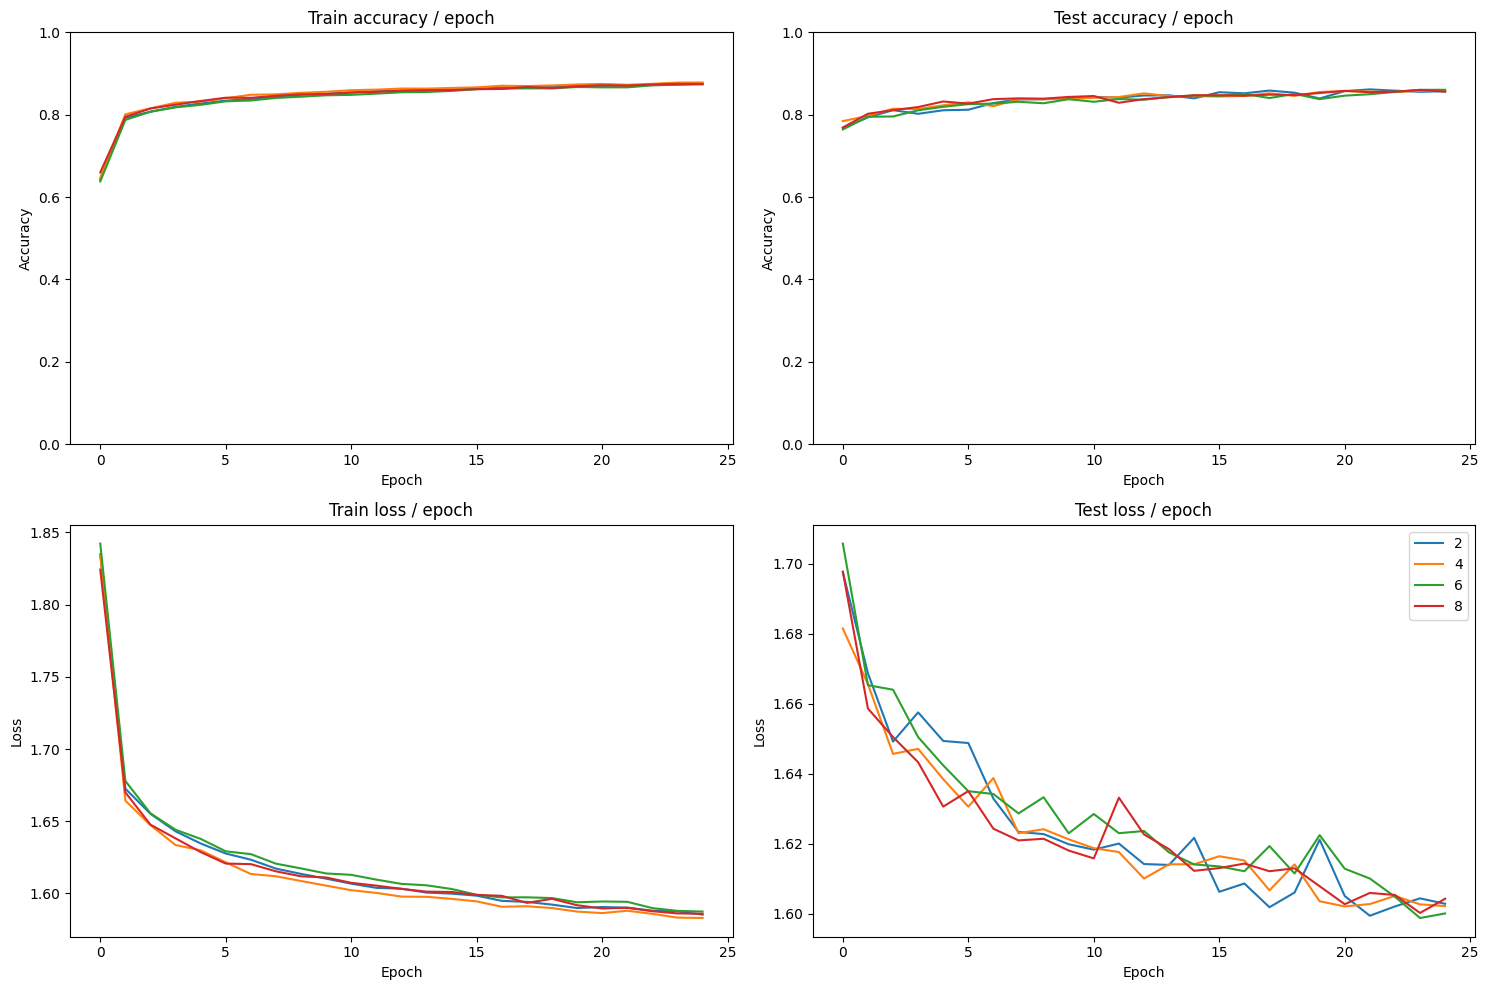

In [26]:
plot_plot_optimizers(plot_optimizers_mlp_ratio, 'mlp_ratio_influence_25')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [27]:
%pip install timm > /dev/null

Note: you may need to restart the kernel to use updated packages.


a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [28]:
import timm
# [k for k in timm.list_models() if 'vit_base' in k]

In [29]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(1, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


The model vit_base_patch16_224 is trained on 224x224 images from the ImageNet dataset. In the first layer of the ViT, the input image is divided into fixed-size patches to create embedded vectors. It's crucial to maintain the same image size as the one the model was designed for. 

In this case, it necessitates resizing the images to 224x224 RGB pixels. However, this may not be ideal as resizing could distort the images and potentially affect the model's performance.

In [30]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 8, 8) # adapt number of channels to fit in ViT 
# by coping the image and not resizing yet (see next cell)
display(x.size())
model(x).shape

torch.Size([32, 3, 224, 224])

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [31]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
data_cfg # figure out which transformations were used for a given pretrained model

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [32]:
transform = timm.data.create_transform(**data_cfg)
transform_rgb = lambda x: transform(x.convert('RGB'))

In [33]:
model.cuda()
train_dataset = torchvision.datasets.FashionMNIST('.', train=True, download=True, transform=transform_rgb)
test_dataset = torchvision.datasets.FashionMNIST('.', train=False, download=True, transform=transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64)

c) redo the training with the pretrained ViT-S




In [34]:
stats_vit = main(model=model, epochs=15, tqdm_batch=True)

  0%|                                                                                                        | 0/938 [00:00<?, ?it/s]

  0%|                                                                                                         | 0/15 [00:00<?, ?it/s]

  0%|                                                                                                | 1/938 [00:00<08:59,  1.74it/s]

  0%|▏                                                                                               | 2/938 [00:01<08:49,  1.77it/s]

  0%|▎                                                                                               | 3/938 [00:01<08:46,  1.78it/s]

  0%|▍                                                                                               | 4/938 [00:02<08:43,  1.78it/s]

  1%|▌                                                                                               | 5/938 [00:02<08:42,  1.79it/s]

  1%|▌                                                                                               | 6/938 [00:03<08:40,  1.79it/s]

  1%|▋                                                                                               | 7/938 [00:03<08:39,  1.79it/s]

  1%|▊                                                                                               | 8/938 [00:04<08:38,  1.79it/s]

  1%|▉                                                                                               | 9/938 [00:05<08:38,  1.79it/s]

  1%|█                                                                                              | 10/938 [00:05<08:37,  1.79it/s]

  1%|█                                                                                              | 11/938 [00:06<08:37,  1.79it/s]

  1%|█▏                                                                                             | 12/938 [00:06<08:32,  1.81it/s]

  1%|█▎                                                                                             | 13/938 [00:07<08:29,  1.82it/s]

  1%|█▍                                                                                             | 14/938 [00:07<08:27,  1.82it/s]

  2%|█▌                                                                                             | 15/938 [00:08<08:26,  1.82it/s]

  2%|█▌                                                                                             | 16/938 [00:08<08:24,  1.83it/s]

  2%|█▋                                                                                             | 17/938 [00:09<08:23,  1.83it/s]

  2%|█▊                                                                                             | 18/938 [00:09<08:23,  1.83it/s]

  2%|█▉                                                                                             | 19/938 [00:10<08:22,  1.83it/s]

  2%|██                                                                                             | 20/938 [00:11<08:22,  1.83it/s]

  2%|██▏                                                                                            | 21/938 [00:11<08:24,  1.82it/s]

  2%|██▏                                                                                            | 22/938 [00:12<08:23,  1.82it/s]

  2%|██▎                                                                                            | 23/938 [00:12<08:21,  1.82it/s]

  3%|██▍                                                                                            | 24/938 [00:13<08:20,  1.83it/s]

  3%|██▌                                                                                            | 25/938 [00:13<08:20,  1.83it/s]

  3%|██▋                                                                                            | 26/938 [00:14<08:19,  1.83it/s]

  3%|██▋                                                                                            | 27/938 [00:14<08:19,  1.83it/s]

  3%|██▊                                                                                            | 28/938 [00:15<08:19,  1.82it/s]

  3%|██▉                                                                                            | 29/938 [00:16<08:18,  1.82it/s]

  3%|███                                                                                            | 30/938 [00:16<08:18,  1.82it/s]

  3%|███▏                                                                                           | 31/938 [00:17<08:18,  1.82it/s]

  3%|███▏                                                                                           | 32/938 [00:17<08:17,  1.82it/s]

  4%|███▎                                                                                           | 33/938 [00:18<08:16,  1.82it/s]

  4%|███▍                                                                                           | 34/938 [00:18<08:15,  1.82it/s]

  4%|███▌                                                                                           | 35/938 [00:19<08:15,  1.82it/s]

  4%|███▋                                                                                           | 36/938 [00:19<08:14,  1.82it/s]

  4%|███▋                                                                                           | 37/938 [00:20<08:14,  1.82it/s]

  4%|███▊                                                                                           | 38/938 [00:20<08:13,  1.82it/s]

  4%|███▉                                                                                           | 39/938 [00:21<08:13,  1.82it/s]

  4%|████                                                                                           | 40/938 [00:22<08:12,  1.82it/s]

  4%|████▏                                                                                          | 41/938 [00:22<08:13,  1.82it/s]

  4%|████▎                                                                                          | 42/938 [00:23<08:12,  1.82it/s]

  5%|████▎                                                                                          | 43/938 [00:23<08:11,  1.82it/s]

  5%|████▍                                                                                          | 44/938 [00:24<08:10,  1.82it/s]

  5%|████▌                                                                                          | 45/938 [00:24<08:10,  1.82it/s]

  5%|████▋                                                                                          | 46/938 [00:25<08:09,  1.82it/s]

  5%|████▊                                                                                          | 47/938 [00:25<08:09,  1.82it/s]

  5%|████▊                                                                                          | 48/938 [00:26<08:09,  1.82it/s]

  5%|████▉                                                                                          | 49/938 [00:26<08:08,  1.82it/s]

  5%|█████                                                                                          | 50/938 [00:27<08:08,  1.82it/s]

  5%|█████▏                                                                                         | 51/938 [00:28<08:10,  1.81it/s]

  6%|█████▎                                                                                         | 52/938 [00:28<08:09,  1.81it/s]

  6%|█████▎                                                                                         | 53/938 [00:29<08:08,  1.81it/s]

  6%|█████▍                                                                                         | 54/938 [00:29<08:07,  1.81it/s]

  6%|█████▌                                                                                         | 55/938 [00:30<08:06,  1.82it/s]

  6%|█████▋                                                                                         | 56/938 [00:30<08:05,  1.82it/s]

  6%|█████▊                                                                                         | 57/938 [00:31<08:05,  1.81it/s]

  6%|█████▊                                                                                         | 58/938 [00:31<08:04,  1.82it/s]

  6%|█████▉                                                                                         | 59/938 [00:32<08:04,  1.81it/s]

  6%|██████                                                                                         | 60/938 [00:33<08:03,  1.82it/s]

  7%|██████▏                                                                                        | 61/938 [00:33<08:03,  1.81it/s]

  7%|██████▎                                                                                        | 62/938 [00:34<08:02,  1.81it/s]

  7%|██████▍                                                                                        | 63/938 [00:34<08:02,  1.81it/s]

  7%|██████▍                                                                                        | 64/938 [00:35<08:02,  1.81it/s]

  7%|██████▌                                                                                        | 65/938 [00:35<08:01,  1.81it/s]

  7%|██████▋                                                                                        | 66/938 [00:36<08:00,  1.81it/s]

  7%|██████▊                                                                                        | 67/938 [00:36<08:00,  1.81it/s]

  7%|██████▉                                                                                        | 68/938 [00:37<08:00,  1.81it/s]

  7%|██████▉                                                                                        | 69/938 [00:38<07:59,  1.81it/s]

  7%|███████                                                                                        | 70/938 [00:38<07:58,  1.81it/s]

  8%|███████▏                                                                                       | 71/938 [00:39<07:58,  1.81it/s]

  8%|███████▎                                                                                       | 72/938 [00:39<07:57,  1.81it/s]

  8%|███████▍                                                                                       | 73/938 [00:40<07:57,  1.81it/s]

  8%|███████▍                                                                                       | 74/938 [00:40<07:57,  1.81it/s]

  8%|███████▌                                                                                       | 75/938 [00:41<07:56,  1.81it/s]

  8%|███████▋                                                                                       | 76/938 [00:41<07:56,  1.81it/s]

  8%|███████▊                                                                                       | 77/938 [00:42<07:56,  1.81it/s]

  8%|███████▉                                                                                       | 78/938 [00:42<07:55,  1.81it/s]

  8%|████████                                                                                       | 79/938 [00:43<07:55,  1.81it/s]

  9%|████████                                                                                       | 80/938 [00:44<07:54,  1.81it/s]

  9%|████████▏                                                                                      | 81/938 [00:44<07:53,  1.81it/s]

  9%|████████▎                                                                                      | 82/938 [00:45<07:53,  1.81it/s]

  9%|████████▍                                                                                      | 83/938 [00:45<07:53,  1.81it/s]

  9%|████████▌                                                                                      | 84/938 [00:46<07:52,  1.81it/s]

  9%|████████▌                                                                                      | 85/938 [00:46<07:52,  1.81it/s]

  9%|████████▋                                                                                      | 86/938 [00:47<07:51,  1.81it/s]

  9%|████████▊                                                                                      | 87/938 [00:47<07:50,  1.81it/s]

  9%|████████▉                                                                                      | 88/938 [00:48<07:50,  1.81it/s]

  9%|█████████                                                                                      | 89/938 [00:49<07:49,  1.81it/s]

 10%|█████████                                                                                      | 90/938 [00:49<07:49,  1.81it/s]

 10%|█████████▏                                                                                     | 91/938 [00:50<07:48,  1.81it/s]

 10%|█████████▎                                                                                     | 92/938 [00:50<07:48,  1.81it/s]

 10%|█████████▍                                                                                     | 93/938 [00:51<07:47,  1.81it/s]

 10%|█████████▌                                                                                     | 94/938 [00:51<07:46,  1.81it/s]

 10%|█████████▌                                                                                     | 95/938 [00:52<07:46,  1.81it/s]

 10%|█████████▋                                                                                     | 96/938 [00:52<07:46,  1.81it/s]

 10%|█████████▊                                                                                     | 97/938 [00:53<07:45,  1.81it/s]

 10%|█████████▉                                                                                     | 98/938 [00:54<07:45,  1.80it/s]

 11%|██████████                                                                                     | 99/938 [00:54<07:44,  1.80it/s]

 11%|██████████                                                                                    | 100/938 [00:55<07:44,  1.81it/s]

 11%|██████████                                                                                    | 101/938 [00:55<07:43,  1.81it/s]

 11%|██████████▏                                                                                   | 102/938 [00:56<07:42,  1.81it/s]

 11%|██████████▎                                                                                   | 103/938 [00:56<07:43,  1.80it/s]

 11%|██████████▍                                                                                   | 104/938 [00:57<07:42,  1.80it/s]

 11%|██████████▌                                                                                   | 105/938 [00:57<07:41,  1.80it/s]

 11%|██████████▌                                                                                   | 106/938 [00:58<07:41,  1.80it/s]

 11%|██████████▋                                                                                   | 107/938 [00:59<07:40,  1.81it/s]

 12%|██████████▊                                                                                   | 108/938 [00:59<07:39,  1.81it/s]

 12%|██████████▉                                                                                   | 109/938 [01:00<07:39,  1.81it/s]

 12%|███████████                                                                                   | 110/938 [01:00<07:38,  1.81it/s]

 12%|███████████                                                                                   | 111/938 [01:01<07:37,  1.81it/s]

 12%|███████████▏                                                                                  | 112/938 [01:01<07:37,  1.81it/s]

 12%|███████████▎                                                                                  | 113/938 [01:02<07:37,  1.80it/s]

 12%|███████████▍                                                                                  | 114/938 [01:02<07:36,  1.80it/s]

 12%|███████████▌                                                                                  | 115/938 [01:03<07:35,  1.80it/s]

 12%|███████████▌                                                                                  | 116/938 [01:04<07:35,  1.81it/s]

 12%|███████████▋                                                                                  | 117/938 [01:04<07:35,  1.80it/s]

 13%|███████████▊                                                                                  | 118/938 [01:05<07:34,  1.80it/s]

 13%|███████████▉                                                                                  | 119/938 [01:05<07:34,  1.80it/s]

 13%|████████████                                                                                  | 120/938 [01:06<07:33,  1.80it/s]

 13%|████████████▏                                                                                 | 121/938 [01:06<07:32,  1.80it/s]

 13%|████████████▏                                                                                 | 122/938 [01:07<07:32,  1.80it/s]

 13%|████████████▎                                                                                 | 123/938 [01:07<07:31,  1.80it/s]

 13%|████████████▍                                                                                 | 124/938 [01:08<07:31,  1.80it/s]

 13%|████████████▌                                                                                 | 125/938 [01:09<07:37,  1.78it/s]

 13%|████████████▋                                                                                 | 126/938 [01:09<07:35,  1.78it/s]

 14%|████████████▋                                                                                 | 127/938 [01:10<07:33,  1.79it/s]

 14%|████████████▊                                                                                 | 128/938 [01:10<07:31,  1.79it/s]

 14%|████████████▉                                                                                 | 129/938 [01:11<07:31,  1.79it/s]

 14%|█████████████                                                                                 | 130/938 [01:11<07:30,  1.79it/s]

 14%|█████████████▏                                                                                | 131/938 [01:12<07:29,  1.79it/s]

 14%|█████████████▏                                                                                | 132/938 [01:12<07:28,  1.80it/s]

 14%|█████████████▎                                                                                | 133/938 [01:13<07:27,  1.80it/s]

 14%|█████████████▍                                                                                | 134/938 [01:14<07:26,  1.80it/s]

 14%|█████████████▌                                                                                | 135/938 [01:14<07:26,  1.80it/s]

 14%|█████████████▋                                                                                | 136/938 [01:15<07:27,  1.79it/s]

 15%|█████████████▋                                                                                | 137/938 [01:15<07:26,  1.79it/s]

 15%|█████████████▊                                                                                | 138/938 [01:16<07:25,  1.80it/s]

 15%|█████████████▉                                                                                | 139/938 [01:16<07:24,  1.80it/s]

 15%|██████████████                                                                                | 140/938 [01:17<07:23,  1.80it/s]

 15%|██████████████▏                                                                               | 141/938 [01:17<07:23,  1.80it/s]

 15%|██████████████▏                                                                               | 142/938 [01:18<07:22,  1.80it/s]

 15%|██████████████▎                                                                               | 143/938 [01:19<07:21,  1.80it/s]

 15%|██████████████▍                                                                               | 144/938 [01:19<07:24,  1.79it/s]

 15%|██████████████▌                                                                               | 145/938 [01:20<07:26,  1.78it/s]

 16%|██████████████▋                                                                               | 146/938 [01:20<07:28,  1.77it/s]

 16%|██████████████▋                                                                               | 147/938 [01:21<07:28,  1.76it/s]

 16%|██████████████▊                                                                               | 148/938 [01:21<07:24,  1.78it/s]

 16%|██████████████▉                                                                               | 149/938 [01:22<07:22,  1.78it/s]

 16%|███████████████                                                                               | 150/938 [01:23<07:20,  1.79it/s]

 16%|███████████████▏                                                                              | 151/938 [01:23<07:19,  1.79it/s]

 16%|███████████████▏                                                                              | 152/938 [01:24<07:18,  1.79it/s]

 16%|███████████████▎                                                                              | 153/938 [01:24<07:17,  1.79it/s]

 16%|███████████████▍                                                                              | 154/938 [01:25<07:16,  1.80it/s]

 17%|███████████████▌                                                                              | 155/938 [01:25<07:16,  1.79it/s]

 17%|███████████████▋                                                                              | 156/938 [01:26<07:15,  1.79it/s]

 17%|███████████████▋                                                                              | 157/938 [01:26<07:15,  1.80it/s]

 17%|███████████████▊                                                                              | 158/938 [01:27<07:13,  1.80it/s]

 17%|███████████████▉                                                                              | 159/938 [01:28<07:13,  1.80it/s]

 17%|████████████████                                                                              | 160/938 [01:28<07:12,  1.80it/s]

 17%|████████████████▏                                                                             | 161/938 [01:29<07:16,  1.78it/s]

 17%|████████████████▏                                                                             | 162/938 [01:29<07:14,  1.79it/s]

 17%|████████████████▎                                                                             | 163/938 [01:30<07:12,  1.79it/s]

 17%|████████████████▍                                                                             | 164/938 [01:30<07:11,  1.79it/s]

 18%|████████████████▌                                                                             | 165/938 [01:31<07:10,  1.79it/s]

 18%|████████████████▋                                                                             | 166/938 [01:31<07:09,  1.80it/s]

 18%|████████████████▋                                                                             | 167/938 [01:32<07:09,  1.79it/s]

 18%|████████████████▊                                                                             | 168/938 [01:33<07:09,  1.79it/s]

 18%|████████████████▉                                                                             | 169/938 [01:33<07:19,  1.75it/s]

 18%|█████████████████                                                                             | 170/938 [01:34<07:15,  1.76it/s]

 18%|█████████████████▏                                                                            | 171/938 [01:34<07:12,  1.77it/s]

 18%|█████████████████▏                                                                            | 172/938 [01:35<07:10,  1.78it/s]

 18%|█████████████████▎                                                                            | 173/938 [01:35<07:08,  1.78it/s]

 19%|█████████████████▍                                                                            | 174/938 [01:36<07:07,  1.79it/s]

 19%|█████████████████▌                                                                            | 175/938 [01:36<07:06,  1.79it/s]

 19%|█████████████████▋                                                                            | 176/938 [01:37<07:05,  1.79it/s]

 19%|█████████████████▋                                                                            | 177/938 [01:38<07:04,  1.79it/s]

 19%|█████████████████▊                                                                            | 178/938 [01:38<07:04,  1.79it/s]

 19%|█████████████████▉                                                                            | 179/938 [01:39<07:03,  1.79it/s]

 19%|██████████████████                                                                            | 180/938 [01:39<07:02,  1.79it/s]

 19%|██████████████████▏                                                                           | 181/938 [01:40<07:01,  1.79it/s]

 19%|██████████████████▏                                                                           | 182/938 [01:40<07:01,  1.79it/s]

 20%|██████████████████▎                                                                           | 183/938 [01:41<07:00,  1.80it/s]

 20%|██████████████████▍                                                                           | 184/938 [01:42<07:03,  1.78it/s]

 20%|██████████████████▌                                                                           | 185/938 [01:42<07:01,  1.79it/s]

 20%|██████████████████▋                                                                           | 186/938 [01:43<07:00,  1.79it/s]

 20%|██████████████████▋                                                                           | 187/938 [01:43<06:59,  1.79it/s]

 20%|██████████████████▊                                                                           | 188/938 [01:44<06:58,  1.79it/s]

 20%|██████████████████▉                                                                           | 189/938 [01:44<06:57,  1.80it/s]

 20%|███████████████████                                                                           | 190/938 [01:45<06:56,  1.80it/s]

 20%|███████████████████▏                                                                          | 191/938 [01:45<06:55,  1.80it/s]

 20%|███████████████████▏                                                                          | 192/938 [01:46<06:54,  1.80it/s]

 21%|███████████████████▎                                                                          | 193/938 [01:47<06:55,  1.79it/s]

 21%|███████████████████▍                                                                          | 194/938 [01:47<06:54,  1.79it/s]

 21%|███████████████████▌                                                                          | 195/938 [01:48<06:53,  1.79it/s]

 21%|███████████████████▋                                                                          | 196/938 [01:48<06:53,  1.80it/s]

 21%|███████████████████▋                                                                          | 197/938 [01:49<06:52,  1.80it/s]

 21%|███████████████████▊                                                                          | 198/938 [01:49<06:52,  1.80it/s]

 21%|███████████████████▉                                                                          | 199/938 [01:50<06:51,  1.80it/s]

 21%|████████████████████                                                                          | 200/938 [01:50<06:51,  1.80it/s]

 21%|████████████████████▏                                                                         | 201/938 [01:51<06:50,  1.80it/s]

 22%|████████████████████▏                                                                         | 202/938 [01:52<06:49,  1.80it/s]

 22%|████████████████████▎                                                                         | 203/938 [01:52<06:49,  1.80it/s]

 22%|████████████████████▍                                                                         | 204/938 [01:53<06:48,  1.80it/s]

 22%|████████████████████▌                                                                         | 205/938 [01:53<06:48,  1.80it/s]

 22%|████████████████████▋                                                                         | 206/938 [01:54<06:47,  1.80it/s]

 22%|████████████████████▋                                                                         | 207/938 [01:54<06:47,  1.80it/s]

 22%|████████████████████▊                                                                         | 208/938 [01:55<06:46,  1.80it/s]

 22%|████████████████████▉                                                                         | 209/938 [01:55<06:45,  1.80it/s]

 22%|█████████████████████                                                                         | 210/938 [01:56<06:45,  1.80it/s]

 22%|█████████████████████▏                                                                        | 211/938 [01:57<06:44,  1.80it/s]

 23%|█████████████████████▏                                                                        | 212/938 [01:57<06:44,  1.80it/s]

 23%|█████████████████████▎                                                                        | 213/938 [01:58<06:43,  1.79it/s]

 23%|█████████████████████▍                                                                        | 214/938 [01:58<06:43,  1.79it/s]

 23%|█████████████████████▌                                                                        | 215/938 [01:59<06:42,  1.79it/s]

 23%|█████████████████████▋                                                                        | 216/938 [01:59<06:42,  1.79it/s]

 23%|█████████████████████▋                                                                        | 217/938 [02:00<06:42,  1.79it/s]

 23%|█████████████████████▊                                                                        | 218/938 [02:00<06:42,  1.79it/s]

 23%|█████████████████████▉                                                                        | 219/938 [02:01<06:41,  1.79it/s]

 23%|██████████████████████                                                                        | 220/938 [02:02<06:40,  1.79it/s]

 24%|██████████████████████▏                                                                       | 221/938 [02:02<06:39,  1.79it/s]

 24%|██████████████████████▏                                                                       | 222/938 [02:03<06:38,  1.79it/s]

 24%|██████████████████████▎                                                                       | 223/938 [02:03<06:38,  1.79it/s]

 24%|██████████████████████▍                                                                       | 224/938 [02:04<06:40,  1.78it/s]

 24%|██████████████████████▌                                                                       | 225/938 [02:04<06:39,  1.79it/s]

 24%|██████████████████████▋                                                                       | 226/938 [02:05<06:37,  1.79it/s]

 24%|██████████████████████▋                                                                       | 227/938 [02:05<06:37,  1.79it/s]

 24%|██████████████████████▊                                                                       | 228/938 [02:06<06:36,  1.79it/s]

 24%|██████████████████████▉                                                                       | 229/938 [02:07<06:36,  1.79it/s]

 25%|███████████████████████                                                                       | 230/938 [02:07<06:35,  1.79it/s]

 25%|███████████████████████▏                                                                      | 231/938 [02:08<06:40,  1.77it/s]

 25%|███████████████████████▏                                                                      | 232/938 [02:08<06:37,  1.77it/s]

 25%|███████████████████████▎                                                                      | 233/938 [02:09<06:35,  1.78it/s]

 25%|███████████████████████▍                                                                      | 234/938 [02:09<06:34,  1.79it/s]

 25%|███████████████████████▌                                                                      | 235/938 [02:10<06:32,  1.79it/s]

 25%|███████████████████████▋                                                                      | 236/938 [02:11<06:32,  1.79it/s]

 25%|███████████████████████▊                                                                      | 237/938 [02:11<06:31,  1.79it/s]

 25%|███████████████████████▊                                                                      | 238/938 [02:12<06:30,  1.79it/s]

 25%|███████████████████████▉                                                                      | 239/938 [02:12<06:29,  1.79it/s]

 26%|████████████████████████                                                                      | 240/938 [02:13<06:28,  1.79it/s]

 26%|████████████████████████▏                                                                     | 241/938 [02:13<06:28,  1.80it/s]

 26%|████████████████████████▎                                                                     | 242/938 [02:14<06:27,  1.80it/s]

 26%|████████████████████████▎                                                                     | 243/938 [02:14<06:27,  1.79it/s]

 26%|████████████████████████▍                                                                     | 244/938 [02:15<06:26,  1.79it/s]

 26%|████████████████████████▌                                                                     | 245/938 [02:16<06:26,  1.79it/s]

 26%|████████████████████████▋                                                                     | 246/938 [02:16<06:25,  1.79it/s]

 26%|████████████████████████▊                                                                     | 247/938 [02:17<06:25,  1.79it/s]

 26%|████████████████████████▊                                                                     | 248/938 [02:17<06:24,  1.79it/s]

 27%|████████████████████████▉                                                                     | 249/938 [02:18<06:24,  1.79it/s]

 27%|█████████████████████████                                                                     | 250/938 [02:18<06:23,  1.79it/s]

 27%|█████████████████████████▏                                                                    | 251/938 [02:19<06:22,  1.80it/s]

 27%|█████████████████████████▎                                                                    | 252/938 [02:19<06:22,  1.80it/s]

 27%|█████████████████████████▎                                                                    | 253/938 [02:20<06:21,  1.80it/s]

 27%|█████████████████████████▍                                                                    | 254/938 [02:21<06:21,  1.79it/s]

 27%|█████████████████████████▌                                                                    | 255/938 [02:21<06:20,  1.79it/s]

 27%|█████████████████████████▋                                                                    | 256/938 [02:22<06:19,  1.79it/s]

 27%|█████████████████████████▊                                                                    | 257/938 [02:22<06:19,  1.80it/s]

 28%|█████████████████████████▊                                                                    | 258/938 [02:23<06:18,  1.80it/s]

 28%|█████████████████████████▉                                                                    | 259/938 [02:23<06:18,  1.79it/s]

 28%|██████████████████████████                                                                    | 260/938 [02:24<06:17,  1.79it/s]

 28%|██████████████████████████▏                                                                   | 261/938 [02:24<06:17,  1.79it/s]

 28%|██████████████████████████▎                                                                   | 262/938 [02:25<06:17,  1.79it/s]

 28%|██████████████████████████▎                                                                   | 263/938 [02:26<06:16,  1.79it/s]

 28%|██████████████████████████▍                                                                   | 264/938 [02:26<06:16,  1.79it/s]

 28%|██████████████████████████▌                                                                   | 265/938 [02:27<06:15,  1.79it/s]

 28%|██████████████████████████▋                                                                   | 266/938 [02:27<06:14,  1.79it/s]

 28%|██████████████████████████▊                                                                   | 267/938 [02:28<06:14,  1.79it/s]

 29%|██████████████████████████▊                                                                   | 268/938 [02:28<06:13,  1.79it/s]

 29%|██████████████████████████▉                                                                   | 269/938 [02:29<06:13,  1.79it/s]

 29%|███████████████████████████                                                                   | 270/938 [02:30<06:17,  1.77it/s]

 29%|███████████████████████████▏                                                                  | 271/938 [02:30<06:15,  1.78it/s]

 29%|███████████████████████████▎                                                                  | 272/938 [02:31<06:13,  1.78it/s]

 29%|███████████████████████████▎                                                                  | 273/938 [02:31<06:16,  1.77it/s]

 29%|███████████████████████████▍                                                                  | 274/938 [02:32<06:17,  1.76it/s]

 29%|███████████████████████████▌                                                                  | 275/938 [02:32<06:17,  1.76it/s]

 29%|███████████████████████████▋                                                                  | 276/938 [02:33<06:17,  1.75it/s]

 30%|███████████████████████████▊                                                                  | 277/938 [02:33<06:17,  1.75it/s]

 30%|███████████████████████████▊                                                                  | 278/938 [02:34<06:17,  1.75it/s]

 30%|███████████████████████████▉                                                                  | 279/938 [02:35<06:17,  1.75it/s]

 30%|████████████████████████████                                                                  | 280/938 [02:35<06:16,  1.75it/s]

 30%|████████████████████████████▏                                                                 | 281/938 [02:36<06:16,  1.75it/s]

 30%|████████████████████████████▎                                                                 | 282/938 [02:36<06:12,  1.76it/s]

 30%|████████████████████████████▎                                                                 | 283/938 [02:37<06:10,  1.77it/s]

 30%|████████████████████████████▍                                                                 | 284/938 [02:37<06:08,  1.77it/s]

 30%|████████████████████████████▌                                                                 | 285/938 [02:38<06:07,  1.78it/s]

 30%|████████████████████████████▋                                                                 | 286/938 [02:39<06:06,  1.78it/s]

 31%|████████████████████████████▊                                                                 | 287/938 [02:39<06:05,  1.78it/s]

 31%|████████████████████████████▊                                                                 | 288/938 [02:40<06:04,  1.78it/s]

 31%|████████████████████████████▉                                                                 | 289/938 [02:40<06:03,  1.78it/s]

 31%|█████████████████████████████                                                                 | 290/938 [02:41<06:03,  1.78it/s]

 31%|█████████████████████████████▏                                                                | 291/938 [02:41<06:02,  1.78it/s]

 31%|█████████████████████████████▎                                                                | 292/938 [02:42<06:02,  1.78it/s]

 31%|█████████████████████████████▎                                                                | 293/938 [02:43<06:01,  1.79it/s]

 31%|█████████████████████████████▍                                                                | 294/938 [02:43<06:02,  1.78it/s]

 31%|█████████████████████████████▌                                                                | 295/938 [02:44<06:01,  1.78it/s]

 32%|█████████████████████████████▋                                                                | 296/938 [02:44<06:00,  1.78it/s]

 32%|█████████████████████████████▊                                                                | 297/938 [02:45<05:59,  1.78it/s]

 32%|█████████████████████████████▊                                                                | 298/938 [02:45<05:59,  1.78it/s]

 32%|█████████████████████████████▉                                                                | 299/938 [02:46<05:59,  1.78it/s]

 32%|██████████████████████████████                                                                | 300/938 [02:46<05:59,  1.78it/s]

 32%|██████████████████████████████▏                                                               | 301/938 [02:47<05:57,  1.78it/s]

 32%|██████████████████████████████▎                                                               | 302/938 [02:48<05:56,  1.78it/s]

 32%|██████████████████████████████▎                                                               | 303/938 [02:48<05:55,  1.78it/s]

 32%|██████████████████████████████▍                                                               | 304/938 [02:49<05:55,  1.78it/s]

 33%|██████████████████████████████▌                                                               | 305/938 [02:49<05:54,  1.79it/s]

 33%|██████████████████████████████▋                                                               | 306/938 [02:50<05:53,  1.79it/s]

 33%|██████████████████████████████▊                                                               | 307/938 [02:50<05:53,  1.79it/s]

 33%|██████████████████████████████▊                                                               | 308/938 [02:51<05:52,  1.79it/s]

 33%|██████████████████████████████▉                                                               | 309/938 [02:51<05:51,  1.79it/s]

 33%|███████████████████████████████                                                               | 310/938 [02:52<05:51,  1.79it/s]

 33%|███████████████████████████████▏                                                              | 311/938 [02:53<05:50,  1.79it/s]

 33%|███████████████████████████████▎                                                              | 312/938 [02:53<05:50,  1.79it/s]

 33%|███████████████████████████████▎                                                              | 313/938 [02:54<05:49,  1.79it/s]

 33%|███████████████████████████████▍                                                              | 314/938 [02:54<05:49,  1.79it/s]

 34%|███████████████████████████████▌                                                              | 315/938 [02:55<05:52,  1.77it/s]

 34%|███████████████████████████████▋                                                              | 316/938 [02:55<05:50,  1.77it/s]

 34%|███████████████████████████████▊                                                              | 317/938 [02:56<05:49,  1.78it/s]

 34%|███████████████████████████████▊                                                              | 318/938 [02:57<05:47,  1.78it/s]

 34%|███████████████████████████████▉                                                              | 319/938 [02:57<05:46,  1.79it/s]

 34%|████████████████████████████████                                                              | 320/938 [02:58<05:45,  1.79it/s]

 34%|████████████████████████████████▏                                                             | 321/938 [02:58<05:45,  1.79it/s]

 34%|████████████████████████████████▎                                                             | 322/938 [02:59<05:44,  1.79it/s]

 34%|████████████████████████████████▎                                                             | 323/938 [02:59<05:43,  1.79it/s]

 35%|████████████████████████████████▍                                                             | 324/938 [03:00<05:46,  1.77it/s]

 35%|████████████████████████████████▌                                                             | 325/938 [03:00<05:44,  1.78it/s]

 35%|████████████████████████████████▋                                                             | 326/938 [03:01<05:43,  1.78it/s]

 35%|████████████████████████████████▊                                                             | 327/938 [03:02<05:46,  1.76it/s]

 35%|████████████████████████████████▊                                                             | 328/938 [03:02<05:44,  1.77it/s]

 35%|████████████████████████████████▉                                                             | 329/938 [03:03<05:42,  1.78it/s]

 35%|█████████████████████████████████                                                             | 330/938 [03:03<05:41,  1.78it/s]

 35%|█████████████████████████████████▏                                                            | 331/938 [03:04<05:40,  1.78it/s]

 35%|█████████████████████████████████▎                                                            | 332/938 [03:04<05:39,  1.79it/s]

 36%|█████████████████████████████████▎                                                            | 333/938 [03:05<05:38,  1.79it/s]

 36%|█████████████████████████████████▍                                                            | 334/938 [03:06<05:37,  1.79it/s]

 36%|█████████████████████████████████▌                                                            | 335/938 [03:06<05:38,  1.78it/s]

 36%|█████████████████████████████████▋                                                            | 336/938 [03:07<05:37,  1.78it/s]

 36%|█████████████████████████████████▊                                                            | 337/938 [03:07<05:36,  1.79it/s]

 36%|█████████████████████████████████▊                                                            | 338/938 [03:08<05:36,  1.79it/s]

 36%|█████████████████████████████████▉                                                            | 339/938 [03:08<05:35,  1.79it/s]

 36%|██████████████████████████████████                                                            | 340/938 [03:09<05:34,  1.79it/s]

 36%|██████████████████████████████████▏                                                           | 341/938 [03:09<05:33,  1.79it/s]

 36%|██████████████████████████████████▎                                                           | 342/938 [03:10<05:35,  1.78it/s]

 37%|██████████████████████████████████▎                                                           | 343/938 [03:11<05:36,  1.77it/s]

 37%|██████████████████████████████████▍                                                           | 344/938 [03:11<05:36,  1.76it/s]

 37%|██████████████████████████████████▌                                                           | 345/938 [03:12<05:36,  1.76it/s]

 37%|██████████████████████████████████▋                                                           | 346/938 [03:12<05:36,  1.76it/s]

 37%|██████████████████████████████████▊                                                           | 347/938 [03:13<05:36,  1.76it/s]

 37%|██████████████████████████████████▊                                                           | 348/938 [03:13<05:33,  1.77it/s]

 37%|██████████████████████████████████▉                                                           | 349/938 [03:14<05:31,  1.78it/s]

 37%|███████████████████████████████████                                                           | 350/938 [03:15<05:30,  1.78it/s]

 37%|███████████████████████████████████▏                                                          | 351/938 [03:15<05:29,  1.78it/s]

 38%|███████████████████████████████████▎                                                          | 352/938 [03:16<05:28,  1.79it/s]

 38%|███████████████████████████████████▍                                                          | 353/938 [03:16<05:27,  1.79it/s]

 38%|███████████████████████████████████▍                                                          | 354/938 [03:17<05:26,  1.79it/s]

 38%|███████████████████████████████████▌                                                          | 355/938 [03:17<05:25,  1.79it/s]

 38%|███████████████████████████████████▋                                                          | 356/938 [03:18<05:25,  1.79it/s]

 38%|███████████████████████████████████▊                                                          | 357/938 [03:18<05:24,  1.79it/s]

 38%|███████████████████████████████████▉                                                          | 358/938 [03:19<05:24,  1.79it/s]

 38%|███████████████████████████████████▉                                                          | 359/938 [03:20<05:23,  1.79it/s]

 38%|████████████████████████████████████                                                          | 360/938 [03:20<05:22,  1.79it/s]

 38%|████████████████████████████████████▏                                                         | 361/938 [03:21<05:22,  1.79it/s]

 39%|████████████████████████████████████▎                                                         | 362/938 [03:21<05:21,  1.79it/s]

 39%|████████████████████████████████████▍                                                         | 363/938 [03:22<05:21,  1.79it/s]

 39%|████████████████████████████████████▍                                                         | 364/938 [03:22<05:20,  1.79it/s]

 39%|████████████████████████████████████▌                                                         | 365/938 [03:23<05:20,  1.79it/s]

 39%|████████████████████████████████████▋                                                         | 366/938 [03:23<05:19,  1.79it/s]

 39%|████████████████████████████████████▊                                                         | 367/938 [03:24<05:18,  1.79it/s]

 39%|████████████████████████████████████▉                                                         | 368/938 [03:25<05:18,  1.79it/s]

 39%|████████████████████████████████████▉                                                         | 369/938 [03:25<05:17,  1.79it/s]

 39%|█████████████████████████████████████                                                         | 370/938 [03:26<05:17,  1.79it/s]

 40%|█████████████████████████████████████▏                                                        | 371/938 [03:26<05:16,  1.79it/s]

 40%|█████████████████████████████████████▎                                                        | 372/938 [03:27<05:15,  1.79it/s]

 40%|█████████████████████████████████████▍                                                        | 373/938 [03:27<05:15,  1.79it/s]

 40%|█████████████████████████████████████▍                                                        | 374/938 [03:28<05:14,  1.79it/s]

 40%|█████████████████████████████████████▌                                                        | 375/938 [03:28<05:14,  1.79it/s]

 40%|█████████████████████████████████████▋                                                        | 376/938 [03:29<05:13,  1.79it/s]

 40%|█████████████████████████████████████▊                                                        | 377/938 [03:30<05:13,  1.79it/s]

 40%|█████████████████████████████████████▉                                                        | 378/938 [03:30<05:12,  1.79it/s]

 40%|█████████████████████████████████████▉                                                        | 379/938 [03:31<05:13,  1.79it/s]

 41%|██████████████████████████████████████                                                        | 380/938 [03:31<05:12,  1.79it/s]

 41%|██████████████████████████████████████▏                                                       | 381/938 [03:32<05:11,  1.79it/s]

 41%|██████████████████████████████████████▎                                                       | 382/938 [03:32<05:10,  1.79it/s]

 41%|██████████████████████████████████████▍                                                       | 383/938 [03:33<05:16,  1.75it/s]

 41%|██████████████████████████████████████▍                                                       | 384/938 [03:34<05:14,  1.76it/s]

 41%|██████████████████████████████████████▌                                                       | 385/938 [03:34<05:12,  1.77it/s]

 41%|██████████████████████████████████████▋                                                       | 386/938 [03:35<05:10,  1.78it/s]

 41%|██████████████████████████████████████▊                                                       | 387/938 [03:35<05:09,  1.78it/s]

 41%|██████████████████████████████████████▉                                                       | 388/938 [03:36<05:08,  1.78it/s]

 41%|██████████████████████████████████████▉                                                       | 389/938 [03:36<05:07,  1.79it/s]

 42%|███████████████████████████████████████                                                       | 390/938 [03:37<05:06,  1.79it/s]

 42%|███████████████████████████████████████▏                                                      | 391/938 [03:37<05:05,  1.79it/s]

 42%|███████████████████████████████████████▎                                                      | 392/938 [03:38<05:04,  1.79it/s]

 42%|███████████████████████████████████████▍                                                      | 393/938 [03:39<05:04,  1.79it/s]

 42%|███████████████████████████████████████▍                                                      | 394/938 [03:39<05:03,  1.79it/s]

 42%|███████████████████████████████████████▌                                                      | 395/938 [03:40<05:03,  1.79it/s]

 42%|███████████████████████████████████████▋                                                      | 396/938 [03:40<05:02,  1.79it/s]

 42%|███████████████████████████████████████▊                                                      | 397/938 [03:41<05:02,  1.79it/s]

 42%|███████████████████████████████████████▉                                                      | 398/938 [03:41<05:01,  1.79it/s]

 43%|███████████████████████████████████████▉                                                      | 399/938 [03:42<05:00,  1.79it/s]

 43%|████████████████████████████████████████                                                      | 400/938 [03:42<05:00,  1.79it/s]

 43%|████████████████████████████████████████▏                                                     | 401/938 [03:43<04:59,  1.79it/s]

 43%|████████████████████████████████████████▎                                                     | 402/938 [03:44<04:59,  1.79it/s]

 43%|████████████████████████████████████████▍                                                     | 403/938 [03:44<04:58,  1.79it/s]

 43%|████████████████████████████████████████▍                                                     | 404/938 [03:45<04:57,  1.79it/s]

 43%|████████████████████████████████████████▌                                                     | 405/938 [03:45<04:57,  1.79it/s]

 43%|████████████████████████████████████████▋                                                     | 406/938 [03:46<04:58,  1.78it/s]

 43%|████████████████████████████████████████▊                                                     | 407/938 [03:46<04:57,  1.78it/s]

 43%|████████████████████████████████████████▉                                                     | 408/938 [03:47<04:56,  1.79it/s]

 44%|████████████████████████████████████████▉                                                     | 409/938 [03:48<04:55,  1.79it/s]

 44%|█████████████████████████████████████████                                                     | 410/938 [03:48<04:54,  1.79it/s]

 44%|█████████████████████████████████████████▏                                                    | 411/938 [03:49<04:54,  1.79it/s]

 44%|█████████████████████████████████████████▎                                                    | 412/938 [03:49<04:53,  1.79it/s]

 44%|█████████████████████████████████████████▍                                                    | 413/938 [03:50<04:53,  1.79it/s]

 44%|█████████████████████████████████████████▍                                                    | 414/938 [03:50<04:52,  1.79it/s]

 44%|█████████████████████████████████████████▌                                                    | 415/938 [03:51<04:52,  1.79it/s]

 44%|█████████████████████████████████████████▋                                                    | 416/938 [03:51<04:51,  1.79it/s]

 44%|█████████████████████████████████████████▊                                                    | 417/938 [03:52<04:50,  1.79it/s]

 45%|█████████████████████████████████████████▉                                                    | 418/938 [03:53<04:50,  1.79it/s]

 45%|█████████████████████████████████████████▉                                                    | 419/938 [03:53<04:49,  1.79it/s]

 45%|██████████████████████████████████████████                                                    | 420/938 [03:54<04:48,  1.79it/s]

 45%|██████████████████████████████████████████▏                                                   | 421/938 [03:54<04:48,  1.79it/s]

 45%|██████████████████████████████████████████▎                                                   | 422/938 [03:55<04:47,  1.79it/s]

 45%|██████████████████████████████████████████▍                                                   | 423/938 [03:55<04:47,  1.79it/s]

 45%|██████████████████████████████████████████▍                                                   | 424/938 [03:56<04:46,  1.79it/s]

 45%|██████████████████████████████████████████▌                                                   | 425/938 [03:56<04:46,  1.79it/s]

 45%|██████████████████████████████████████████▋                                                   | 426/938 [03:57<04:45,  1.79it/s]

 46%|██████████████████████████████████████████▊                                                   | 427/938 [03:58<04:45,  1.79it/s]

 46%|██████████████████████████████████████████▉                                                   | 428/938 [03:58<04:44,  1.79it/s]

 46%|██████████████████████████████████████████▉                                                   | 429/938 [03:59<04:44,  1.79it/s]

 46%|███████████████████████████████████████████                                                   | 430/938 [03:59<04:43,  1.79it/s]

 46%|███████████████████████████████████████████▏                                                  | 431/938 [04:00<04:42,  1.79it/s]

 46%|███████████████████████████████████████████▎                                                  | 432/938 [04:00<04:42,  1.79it/s]

 46%|███████████████████████████████████████████▍                                                  | 433/938 [04:01<04:41,  1.79it/s]

 46%|███████████████████████████████████████████▍                                                  | 434/938 [04:01<04:41,  1.79it/s]

 46%|███████████████████████████████████████████▌                                                  | 435/938 [04:02<04:40,  1.79it/s]

 46%|███████████████████████████████████████████▋                                                  | 436/938 [04:03<04:43,  1.77it/s]

 47%|███████████████████████████████████████████▊                                                  | 437/938 [04:03<04:42,  1.78it/s]

 47%|███████████████████████████████████████████▉                                                  | 438/938 [04:04<04:40,  1.78it/s]

 47%|███████████████████████████████████████████▉                                                  | 439/938 [04:04<04:39,  1.79it/s]

 47%|████████████████████████████████████████████                                                  | 440/938 [04:05<04:38,  1.79it/s]

 47%|████████████████████████████████████████████▏                                                 | 441/938 [04:05<04:37,  1.79it/s]

 47%|████████████████████████████████████████████▎                                                 | 442/938 [04:06<04:36,  1.79it/s]

 47%|████████████████████████████████████████████▍                                                 | 443/938 [04:07<04:36,  1.79it/s]

 47%|████████████████████████████████████████████▍                                                 | 444/938 [04:07<04:35,  1.79it/s]

 47%|████████████████████████████████████████████▌                                                 | 445/938 [04:08<04:35,  1.79it/s]

 48%|████████████████████████████████████████████▋                                                 | 446/938 [04:08<04:34,  1.79it/s]

 48%|████████████████████████████████████████████▊                                                 | 447/938 [04:09<04:33,  1.79it/s]

 48%|████████████████████████████████████████████▉                                                 | 448/938 [04:09<04:33,  1.79it/s]

 48%|████████████████████████████████████████████▉                                                 | 449/938 [04:10<04:32,  1.79it/s]

 48%|█████████████████████████████████████████████                                                 | 450/938 [04:10<04:31,  1.79it/s]

 48%|█████████████████████████████████████████████▏                                                | 451/938 [04:11<04:31,  1.79it/s]

 48%|█████████████████████████████████████████████▎                                                | 452/938 [04:12<04:30,  1.80it/s]

 48%|█████████████████████████████████████████████▍                                                | 453/938 [04:12<04:30,  1.80it/s]

 48%|█████████████████████████████████████████████▍                                                | 454/938 [04:13<04:29,  1.80it/s]

 49%|█████████████████████████████████████████████▌                                                | 455/938 [04:13<04:28,  1.80it/s]

 49%|█████████████████████████████████████████████▋                                                | 456/938 [04:14<04:28,  1.80it/s]

 49%|█████████████████████████████████████████████▊                                                | 457/938 [04:14<04:27,  1.79it/s]

 49%|█████████████████████████████████████████████▉                                                | 458/938 [04:15<04:27,  1.80it/s]

 49%|█████████████████████████████████████████████▉                                                | 459/938 [04:15<04:26,  1.80it/s]

 49%|██████████████████████████████████████████████                                                | 460/938 [04:16<04:26,  1.80it/s]

 49%|██████████████████████████████████████████████▏                                               | 461/938 [04:17<04:25,  1.79it/s]

 49%|██████████████████████████████████████████████▎                                               | 462/938 [04:17<04:25,  1.79it/s]

 49%|██████████████████████████████████████████████▍                                               | 463/938 [04:18<04:24,  1.79it/s]

 49%|██████████████████████████████████████████████▍                                               | 464/938 [04:18<04:24,  1.79it/s]

 50%|██████████████████████████████████████████████▌                                               | 465/938 [04:19<04:23,  1.79it/s]

 50%|██████████████████████████████████████████████▋                                               | 466/938 [04:19<04:22,  1.80it/s]

 50%|██████████████████████████████████████████████▊                                               | 467/938 [04:20<04:22,  1.80it/s]

 50%|██████████████████████████████████████████████▉                                               | 468/938 [04:20<04:22,  1.79it/s]

 50%|███████████████████████████████████████████████                                               | 469/938 [04:21<04:21,  1.79it/s]

 50%|███████████████████████████████████████████████                                               | 470/938 [04:22<04:20,  1.79it/s]

 50%|███████████████████████████████████████████████▏                                              | 471/938 [04:22<04:24,  1.77it/s]

 50%|███████████████████████████████████████████████▎                                              | 472/938 [04:23<04:22,  1.78it/s]

 50%|███████████████████████████████████████████████▍                                              | 473/938 [04:23<04:20,  1.78it/s]

 51%|███████████████████████████████████████████████▌                                              | 474/938 [04:24<04:19,  1.79it/s]

 51%|███████████████████████████████████████████████▌                                              | 475/938 [04:24<04:18,  1.79it/s]

 51%|███████████████████████████████████████████████▋                                              | 476/938 [04:25<04:17,  1.79it/s]

 51%|███████████████████████████████████████████████▊                                              | 477/938 [04:25<04:16,  1.80it/s]

 51%|███████████████████████████████████████████████▉                                              | 478/938 [04:26<04:16,  1.80it/s]

 51%|████████████████████████████████████████████████                                              | 479/938 [04:27<04:15,  1.80it/s]

 51%|████████████████████████████████████████████████                                              | 480/938 [04:27<04:15,  1.79it/s]

 51%|████████████████████████████████████████████████▏                                             | 481/938 [04:28<04:14,  1.79it/s]

 51%|████████████████████████████████████████████████▎                                             | 482/938 [04:28<04:16,  1.78it/s]

 51%|████████████████████████████████████████████████▍                                             | 483/938 [04:29<04:16,  1.77it/s]

 52%|████████████████████████████████████████████████▌                                             | 484/938 [04:29<04:16,  1.77it/s]

 52%|████████████████████████████████████████████████▌                                             | 485/938 [04:30<04:15,  1.77it/s]

 52%|████████████████████████████████████████████████▋                                             | 486/938 [04:31<04:14,  1.78it/s]

 52%|████████████████████████████████████████████████▊                                             | 487/938 [04:31<04:12,  1.78it/s]

 52%|████████████████████████████████████████████████▉                                             | 488/938 [04:32<04:13,  1.78it/s]

 52%|█████████████████████████████████████████████████                                             | 489/938 [04:32<04:13,  1.77it/s]

 52%|█████████████████████████████████████████████████                                             | 490/938 [04:33<04:14,  1.76it/s]

 52%|█████████████████████████████████████████████████▏                                            | 491/938 [04:33<04:13,  1.76it/s]

 52%|█████████████████████████████████████████████████▎                                            | 492/938 [04:34<04:13,  1.76it/s]

 53%|█████████████████████████████████████████████████▍                                            | 493/938 [04:35<04:13,  1.76it/s]

 53%|█████████████████████████████████████████████████▌                                            | 494/938 [04:35<04:12,  1.76it/s]

 53%|█████████████████████████████████████████████████▌                                            | 495/938 [04:36<04:12,  1.75it/s]

 53%|█████████████████████████████████████████████████▋                                            | 496/938 [04:36<04:12,  1.75it/s]

 53%|█████████████████████████████████████████████████▊                                            | 497/938 [04:37<04:11,  1.75it/s]

 53%|█████████████████████████████████████████████████▉                                            | 498/938 [04:37<04:10,  1.75it/s]

 53%|██████████████████████████████████████████████████                                            | 499/938 [04:38<04:08,  1.77it/s]

 53%|██████████████████████████████████████████████████                                            | 500/938 [04:38<04:06,  1.78it/s]

 53%|██████████████████████████████████████████████████▏                                           | 501/938 [04:39<04:04,  1.79it/s]

 54%|██████████████████████████████████████████████████▎                                           | 502/938 [04:40<04:03,  1.79it/s]

 54%|██████████████████████████████████████████████████▍                                           | 503/938 [04:40<04:02,  1.79it/s]

 54%|██████████████████████████████████████████████████▌                                           | 504/938 [04:41<04:01,  1.79it/s]

 54%|██████████████████████████████████████████████████▌                                           | 505/938 [04:41<04:00,  1.80it/s]

 54%|██████████████████████████████████████████████████▋                                           | 506/938 [04:42<04:00,  1.80it/s]

 54%|██████████████████████████████████████████████████▊                                           | 507/938 [04:42<03:59,  1.80it/s]

 54%|██████████████████████████████████████████████████▉                                           | 508/938 [04:43<03:58,  1.80it/s]

 54%|███████████████████████████████████████████████████                                           | 509/938 [04:43<03:58,  1.80it/s]

 54%|███████████████████████████████████████████████████                                           | 510/938 [04:44<03:57,  1.80it/s]

 54%|███████████████████████████████████████████████████▏                                          | 511/938 [04:45<03:57,  1.80it/s]

 55%|███████████████████████████████████████████████████▎                                          | 512/938 [04:45<03:56,  1.80it/s]

 55%|███████████████████████████████████████████████████▍                                          | 513/938 [04:46<03:56,  1.80it/s]

 55%|███████████████████████████████████████████████████▌                                          | 514/938 [04:46<04:00,  1.76it/s]

 55%|███████████████████████████████████████████████████▌                                          | 515/938 [04:47<03:58,  1.77it/s]

 55%|███████████████████████████████████████████████████▋                                          | 516/938 [04:47<03:56,  1.78it/s]

 55%|███████████████████████████████████████████████████▊                                          | 517/938 [04:48<03:55,  1.79it/s]

 55%|███████████████████████████████████████████████████▉                                          | 518/938 [04:49<03:54,  1.79it/s]

 55%|████████████████████████████████████████████████████                                          | 519/938 [04:49<03:53,  1.80it/s]

 55%|████████████████████████████████████████████████████                                          | 520/938 [04:50<03:52,  1.80it/s]

 56%|████████████████████████████████████████████████████▏                                         | 521/938 [04:50<03:51,  1.80it/s]

 56%|████████████████████████████████████████████████████▎                                         | 522/938 [04:51<03:50,  1.80it/s]

 56%|████████████████████████████████████████████████████▍                                         | 523/938 [04:51<03:50,  1.80it/s]

 56%|████████████████████████████████████████████████████▌                                         | 524/938 [04:52<03:49,  1.80it/s]

 56%|████████████████████████████████████████████████████▌                                         | 525/938 [04:52<03:49,  1.80it/s]

 56%|████████████████████████████████████████████████████▋                                         | 526/938 [04:53<03:48,  1.80it/s]

 56%|████████████████████████████████████████████████████▊                                         | 527/938 [04:54<03:48,  1.80it/s]

 56%|████████████████████████████████████████████████████▉                                         | 528/938 [04:54<03:47,  1.80it/s]

 56%|█████████████████████████████████████████████████████                                         | 529/938 [04:55<03:46,  1.80it/s]

 57%|█████████████████████████████████████████████████████                                         | 530/938 [04:55<03:46,  1.80it/s]

 57%|█████████████████████████████████████████████████████▏                                        | 531/938 [04:56<03:45,  1.80it/s]

 57%|█████████████████████████████████████████████████████▎                                        | 532/938 [04:56<03:45,  1.80it/s]

 57%|█████████████████████████████████████████████████████▍                                        | 533/938 [04:57<03:44,  1.80it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 534/938 [04:57<03:43,  1.80it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 535/938 [04:58<03:43,  1.80it/s]

 57%|█████████████████████████████████████████████████████▋                                        | 536/938 [04:59<03:43,  1.80it/s]

 57%|█████████████████████████████████████████████████████▊                                        | 537/938 [04:59<03:42,  1.80it/s]

 57%|█████████████████████████████████████████████████████▉                                        | 538/938 [05:00<03:41,  1.80it/s]

 57%|██████████████████████████████████████████████████████                                        | 539/938 [05:00<03:41,  1.80it/s]

 58%|██████████████████████████████████████████████████████                                        | 540/938 [05:01<03:40,  1.80it/s]

 58%|██████████████████████████████████████████████████████▏                                       | 541/938 [05:01<03:40,  1.80it/s]

 58%|██████████████████████████████████████████████████████▎                                       | 542/938 [05:02<03:39,  1.80it/s]

 58%|██████████████████████████████████████████████████████▍                                       | 543/938 [05:02<03:38,  1.80it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 544/938 [05:03<03:38,  1.80it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 545/938 [05:03<03:37,  1.80it/s]

 58%|██████████████████████████████████████████████████████▋                                       | 546/938 [05:04<03:37,  1.80it/s]

 58%|██████████████████████████████████████████████████████▊                                       | 547/938 [05:05<03:36,  1.80it/s]

 58%|██████████████████████████████████████████████████████▉                                       | 548/938 [05:05<03:36,  1.80it/s]

 59%|███████████████████████████████████████████████████████                                       | 549/938 [05:06<03:35,  1.80it/s]

 59%|███████████████████████████████████████████████████████                                       | 550/938 [05:06<03:35,  1.80it/s]

 59%|███████████████████████████████████████████████████████▏                                      | 551/938 [05:07<03:34,  1.80it/s]

 59%|███████████████████████████████████████████████████████▎                                      | 552/938 [05:07<03:34,  1.80it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 553/938 [05:08<03:33,  1.80it/s]

 59%|███████████████████████████████████████████████████████▌                                      | 554/938 [05:08<03:32,  1.80it/s]

 59%|███████████████████████████████████████████████████████▌                                      | 555/938 [05:09<03:32,  1.80it/s]

 59%|███████████████████████████████████████████████████████▋                                      | 556/938 [05:10<03:31,  1.80it/s]

 59%|███████████████████████████████████████████████████████▊                                      | 557/938 [05:10<03:31,  1.80it/s]

 59%|███████████████████████████████████████████████████████▉                                      | 558/938 [05:11<03:30,  1.80it/s]

 60%|████████████████████████████████████████████████████████                                      | 559/938 [05:11<03:30,  1.80it/s]

 60%|████████████████████████████████████████████████████████                                      | 560/938 [05:12<03:29,  1.80it/s]

 60%|████████████████████████████████████████████████████████▏                                     | 561/938 [05:12<03:28,  1.80it/s]

 60%|████████████████████████████████████████████████████████▎                                     | 562/938 [05:13<03:28,  1.80it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 563/938 [05:13<03:27,  1.80it/s]

 60%|████████████████████████████████████████████████████████▌                                     | 564/938 [05:14<03:27,  1.80it/s]

 60%|████████████████████████████████████████████████████████▌                                     | 565/938 [05:15<03:28,  1.79it/s]

 60%|████████████████████████████████████████████████████████▋                                     | 566/938 [05:15<03:28,  1.78it/s]

 60%|████████████████████████████████████████████████████████▊                                     | 567/938 [05:16<03:28,  1.78it/s]

 61%|████████████████████████████████████████████████████████▉                                     | 568/938 [05:16<03:28,  1.77it/s]

 61%|█████████████████████████████████████████████████████████                                     | 569/938 [05:17<03:28,  1.77it/s]

 61%|█████████████████████████████████████████████████████████                                     | 570/938 [05:17<03:28,  1.77it/s]

 61%|█████████████████████████████████████████████████████████▏                                    | 571/938 [05:18<03:28,  1.76it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 572/938 [05:19<03:27,  1.76it/s]

 61%|█████████████████████████████████████████████████████████▍                                    | 573/938 [05:19<03:27,  1.76it/s]

 61%|█████████████████████████████████████████████████████████▌                                    | 574/938 [05:20<03:25,  1.77it/s]

 61%|█████████████████████████████████████████████████████████▌                                    | 575/938 [05:20<03:23,  1.78it/s]

 61%|█████████████████████████████████████████████████████████▋                                    | 576/938 [05:21<03:22,  1.79it/s]

 62%|█████████████████████████████████████████████████████████▊                                    | 577/938 [05:21<03:21,  1.79it/s]

 62%|█████████████████████████████████████████████████████████▉                                    | 578/938 [05:22<03:20,  1.79it/s]

 62%|██████████████████████████████████████████████████████████                                    | 579/938 [05:22<03:19,  1.80it/s]

 62%|██████████████████████████████████████████████████████████                                    | 580/938 [05:23<03:19,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▏                                   | 581/938 [05:24<03:18,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 582/938 [05:24<03:17,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▍                                   | 583/938 [05:25<03:17,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▌                                   | 584/938 [05:25<03:16,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▌                                   | 585/938 [05:26<03:16,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▋                                   | 586/938 [05:26<03:15,  1.80it/s]

 63%|██████████████████████████████████████████████████████████▊                                   | 587/938 [05:27<03:14,  1.80it/s]

 63%|██████████████████████████████████████████████████████████▉                                   | 588/938 [05:27<03:14,  1.80it/s]

 63%|███████████████████████████████████████████████████████████                                   | 589/938 [05:28<03:13,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 590/938 [05:29<03:13,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 591/938 [05:29<03:12,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▎                                  | 592/938 [05:30<03:12,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▍                                  | 593/938 [05:30<03:11,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▌                                  | 594/938 [05:31<03:10,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▋                                  | 595/938 [05:31<03:10,  1.80it/s]

 64%|███████████████████████████████████████████████████████████▋                                  | 596/938 [05:32<03:10,  1.80it/s]

 64%|███████████████████████████████████████████████████████████▊                                  | 597/938 [05:32<03:09,  1.80it/s]

 64%|███████████████████████████████████████████████████████████▉                                  | 598/938 [05:33<03:08,  1.80it/s]

 64%|████████████████████████████████████████████████████████████                                  | 599/938 [05:34<03:09,  1.79it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 600/938 [05:34<03:10,  1.78it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 601/938 [05:35<03:10,  1.77it/s]

 64%|████████████████████████████████████████████████████████████▎                                 | 602/938 [05:35<03:10,  1.77it/s]

 64%|████████████████████████████████████████████████████████████▍                                 | 603/938 [05:36<03:09,  1.76it/s]

 64%|████████████████████████████████████████████████████████████▌                                 | 604/938 [05:36<03:09,  1.76it/s]

 64%|████████████████████████████████████████████████████████████▋                                 | 605/938 [05:37<03:09,  1.76it/s]

 65%|████████████████████████████████████████████████████████████▋                                 | 606/938 [05:38<03:08,  1.76it/s]

 65%|████████████████████████████████████████████████████████████▊                                 | 607/938 [05:38<03:08,  1.76it/s]

 65%|████████████████████████████████████████████████████████████▉                                 | 608/938 [05:39<03:07,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 609/938 [05:39<03:07,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████▏                                | 610/938 [05:40<03:06,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████▏                                | 611/938 [05:40<03:06,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████▎                                | 612/938 [05:41<03:05,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████▍                                | 613/938 [05:42<03:05,  1.76it/s]

 65%|█████████████████████████████████████████████████████████████▌                                | 614/938 [05:42<03:04,  1.76it/s]

 66%|█████████████████████████████████████████████████████████████▋                                | 615/938 [05:43<03:03,  1.76it/s]

 66%|█████████████████████████████████████████████████████████████▋                                | 616/938 [05:43<03:03,  1.76it/s]

 66%|█████████████████████████████████████████████████████████████▊                                | 617/938 [05:44<03:02,  1.76it/s]

 66%|█████████████████████████████████████████████████████████████▉                                | 618/938 [05:44<03:02,  1.76it/s]

 66%|██████████████████████████████████████████████████████████████                                | 619/938 [05:45<03:01,  1.76it/s]

 66%|██████████████████████████████████████████████████████████████▏                               | 620/938 [05:46<03:01,  1.76it/s]

 66%|██████████████████████████████████████████████████████████████▏                               | 621/938 [05:46<03:00,  1.76it/s]

 66%|██████████████████████████████████████████████████████████████▎                               | 622/938 [05:47<02:59,  1.76it/s]

 66%|██████████████████████████████████████████████████████████████▍                               | 623/938 [05:47<02:57,  1.77it/s]

 67%|██████████████████████████████████████████████████████████████▌                               | 624/938 [05:48<02:56,  1.78it/s]

 67%|██████████████████████████████████████████████████████████████▋                               | 625/938 [05:48<02:54,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▋                               | 626/938 [05:49<02:53,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▊                               | 627/938 [05:49<02:53,  1.80it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 628/938 [05:50<02:52,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████                               | 629/938 [05:51<02:51,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▏                              | 630/938 [05:51<02:50,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▏                              | 631/938 [05:52<02:50,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▎                              | 632/938 [05:52<02:49,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▍                              | 633/938 [05:53<02:48,  1.81it/s]

 68%|███████████████████████████████████████████████████████████████▌                              | 634/938 [05:53<02:48,  1.81it/s]

 68%|███████████████████████████████████████████████████████████████▋                              | 635/938 [05:54<02:47,  1.80it/s]

 68%|███████████████████████████████████████████████████████████████▋                              | 636/938 [05:54<02:47,  1.80it/s]

 68%|███████████████████████████████████████████████████████████████▊                              | 637/938 [05:55<02:46,  1.80it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 638/938 [05:56<02:46,  1.80it/s]

 68%|████████████████████████████████████████████████████████████████                              | 639/938 [05:56<02:45,  1.80it/s]

 68%|████████████████████████████████████████████████████████████████▏                             | 640/938 [05:57<02:45,  1.81it/s]

 68%|████████████████████████████████████████████████████████████████▏                             | 641/938 [05:57<02:44,  1.81it/s]

 68%|████████████████████████████████████████████████████████████████▎                             | 642/938 [05:58<02:44,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▍                             | 643/938 [05:58<02:43,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▌                             | 644/938 [05:59<02:42,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▋                             | 645/938 [05:59<02:42,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▋                             | 646/938 [06:00<02:42,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 647/938 [06:01<02:41,  1.80it/s]

 69%|████████████████████████████████████████████████████████████████▉                             | 648/938 [06:01<02:41,  1.80it/s]

 69%|█████████████████████████████████████████████████████████████████                             | 649/938 [06:02<02:40,  1.80it/s]

 69%|█████████████████████████████████████████████████████████████████▏                            | 650/938 [06:02<02:39,  1.80it/s]

 69%|█████████████████████████████████████████████████████████████████▏                            | 651/938 [06:03<02:39,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▎                            | 652/938 [06:03<02:38,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▍                            | 653/938 [06:04<02:38,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▌                            | 654/938 [06:04<02:37,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▋                            | 655/938 [06:05<02:36,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▋                            | 656/938 [06:06<02:36,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 657/938 [06:06<02:35,  1.80it/s]

 70%|█████████████████████████████████████████████████████████████████▉                            | 658/938 [06:07<02:35,  1.80it/s]

 70%|██████████████████████████████████████████████████████████████████                            | 659/938 [06:07<02:34,  1.80it/s]

 70%|██████████████████████████████████████████████████████████████████▏                           | 660/938 [06:08<02:35,  1.79it/s]

 70%|██████████████████████████████████████████████████████████████████▏                           | 661/938 [06:08<02:34,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▎                           | 662/938 [06:09<02:33,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▍                           | 663/938 [06:09<02:32,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▌                           | 664/938 [06:10<02:32,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 665/938 [06:11<02:31,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 666/938 [06:11<02:30,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▊                           | 667/938 [06:12<02:30,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▉                           | 668/938 [06:12<02:29,  1.80it/s]

 71%|███████████████████████████████████████████████████████████████████                           | 669/938 [06:13<02:29,  1.80it/s]

 71%|███████████████████████████████████████████████████████████████████▏                          | 670/938 [06:13<02:28,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▏                          | 671/938 [06:14<02:27,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▎                          | 672/938 [06:14<02:27,  1.81it/s]

 72%|███████████████████████████████████████████████████████████████████▍                          | 673/938 [06:15<02:27,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▌                          | 674/938 [06:16<02:26,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 675/938 [06:16<02:26,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 676/938 [06:17<02:25,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▊                          | 677/938 [06:17<02:24,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▉                          | 678/938 [06:18<02:24,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████                          | 679/938 [06:18<02:23,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████▏                         | 680/938 [06:19<02:23,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▏                         | 681/938 [06:19<02:22,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▎                         | 682/938 [06:20<02:22,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▍                         | 683/938 [06:21<02:21,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 684/938 [06:21<02:20,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▋                         | 685/938 [06:22<02:20,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▋                         | 686/938 [06:22<02:19,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▊                         | 687/938 [06:23<02:19,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▉                         | 688/938 [06:23<02:18,  1.80it/s]

 73%|█████████████████████████████████████████████████████████████████████                         | 689/938 [06:24<02:18,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                        | 690/938 [06:24<02:17,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                        | 691/938 [06:25<02:17,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                        | 692/938 [06:26<02:16,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▍                        | 693/938 [06:26<02:16,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 694/938 [06:27<02:15,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▋                        | 695/938 [06:27<02:14,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▋                        | 696/938 [06:28<02:14,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▊                        | 697/938 [06:28<02:13,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▉                        | 698/938 [06:29<02:13,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████                        | 699/938 [06:29<02:12,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                       | 700/938 [06:30<02:12,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                       | 701/938 [06:31<02:11,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▎                       | 702/938 [06:31<02:10,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▍                       | 703/938 [06:32<02:10,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 704/938 [06:32<02:09,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▋                       | 705/938 [06:33<02:09,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                       | 706/938 [06:33<02:08,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                       | 707/938 [06:34<02:08,  1.80it/s]

 75%|██████████████████████████████████████████████████████████████████████▉                       | 708/938 [06:34<02:07,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████                       | 709/938 [06:35<02:07,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                      | 710/938 [06:36<02:06,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▎                      | 711/938 [06:36<02:05,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▎                      | 712/938 [06:37<02:05,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 713/938 [06:37<02:05,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▌                      | 714/938 [06:38<02:04,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▋                      | 715/938 [06:38<02:03,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                      | 716/938 [06:39<02:03,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                      | 717/938 [06:39<02:02,  1.80it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                      | 718/938 [06:40<02:02,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████                      | 719/938 [06:41<02:01,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▏                     | 720/938 [06:41<02:00,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▎                     | 721/938 [06:42<02:00,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▎                     | 722/938 [06:42<02:00,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 723/938 [06:43<01:59,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▌                     | 724/938 [06:43<01:58,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▋                     | 725/938 [06:44<01:58,  1.80it/s]

 77%|████████████████████████████████████████████████████████████████████████▊                     | 726/938 [06:44<01:57,  1.80it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                     | 727/938 [06:45<01:57,  1.80it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                     | 728/938 [06:46<01:56,  1.80it/s]

 78%|█████████████████████████████████████████████████████████████████████████                     | 729/938 [06:46<01:56,  1.80it/s]

 78%|█████████████████████████████████████████████████████████████████████████▏                    | 730/938 [06:47<01:55,  1.80it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 731/938 [06:47<01:54,  1.80it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 732/938 [06:48<01:55,  1.79it/s]

 78%|█████████████████████████████████████████████████████████████████████████▍                    | 733/938 [06:48<01:55,  1.78it/s]

 78%|█████████████████████████████████████████████████████████████████████████▌                    | 734/938 [06:49<01:55,  1.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                    | 735/938 [06:49<01:55,  1.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████▊                    | 736/938 [06:50<01:54,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                    | 737/938 [06:51<01:54,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                    | 738/938 [06:51<01:53,  1.76it/s]

 79%|██████████████████████████████████████████████████████████████████████████                    | 739/938 [06:52<01:53,  1.76it/s]

 79%|██████████████████████████████████████████████████████████████████████████▏                   | 740/938 [06:52<01:52,  1.76it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 741/938 [06:53<01:52,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 742/938 [06:53<01:51,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████▍                   | 743/938 [06:54<01:51,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                   | 744/938 [06:55<01:50,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                   | 745/938 [06:55<01:50,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                   | 746/938 [06:56<01:49,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                   | 747/938 [06:56<01:48,  1.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████▉                   | 748/938 [06:57<01:48,  1.75it/s]

 80%|███████████████████████████████████████████████████████████████████████████                   | 749/938 [06:57<01:47,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 750/938 [06:58<01:47,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▎                  | 751/938 [06:59<01:46,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▎                  | 752/938 [06:59<01:45,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▍                  | 753/938 [07:00<01:45,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▌                  | 754/938 [07:00<01:44,  1.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                  | 755/938 [07:01<01:44,  1.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                  | 756/938 [07:01<01:44,  1.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                  | 757/938 [07:02<01:43,  1.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████▉                  | 758/938 [07:03<01:42,  1.75it/s]

 81%|████████████████████████████████████████████████████████████████████████████                  | 759/938 [07:03<01:41,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 760/938 [07:04<01:41,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████▎                 | 761/938 [07:04<01:40,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████▎                 | 762/938 [07:05<01:40,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████▍                 | 763/938 [07:05<01:39,  1.76it/s]

 81%|████████████████████████████████████████████████████████████████████████████▌                 | 764/938 [07:06<01:38,  1.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                 | 765/938 [07:07<01:38,  1.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████▊                 | 766/938 [07:07<01:37,  1.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████▊                 | 767/938 [07:08<01:37,  1.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████▉                 | 768/938 [07:08<01:36,  1.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 769/938 [07:09<01:35,  1.76it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▏                | 770/938 [07:09<01:34,  1.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▎                | 771/938 [07:10<01:33,  1.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▎                | 772/938 [07:10<01:32,  1.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▍                | 773/938 [07:11<01:31,  1.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌                | 774/938 [07:12<01:31,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▋                | 775/938 [07:12<01:30,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▊                | 776/938 [07:13<01:29,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▊                | 777/938 [07:13<01:29,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▉                | 778/938 [07:14<01:29,  1.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 779/938 [07:14<01:29,  1.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▏               | 780/938 [07:15<01:28,  1.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▎               | 781/938 [07:16<01:28,  1.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▎               | 782/938 [07:16<01:28,  1.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▍               | 783/938 [07:17<01:27,  1.77it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌               | 784/938 [07:17<01:26,  1.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▋               | 785/938 [07:18<01:25,  1.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▊               | 786/938 [07:18<01:24,  1.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▊               | 787/938 [07:19<01:23,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 788/938 [07:19<01:23,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████               | 789/938 [07:20<01:22,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▏              | 790/938 [07:21<01:22,  1.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▎              | 791/938 [07:21<01:21,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▎              | 792/938 [07:22<01:21,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍              | 793/938 [07:22<01:20,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▌              | 794/938 [07:23<01:19,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▋              | 795/938 [07:23<01:19,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▊              | 796/938 [07:24<01:18,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▊              | 797/938 [07:24<01:18,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 798/938 [07:25<01:17,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████              | 799/938 [07:26<01:17,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▏             | 800/938 [07:26<01:16,  1.80it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▎             | 801/938 [07:27<01:15,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎             | 802/938 [07:27<01:15,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍             | 803/938 [07:28<01:14,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▌             | 804/938 [07:28<01:14,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▋             | 805/938 [07:29<01:13,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 806/938 [07:29<01:13,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 807/938 [07:30<01:12,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▉             | 808/938 [07:31<01:12,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████             | 809/938 [07:31<01:11,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 810/938 [07:32<01:10,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▎            | 811/938 [07:32<01:10,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎            | 812/938 [07:33<01:09,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 813/938 [07:33<01:09,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 814/938 [07:34<01:09,  1.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▋            | 815/938 [07:34<01:08,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 816/938 [07:35<01:07,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 817/938 [07:36<01:07,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▉            | 818/938 [07:36<01:06,  1.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████            | 819/938 [07:37<01:06,  1.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▏           | 820/938 [07:37<01:05,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 821/938 [07:38<01:04,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 822/938 [07:38<01:04,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 823/938 [07:39<01:03,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 824/938 [07:39<01:03,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 825/938 [07:40<01:02,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 826/938 [07:41<01:02,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 827/938 [07:41<01:01,  1.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 828/938 [07:42<01:01,  1.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████           | 829/938 [07:42<01:00,  1.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 830/938 [07:43<00:59,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▎          | 831/938 [07:43<00:59,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 832/938 [07:44<00:58,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 833/938 [07:44<00:58,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▌          | 834/938 [07:45<00:57,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 835/938 [07:45<00:57,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▊          | 836/938 [07:46<00:56,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 837/938 [07:47<00:56,  1.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 838/938 [07:47<00:55,  1.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████          | 839/938 [07:48<00:54,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏         | 840/938 [07:48<00:54,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▎         | 841/938 [07:49<00:53,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 842/938 [07:49<00:53,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 843/938 [07:50<00:52,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 844/938 [07:50<00:52,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▋         | 845/938 [07:51<00:51,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▊         | 846/938 [07:52<00:51,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 847/938 [07:52<00:50,  1.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 848/938 [07:53<00:49,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████         | 849/938 [07:53<00:49,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▏        | 850/938 [07:54<00:48,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 851/938 [07:54<00:48,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 852/938 [07:55<00:47,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 853/938 [07:55<00:47,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 854/938 [07:56<00:46,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▋        | 855/938 [07:57<00:46,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 856/938 [07:57<00:45,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 857/938 [07:58<00:44,  1.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 858/938 [07:58<00:44,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████        | 859/938 [07:59<00:43,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 860/938 [07:59<00:43,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▎       | 861/938 [08:00<00:42,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 862/938 [08:00<00:42,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 863/938 [08:01<00:41,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▌       | 864/938 [08:02<00:41,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 865/938 [08:02<00:40,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▊       | 866/938 [08:03<00:39,  1.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▉       | 867/938 [08:03<00:39,  1.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉       | 868/938 [08:04<00:38,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████       | 869/938 [08:04<00:38,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 870/938 [08:05<00:37,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▎      | 871/938 [08:05<00:37,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 872/938 [08:06<00:36,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 873/938 [08:07<00:36,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 874/938 [08:07<00:35,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▋      | 875/938 [08:08<00:34,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▊      | 876/938 [08:08<00:34,  1.80it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▉      | 877/938 [08:09<00:33,  1.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 878/938 [08:09<00:33,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████      | 879/938 [08:10<00:32,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 880/938 [08:10<00:32,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 881/938 [08:11<00:31,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 882/938 [08:12<00:31,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 883/938 [08:12<00:30,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 884/938 [08:13<00:29,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▋     | 885/938 [08:13<00:29,  1.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▊     | 886/938 [08:14<00:28,  1.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 887/938 [08:14<00:28,  1.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 888/938 [08:15<00:27,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████     | 889/938 [08:15<00:27,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▏    | 890/938 [08:16<00:26,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 891/938 [08:17<00:26,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 892/938 [08:17<00:25,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 893/938 [08:18<00:24,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 894/938 [08:18<00:24,  1.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▋    | 895/938 [08:19<00:23,  1.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 896/938 [08:19<00:23,  1.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 897/938 [08:20<00:22,  1.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 898/938 [08:20<00:22,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████    | 899/938 [08:21<00:21,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 900/938 [08:22<00:21,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▎   | 901/938 [08:22<00:20,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 902/938 [08:23<00:19,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 903/938 [08:23<00:19,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▌   | 904/938 [08:24<00:18,  1.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▋   | 905/938 [08:24<00:18,  1.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 906/938 [08:25<00:17,  1.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 907/938 [08:25<00:17,  1.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 908/938 [08:26<00:16,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████   | 909/938 [08:27<00:16,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 910/938 [08:27<00:15,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▎  | 911/938 [08:28<00:14,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 912/938 [08:28<00:14,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 913/938 [08:29<00:13,  1.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▌  | 914/938 [08:29<00:13,  1.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 915/938 [08:30<00:12,  1.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▊  | 916/938 [08:30<00:12,  1.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 917/938 [08:31<00:11,  1.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 918/938 [08:32<00:11,  1.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 919/938 [08:32<00:10,  1.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▏ | 920/938 [08:33<00:10,  1.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 921/938 [08:33<00:09,  1.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 922/938 [08:34<00:08,  1.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 923/938 [08:34<00:08,  1.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 924/938 [08:35<00:07,  1.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▋ | 925/938 [08:35<00:07,  1.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 926/938 [08:36<00:06,  1.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 927/938 [08:37<00:06,  1.80it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 928/938 [08:37<00:05,  1.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 929/938 [08:38<00:04,  1.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▏| 930/938 [08:38<00:04,  1.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▎| 931/938 [08:39<00:03,  1.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 932/938 [08:39<00:03,  1.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 933/938 [08:40<00:02,  1.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 934/938 [08:40<00:02,  1.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▋| 935/938 [08:41<00:01,  1.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▊| 936/938 [08:42<00:01,  1.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 937/938 [08:42<00:00,  1.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:42<00:00,  2.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:42<00:00,  1.79it/s]

acc_train 0.271 | acc_test 0.327:   0%|                                                                       | 0/15 [09:17<?, ?it/s]

acc_train 0.271 | acc_test 0.327:   7%|████                                                        | 1/15 [09:17<2:10:03, 557.40s/it]

acc_train 0.287 | acc_test 0.190:   7%|████                                                        | 1/15 [18:32<2:10:03, 557.40s/it]

acc_train 0.287 | acc_test 0.190:  13%|████████                                                    | 2/15 [18:32<2:00:31, 556.30s/it]

acc_train 0.252 | acc_test 0.235:  13%|████████                                                    | 2/15 [27:48<2:00:31, 556.30s/it]

acc_train 0.252 | acc_test 0.235:  20%|████████████                                                | 3/15 [27:48<1:51:14, 556.18s/it]

acc_train 0.259 | acc_test 0.252:  20%|████████████                                                | 3/15 [37:03<1:51:14, 556.18s/it]

acc_train 0.259 | acc_test 0.252:  27%|████████████████                                            | 4/15 [37:03<1:41:48, 555.35s/it]

acc_train 0.274 | acc_test 0.282:  27%|████████████████                                            | 4/15 [46:17<1:41:48, 555.35s/it]

acc_train 0.274 | acc_test 0.282:  33%|████████████████████                                        | 5/15 [46:17<1:32:28, 554.86s/it]

acc_train 0.305 | acc_test 0.303:  33%|████████████████████                                        | 5/15 [55:33<1:32:28, 554.86s/it]

acc_train 0.305 | acc_test 0.303:  40%|████████████████████████                                    | 6/15 [55:33<1:23:18, 555.44s/it]

acc_train 0.275 | acc_test 0.282:  40%|███████████████████████▏                                  | 6/15 [1:04:48<1:23:18, 555.44s/it]

acc_train 0.275 | acc_test 0.282:  47%|███████████████████████████                               | 7/15 [1:04:48<1:14:01, 555.14s/it]

acc_train 0.297 | acc_test 0.324:  47%|███████████████████████████                               | 7/15 [1:13:59<1:14:01, 555.14s/it]

acc_train 0.297 | acc_test 0.324:  53%|██████████████████████████████▉                           | 8/15 [1:13:59<1:04:37, 553.95s/it]

acc_train 0.301 | acc_test 0.299:  53%|██████████████████████████████▉                           | 8/15 [1:23:09<1:04:37, 553.95s/it]

acc_train 0.301 | acc_test 0.299:  60%|████████████████████████████████████                        | 9/15 [1:23:09<55:17, 552.84s/it]

acc_train 0.288 | acc_test 0.306:  60%|████████████████████████████████████                        | 9/15 [1:32:20<55:17, 552.84s/it]

acc_train 0.288 | acc_test 0.306:  67%|███████████████████████████████████████▎                   | 10/15 [1:32:20<46:01, 552.22s/it]

acc_train 0.270 | acc_test 0.249:  67%|███████████████████████████████████████▎                   | 10/15 [1:41:31<46:01, 552.22s/it]

acc_train 0.270 | acc_test 0.249:  73%|███████████████████████████████████████████▎               | 11/15 [1:41:31<36:47, 551.89s/it]

acc_train 0.246 | acc_test 0.277:  73%|███████████████████████████████████████████▎               | 11/15 [1:50:44<36:47, 551.89s/it]

acc_train 0.246 | acc_test 0.277:  80%|███████████████████████████████████████████████▏           | 12/15 [1:50:44<27:36, 552.06s/it]

acc_train 0.272 | acc_test 0.224:  80%|███████████████████████████████████████████████▏           | 12/15 [1:59:54<27:36, 552.06s/it]

acc_train 0.272 | acc_test 0.224:  87%|███████████████████████████████████████████████████▏       | 13/15 [1:59:54<18:23, 551.58s/it]

acc_train 0.280 | acc_test 0.277:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:09:06<18:23, 551.58s/it]

acc_train 0.280 | acc_test 0.277:  93%|███████████████████████████████████████████████████████    | 14/15 [2:09:06<09:11, 551.57s/it]

acc_train 0.271 | acc_test 0.259:  93%|███████████████████████████████████████████████████████    | 14/15 [2:18:16<09:11, 551.57s/it]

acc_train 0.271 | acc_test 0.259: 100%|███████████████████████████████████████████████████████████| 15/15 [2:18:16<00:00, 551.01s/it]

acc_train 0.271 | acc_test 0.259: 100%|███████████████████████████████████████████████████████████| 15/15 [2:18:16<00:00, 553.07s/it]

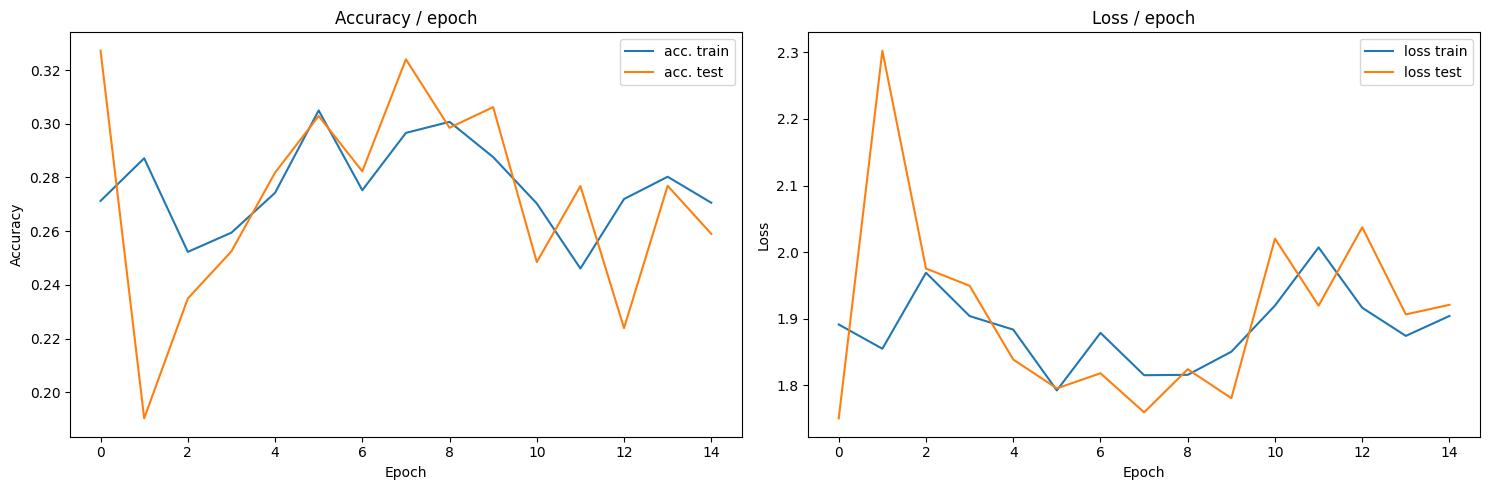

In [35]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_vit[0]), label="acc. train")
plt.plot(np.array(stats_vit[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_vit[2]), label="loss train")
plt.plot(np.array(stats_vit[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_15.pdf", dpi=100, bbox_inches="tight")
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [36]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10).cuda()
stats_pretrained = main(model=model, epochs=15, tqdm_batch=True)

  0%|                                                                                                        | 0/938 [00:00<?, ?it/s]

  0%|                                                                                                         | 0/15 [00:00<?, ?it/s]

  0%|                                                                                                | 1/938 [00:00<08:47,  1.78it/s]

  0%|▏                                                                                               | 2/938 [00:01<08:42,  1.79it/s]

  0%|▎                                                                                               | 3/938 [00:01<08:40,  1.80it/s]

  0%|▍                                                                                               | 4/938 [00:02<08:39,  1.80it/s]

  1%|▌                                                                                               | 5/938 [00:02<08:38,  1.80it/s]

  1%|▌                                                                                               | 6/938 [00:03<08:37,  1.80it/s]

  1%|▋                                                                                               | 7/938 [00:03<08:36,  1.80it/s]

  1%|▊                                                                                               | 8/938 [00:04<08:36,  1.80it/s]

  1%|▉                                                                                               | 9/938 [00:05<08:36,  1.80it/s]

  1%|█                                                                                              | 10/938 [00:05<08:35,  1.80it/s]

  1%|█                                                                                              | 11/938 [00:06<08:34,  1.80it/s]

  1%|█▏                                                                                             | 12/938 [00:06<08:34,  1.80it/s]

  1%|█▎                                                                                             | 13/938 [00:07<08:33,  1.80it/s]

  1%|█▍                                                                                             | 14/938 [00:07<08:32,  1.80it/s]

  2%|█▌                                                                                             | 15/938 [00:08<08:32,  1.80it/s]

  2%|█▌                                                                                             | 16/938 [00:08<08:31,  1.80it/s]

  2%|█▋                                                                                             | 17/938 [00:09<08:31,  1.80it/s]

  2%|█▊                                                                                             | 18/938 [00:10<08:30,  1.80it/s]

  2%|█▉                                                                                             | 19/938 [00:10<08:29,  1.80it/s]

  2%|██                                                                                             | 20/938 [00:11<08:29,  1.80it/s]

  2%|██▏                                                                                            | 21/938 [00:11<08:29,  1.80it/s]

  2%|██▏                                                                                            | 22/938 [00:12<08:28,  1.80it/s]

  2%|██▎                                                                                            | 23/938 [00:12<08:27,  1.80it/s]

  3%|██▍                                                                                            | 24/938 [00:13<08:27,  1.80it/s]

  3%|██▌                                                                                            | 25/938 [00:13<08:26,  1.80it/s]

  3%|██▋                                                                                            | 26/938 [00:14<08:26,  1.80it/s]

  3%|██▋                                                                                            | 27/938 [00:14<08:25,  1.80it/s]

  3%|██▊                                                                                            | 28/938 [00:15<08:24,  1.80it/s]

  3%|██▉                                                                                            | 29/938 [00:16<08:24,  1.80it/s]

  3%|███                                                                                            | 30/938 [00:16<08:23,  1.80it/s]

  3%|███▏                                                                                           | 31/938 [00:17<08:23,  1.80it/s]

  3%|███▏                                                                                           | 32/938 [00:17<08:22,  1.80it/s]

  4%|███▎                                                                                           | 33/938 [00:18<08:26,  1.79it/s]

  4%|███▍                                                                                           | 34/938 [00:18<08:24,  1.79it/s]

  4%|███▌                                                                                           | 35/938 [00:19<08:23,  1.79it/s]

  4%|███▋                                                                                           | 36/938 [00:20<08:22,  1.80it/s]

  4%|███▋                                                                                           | 37/938 [00:20<08:21,  1.80it/s]

  4%|███▊                                                                                           | 38/938 [00:21<08:20,  1.80it/s]

  4%|███▉                                                                                           | 39/938 [00:21<08:21,  1.79it/s]

  4%|████                                                                                           | 40/938 [00:22<08:19,  1.80it/s]

  4%|████▏                                                                                          | 41/938 [00:22<08:18,  1.80it/s]

  4%|████▎                                                                                          | 42/938 [00:23<08:17,  1.80it/s]

  5%|████▎                                                                                          | 43/938 [00:23<08:16,  1.80it/s]

  5%|████▍                                                                                          | 44/938 [00:24<08:15,  1.80it/s]

  5%|████▌                                                                                          | 45/938 [00:25<08:15,  1.80it/s]

  5%|████▋                                                                                          | 46/938 [00:25<08:19,  1.79it/s]

  5%|████▊                                                                                          | 47/938 [00:26<08:21,  1.78it/s]

  5%|████▊                                                                                          | 48/938 [00:26<08:23,  1.77it/s]

  5%|████▉                                                                                          | 49/938 [00:27<08:23,  1.76it/s]

  5%|█████                                                                                          | 50/938 [00:27<08:24,  1.76it/s]

  5%|█████▏                                                                                         | 51/938 [00:28<08:24,  1.76it/s]

  6%|█████▎                                                                                         | 52/938 [00:29<08:24,  1.76it/s]

  6%|█████▎                                                                                         | 53/938 [00:29<08:28,  1.74it/s]

  6%|█████▍                                                                                         | 54/938 [00:30<08:23,  1.76it/s]

  6%|█████▌                                                                                         | 55/938 [00:30<08:18,  1.77it/s]

  6%|█████▋                                                                                         | 56/938 [00:31<08:15,  1.78it/s]

  6%|█████▊                                                                                         | 57/938 [00:31<08:13,  1.79it/s]

  6%|█████▊                                                                                         | 58/938 [00:32<08:11,  1.79it/s]

  6%|█████▉                                                                                         | 59/938 [00:32<08:10,  1.79it/s]

  6%|██████                                                                                         | 60/938 [00:33<08:09,  1.79it/s]

  7%|██████▏                                                                                        | 61/938 [00:34<08:08,  1.80it/s]

  7%|██████▎                                                                                        | 62/938 [00:34<08:07,  1.80it/s]

  7%|██████▍                                                                                        | 63/938 [00:35<08:06,  1.80it/s]

  7%|██████▍                                                                                        | 64/938 [00:35<08:05,  1.80it/s]

  7%|██████▌                                                                                        | 65/938 [00:36<08:05,  1.80it/s]

  7%|██████▋                                                                                        | 66/938 [00:36<08:04,  1.80it/s]

  7%|██████▊                                                                                        | 67/938 [00:37<08:10,  1.78it/s]

  7%|██████▉                                                                                        | 68/938 [00:37<08:07,  1.78it/s]

  7%|██████▉                                                                                        | 69/938 [00:38<08:07,  1.78it/s]

  7%|███████                                                                                        | 70/938 [00:39<08:05,  1.79it/s]

  8%|███████▏                                                                                       | 71/938 [00:39<08:04,  1.79it/s]

  8%|███████▎                                                                                       | 72/938 [00:40<08:02,  1.79it/s]

  8%|███████▍                                                                                       | 73/938 [00:40<08:01,  1.80it/s]

  8%|███████▍                                                                                       | 74/938 [00:41<08:00,  1.80it/s]

  8%|███████▌                                                                                       | 75/938 [00:41<08:00,  1.80it/s]

  8%|███████▋                                                                                       | 76/938 [00:42<07:59,  1.80it/s]

  8%|███████▊                                                                                       | 77/938 [00:42<07:59,  1.80it/s]

  8%|███████▉                                                                                       | 78/938 [00:43<07:58,  1.80it/s]

  8%|████████                                                                                       | 79/938 [00:44<07:57,  1.80it/s]

  9%|████████                                                                                       | 80/938 [00:44<07:57,  1.80it/s]

  9%|████████▏                                                                                      | 81/938 [00:45<07:57,  1.80it/s]

  9%|████████▎                                                                                      | 82/938 [00:45<07:56,  1.80it/s]

  9%|████████▍                                                                                      | 83/938 [00:46<07:56,  1.80it/s]

  9%|████████▌                                                                                      | 84/938 [00:46<07:55,  1.80it/s]

  9%|████████▌                                                                                      | 85/938 [00:47<07:55,  1.79it/s]

  9%|████████▋                                                                                      | 86/938 [00:47<07:54,  1.80it/s]

  9%|████████▊                                                                                      | 87/938 [00:48<07:54,  1.80it/s]

  9%|████████▉                                                                                      | 88/938 [00:49<07:53,  1.79it/s]

  9%|█████████                                                                                      | 89/938 [00:49<07:53,  1.79it/s]

 10%|█████████                                                                                      | 90/938 [00:50<07:52,  1.79it/s]

 10%|█████████▏                                                                                     | 91/938 [00:50<07:51,  1.79it/s]

 10%|█████████▎                                                                                     | 92/938 [00:51<07:51,  1.79it/s]

 10%|█████████▍                                                                                     | 93/938 [00:51<07:50,  1.79it/s]

 10%|█████████▌                                                                                     | 94/938 [00:52<07:50,  1.80it/s]

 10%|█████████▌                                                                                     | 95/938 [00:52<07:49,  1.79it/s]

 10%|█████████▋                                                                                     | 96/938 [00:53<07:49,  1.79it/s]

 10%|█████████▊                                                                                     | 97/938 [00:54<07:48,  1.79it/s]

 10%|█████████▉                                                                                     | 98/938 [00:54<07:48,  1.79it/s]

 11%|██████████                                                                                     | 99/938 [00:55<07:47,  1.79it/s]

 11%|██████████                                                                                    | 100/938 [00:55<07:47,  1.79it/s]

 11%|██████████                                                                                    | 101/938 [00:56<07:46,  1.79it/s]

 11%|██████████▏                                                                                   | 102/938 [00:56<07:45,  1.80it/s]

 11%|██████████▎                                                                                   | 103/938 [00:57<07:45,  1.79it/s]

 11%|██████████▍                                                                                   | 104/938 [00:58<07:52,  1.77it/s]

 11%|██████████▌                                                                                   | 105/938 [00:58<07:49,  1.78it/s]

 11%|██████████▌                                                                                   | 106/938 [00:59<07:47,  1.78it/s]

 11%|██████████▋                                                                                   | 107/938 [00:59<07:45,  1.79it/s]

 12%|██████████▊                                                                                   | 108/938 [01:00<07:47,  1.78it/s]

 12%|██████████▉                                                                                   | 109/938 [01:00<07:48,  1.77it/s]

 12%|███████████                                                                                   | 110/938 [01:01<07:49,  1.76it/s]

 12%|███████████                                                                                   | 111/938 [01:01<07:49,  1.76it/s]

 12%|███████████▏                                                                                  | 112/938 [01:02<07:50,  1.76it/s]

 12%|███████████▎                                                                                  | 113/938 [01:03<07:49,  1.76it/s]

 12%|███████████▍                                                                                  | 114/938 [01:03<07:49,  1.76it/s]

 12%|███████████▌                                                                                  | 115/938 [01:04<07:48,  1.76it/s]

 12%|███████████▌                                                                                  | 116/938 [01:04<07:48,  1.75it/s]

 12%|███████████▋                                                                                  | 117/938 [01:05<07:48,  1.75it/s]

 13%|███████████▊                                                                                  | 118/938 [01:05<07:47,  1.75it/s]

 13%|███████████▉                                                                                  | 119/938 [01:06<07:47,  1.75it/s]

 13%|████████████                                                                                  | 120/938 [01:07<07:47,  1.75it/s]

 13%|████████████▏                                                                                 | 121/938 [01:07<07:46,  1.75it/s]

 13%|████████████▏                                                                                 | 122/938 [01:08<07:45,  1.75it/s]

 13%|████████████▎                                                                                 | 123/938 [01:08<07:45,  1.75it/s]

 13%|████████████▍                                                                                 | 124/938 [01:09<07:44,  1.75it/s]

 13%|████████████▌                                                                                 | 125/938 [01:09<07:43,  1.75it/s]

 13%|████████████▋                                                                                 | 126/938 [01:10<07:43,  1.75it/s]

 14%|████████████▋                                                                                 | 127/938 [01:11<07:42,  1.75it/s]

 14%|████████████▊                                                                                 | 128/938 [01:11<07:42,  1.75it/s]

 14%|████████████▉                                                                                 | 129/938 [01:12<07:41,  1.75it/s]

 14%|█████████████                                                                                 | 130/938 [01:12<07:41,  1.75it/s]

 14%|█████████████▏                                                                                | 131/938 [01:13<07:40,  1.75it/s]

 14%|█████████████▏                                                                                | 132/938 [01:13<07:40,  1.75it/s]

 14%|█████████████▎                                                                                | 133/938 [01:14<07:39,  1.75it/s]

 14%|█████████████▍                                                                                | 134/938 [01:15<07:35,  1.76it/s]

 14%|█████████████▌                                                                                | 135/938 [01:15<07:33,  1.77it/s]

 14%|█████████████▋                                                                                | 136/938 [01:16<07:30,  1.78it/s]

 15%|█████████████▋                                                                                | 137/938 [01:16<07:29,  1.78it/s]

 15%|█████████████▊                                                                                | 138/938 [01:17<07:28,  1.78it/s]

 15%|█████████████▉                                                                                | 139/938 [01:17<07:27,  1.79it/s]

 15%|██████████████                                                                                | 140/938 [01:18<07:25,  1.79it/s]

 15%|██████████████▏                                                                               | 141/938 [01:18<07:24,  1.79it/s]

 15%|██████████████▏                                                                               | 142/938 [01:19<07:23,  1.79it/s]

 15%|██████████████▎                                                                               | 143/938 [01:20<07:23,  1.79it/s]

 15%|██████████████▍                                                                               | 144/938 [01:20<07:27,  1.77it/s]

 15%|██████████████▌                                                                               | 145/938 [01:21<07:25,  1.78it/s]

 16%|██████████████▋                                                                               | 146/938 [01:21<07:24,  1.78it/s]

 16%|██████████████▋                                                                               | 147/938 [01:22<07:23,  1.79it/s]

 16%|██████████████▊                                                                               | 148/938 [01:22<07:22,  1.79it/s]

 16%|██████████████▉                                                                               | 149/938 [01:23<07:21,  1.79it/s]

 16%|███████████████                                                                               | 150/938 [01:24<07:20,  1.79it/s]

 16%|███████████████▏                                                                              | 151/938 [01:24<07:19,  1.79it/s]

 16%|███████████████▏                                                                              | 152/938 [01:25<07:18,  1.79it/s]

 16%|███████████████▎                                                                              | 153/938 [01:25<07:17,  1.79it/s]

 16%|███████████████▍                                                                              | 154/938 [01:26<07:17,  1.79it/s]

 17%|███████████████▌                                                                              | 155/938 [01:26<07:16,  1.79it/s]

 17%|███████████████▋                                                                              | 156/938 [01:27<07:16,  1.79it/s]

 17%|███████████████▋                                                                              | 157/938 [01:27<07:15,  1.79it/s]

 17%|███████████████▊                                                                              | 158/938 [01:28<07:15,  1.79it/s]

 17%|███████████████▉                                                                              | 159/938 [01:29<07:15,  1.79it/s]

 17%|████████████████                                                                              | 160/938 [01:29<07:14,  1.79it/s]

 17%|████████████████▏                                                                             | 161/938 [01:30<07:13,  1.79it/s]

 17%|████████████████▏                                                                             | 162/938 [01:30<07:12,  1.79it/s]

 17%|████████████████▎                                                                             | 163/938 [01:31<07:12,  1.79it/s]

 17%|████████████████▍                                                                             | 164/938 [01:31<07:11,  1.79it/s]

 18%|████████████████▌                                                                             | 165/938 [01:32<07:11,  1.79it/s]

 18%|████████████████▋                                                                             | 166/938 [01:32<07:10,  1.79it/s]

 18%|████████████████▋                                                                             | 167/938 [01:33<07:10,  1.79it/s]

 18%|████████████████▊                                                                             | 168/938 [01:34<07:09,  1.79it/s]

 18%|████████████████▉                                                                             | 169/938 [01:34<07:08,  1.79it/s]

 18%|█████████████████                                                                             | 170/938 [01:35<07:08,  1.79it/s]

 18%|█████████████████▏                                                                            | 171/938 [01:35<07:07,  1.79it/s]

 18%|█████████████████▏                                                                            | 172/938 [01:36<07:06,  1.80it/s]

 18%|█████████████████▎                                                                            | 173/938 [01:36<07:06,  1.79it/s]

 19%|█████████████████▍                                                                            | 174/938 [01:37<07:06,  1.79it/s]

 19%|█████████████████▌                                                                            | 175/938 [01:37<07:05,  1.79it/s]

 19%|█████████████████▋                                                                            | 176/938 [01:38<07:04,  1.79it/s]

 19%|█████████████████▋                                                                            | 177/938 [01:39<07:04,  1.79it/s]

 19%|█████████████████▊                                                                            | 178/938 [01:39<07:03,  1.79it/s]

 19%|█████████████████▉                                                                            | 179/938 [01:40<07:02,  1.79it/s]

 19%|██████████████████                                                                            | 180/938 [01:40<07:02,  1.79it/s]

 19%|██████████████████▏                                                                           | 181/938 [01:41<07:01,  1.79it/s]

 19%|██████████████████▏                                                                           | 182/938 [01:41<07:01,  1.79it/s]

 20%|██████████████████▎                                                                           | 183/938 [01:42<07:00,  1.79it/s]

 20%|██████████████████▍                                                                           | 184/938 [01:42<07:00,  1.79it/s]

 20%|██████████████████▌                                                                           | 185/938 [01:43<06:59,  1.79it/s]

 20%|██████████████████▋                                                                           | 186/938 [01:44<06:59,  1.79it/s]

 20%|██████████████████▋                                                                           | 187/938 [01:44<06:58,  1.79it/s]

 20%|██████████████████▊                                                                           | 188/938 [01:45<06:57,  1.80it/s]

 20%|██████████████████▉                                                                           | 189/938 [01:45<06:57,  1.80it/s]

 20%|███████████████████                                                                           | 190/938 [01:46<07:01,  1.77it/s]

 20%|███████████████████▏                                                                          | 191/938 [01:46<06:59,  1.78it/s]

 20%|███████████████████▏                                                                          | 192/938 [01:47<06:58,  1.78it/s]

 21%|███████████████████▎                                                                          | 193/938 [01:48<06:57,  1.79it/s]

 21%|███████████████████▍                                                                          | 194/938 [01:48<06:56,  1.79it/s]

 21%|███████████████████▌                                                                          | 195/938 [01:49<06:55,  1.79it/s]

 21%|███████████████████▋                                                                          | 196/938 [01:49<06:54,  1.79it/s]

 21%|███████████████████▋                                                                          | 197/938 [01:50<06:53,  1.79it/s]

 21%|███████████████████▊                                                                          | 198/938 [01:50<06:52,  1.79it/s]

 21%|███████████████████▉                                                                          | 199/938 [01:51<06:52,  1.79it/s]

 21%|████████████████████                                                                          | 200/938 [01:51<06:51,  1.79it/s]

 21%|████████████████████▏                                                                         | 201/938 [01:52<06:50,  1.79it/s]

 22%|████████████████████▏                                                                         | 202/938 [01:53<06:50,  1.79it/s]

 22%|████████████████████▎                                                                         | 203/938 [01:53<06:49,  1.79it/s]

 22%|████████████████████▍                                                                         | 204/938 [01:54<06:49,  1.79it/s]

 22%|████████████████████▌                                                                         | 205/938 [01:54<06:48,  1.80it/s]

 22%|████████████████████▋                                                                         | 206/938 [01:55<06:47,  1.80it/s]

 22%|████████████████████▋                                                                         | 207/938 [01:55<06:47,  1.80it/s]

 22%|████████████████████▊                                                                         | 208/938 [01:56<06:46,  1.80it/s]

 22%|████████████████████▉                                                                         | 209/938 [01:56<06:46,  1.79it/s]

 22%|█████████████████████                                                                         | 210/938 [01:57<06:46,  1.79it/s]

 22%|█████████████████████▏                                                                        | 211/938 [01:58<06:45,  1.79it/s]

 23%|█████████████████████▏                                                                        | 212/938 [01:58<06:45,  1.79it/s]

 23%|█████████████████████▎                                                                        | 213/938 [01:59<06:44,  1.79it/s]

 23%|█████████████████████▍                                                                        | 214/938 [01:59<06:43,  1.79it/s]

 23%|█████████████████████▌                                                                        | 215/938 [02:00<06:42,  1.79it/s]

 23%|█████████████████████▋                                                                        | 216/938 [02:00<06:59,  1.72it/s]

 23%|█████████████████████▋                                                                        | 217/938 [02:01<06:53,  1.74it/s]

 23%|█████████████████████▊                                                                        | 218/938 [02:02<06:49,  1.76it/s]

 23%|█████████████████████▉                                                                        | 219/938 [02:02<06:46,  1.77it/s]

 23%|██████████████████████                                                                        | 220/938 [02:03<06:44,  1.78it/s]

 24%|██████████████████████▏                                                                       | 221/938 [02:03<06:43,  1.78it/s]

 24%|██████████████████████▏                                                                       | 222/938 [02:04<06:41,  1.78it/s]

 24%|██████████████████████▎                                                                       | 223/938 [02:04<06:40,  1.79it/s]

 24%|██████████████████████▍                                                                       | 224/938 [02:05<06:38,  1.79it/s]

 24%|██████████████████████▌                                                                       | 225/938 [02:05<06:38,  1.79it/s]

 24%|██████████████████████▋                                                                       | 226/938 [02:06<06:37,  1.79it/s]

 24%|██████████████████████▋                                                                       | 227/938 [02:07<06:36,  1.79it/s]

 24%|██████████████████████▊                                                                       | 228/938 [02:07<06:36,  1.79it/s]

 24%|██████████████████████▉                                                                       | 229/938 [02:08<06:35,  1.79it/s]

 25%|███████████████████████                                                                       | 230/938 [02:08<06:35,  1.79it/s]

 25%|███████████████████████▏                                                                      | 231/938 [02:09<06:35,  1.79it/s]

 25%|███████████████████████▏                                                                      | 232/938 [02:09<06:34,  1.79it/s]

 25%|███████████████████████▎                                                                      | 233/938 [02:10<06:34,  1.79it/s]

 25%|███████████████████████▍                                                                      | 234/938 [02:10<06:34,  1.79it/s]

 25%|███████████████████████▌                                                                      | 235/938 [02:11<06:36,  1.77it/s]

 25%|███████████████████████▋                                                                      | 236/938 [02:12<06:36,  1.77it/s]

 25%|███████████████████████▊                                                                      | 237/938 [02:12<06:34,  1.78it/s]

 25%|███████████████████████▊                                                                      | 238/938 [02:13<06:33,  1.78it/s]

 25%|███████████████████████▉                                                                      | 239/938 [02:13<06:32,  1.78it/s]

 26%|████████████████████████                                                                      | 240/938 [02:14<06:31,  1.78it/s]

 26%|████████████████████████▏                                                                     | 241/938 [02:14<06:30,  1.79it/s]

 26%|████████████████████████▎                                                                     | 242/938 [02:15<06:29,  1.79it/s]

 26%|████████████████████████▎                                                                     | 243/938 [02:16<06:34,  1.76it/s]

 26%|████████████████████████▍                                                                     | 244/938 [02:16<06:31,  1.77it/s]

 26%|████████████████████████▌                                                                     | 245/938 [02:17<06:30,  1.78it/s]

 26%|████████████████████████▋                                                                     | 246/938 [02:17<06:28,  1.78it/s]

 26%|████████████████████████▊                                                                     | 247/938 [02:18<06:27,  1.78it/s]

 26%|████████████████████████▊                                                                     | 248/938 [02:18<06:26,  1.78it/s]

 27%|████████████████████████▉                                                                     | 249/938 [02:19<06:26,  1.78it/s]

 27%|█████████████████████████                                                                     | 250/938 [02:19<06:26,  1.78it/s]

 27%|█████████████████████████▏                                                                    | 251/938 [02:20<06:25,  1.78it/s]

 27%|█████████████████████████▎                                                                    | 252/938 [02:21<06:24,  1.79it/s]

 27%|█████████████████████████▎                                                                    | 253/938 [02:21<06:23,  1.79it/s]

 27%|█████████████████████████▍                                                                    | 254/938 [02:22<06:22,  1.79it/s]

 27%|█████████████████████████▌                                                                    | 255/938 [02:22<06:22,  1.79it/s]

 27%|█████████████████████████▋                                                                    | 256/938 [02:23<06:21,  1.79it/s]

 27%|█████████████████████████▊                                                                    | 257/938 [02:23<06:20,  1.79it/s]

 28%|█████████████████████████▊                                                                    | 258/938 [02:24<06:19,  1.79it/s]

 28%|█████████████████████████▉                                                                    | 259/938 [02:25<06:18,  1.79it/s]

 28%|██████████████████████████                                                                    | 260/938 [02:25<06:18,  1.79it/s]

 28%|██████████████████████████▏                                                                   | 261/938 [02:26<06:17,  1.79it/s]

 28%|██████████████████████████▎                                                                   | 262/938 [02:26<06:16,  1.79it/s]

 28%|██████████████████████████▎                                                                   | 263/938 [02:27<06:16,  1.79it/s]

 28%|██████████████████████████▍                                                                   | 264/938 [02:27<06:15,  1.79it/s]

 28%|██████████████████████████▌                                                                   | 265/938 [02:28<06:26,  1.74it/s]

 28%|██████████████████████████▋                                                                   | 266/938 [02:28<06:22,  1.76it/s]

 28%|██████████████████████████▊                                                                   | 267/938 [02:29<06:19,  1.77it/s]

 29%|██████████████████████████▊                                                                   | 268/938 [02:30<06:16,  1.78it/s]

 29%|██████████████████████████▉                                                                   | 269/938 [02:30<06:15,  1.78it/s]

 29%|███████████████████████████                                                                   | 270/938 [02:31<06:14,  1.79it/s]

 29%|███████████████████████████▏                                                                  | 271/938 [02:31<06:12,  1.79it/s]

 29%|███████████████████████████▎                                                                  | 272/938 [02:32<06:11,  1.79it/s]

 29%|███████████████████████████▎                                                                  | 273/938 [02:32<06:10,  1.79it/s]

 29%|███████████████████████████▍                                                                  | 274/938 [02:33<06:10,  1.79it/s]

 29%|███████████████████████████▌                                                                  | 275/938 [02:33<06:09,  1.79it/s]

 29%|███████████████████████████▋                                                                  | 276/938 [02:34<06:09,  1.79it/s]

 30%|███████████████████████████▊                                                                  | 277/938 [02:35<06:08,  1.79it/s]

 30%|███████████████████████████▊                                                                  | 278/938 [02:35<06:07,  1.80it/s]

 30%|███████████████████████████▉                                                                  | 279/938 [02:36<06:06,  1.80it/s]

 30%|████████████████████████████                                                                  | 280/938 [02:36<06:06,  1.79it/s]

 30%|████████████████████████████▏                                                                 | 281/938 [02:37<06:05,  1.80it/s]

 30%|████████████████████████████▎                                                                 | 282/938 [02:37<06:05,  1.80it/s]

 30%|████████████████████████████▎                                                                 | 283/938 [02:38<06:04,  1.80it/s]

 30%|████████████████████████████▍                                                                 | 284/938 [02:38<06:04,  1.80it/s]

 30%|████████████████████████████▌                                                                 | 285/938 [02:39<06:03,  1.80it/s]

 30%|████████████████████████████▋                                                                 | 286/938 [02:40<06:02,  1.80it/s]

 31%|████████████████████████████▊                                                                 | 287/938 [02:40<06:02,  1.80it/s]

 31%|████████████████████████████▊                                                                 | 288/938 [02:41<06:01,  1.80it/s]

 31%|████████████████████████████▉                                                                 | 289/938 [02:41<06:01,  1.80it/s]

 31%|█████████████████████████████                                                                 | 290/938 [02:42<06:00,  1.80it/s]

 31%|█████████████████████████████▏                                                                | 291/938 [02:42<06:00,  1.80it/s]

 31%|█████████████████████████████▎                                                                | 292/938 [02:43<06:02,  1.78it/s]

 31%|█████████████████████████████▎                                                                | 293/938 [02:44<06:03,  1.77it/s]

 31%|█████████████████████████████▍                                                                | 294/938 [02:44<06:04,  1.77it/s]

 31%|█████████████████████████████▌                                                                | 295/938 [02:45<06:05,  1.76it/s]

 32%|█████████████████████████████▋                                                                | 296/938 [02:45<06:05,  1.76it/s]

 32%|█████████████████████████████▊                                                                | 297/938 [02:46<06:05,  1.75it/s]

 32%|█████████████████████████████▊                                                                | 298/938 [02:46<06:05,  1.75it/s]

 32%|█████████████████████████████▉                                                                | 299/938 [02:47<06:04,  1.75it/s]

 32%|██████████████████████████████                                                                | 300/938 [02:48<06:01,  1.76it/s]

 32%|██████████████████████████████▏                                                               | 301/938 [02:48<05:59,  1.77it/s]

 32%|██████████████████████████████▎                                                               | 302/938 [02:49<05:57,  1.78it/s]

 32%|██████████████████████████████▎                                                               | 303/938 [02:49<05:55,  1.79it/s]

 32%|██████████████████████████████▍                                                               | 304/938 [02:50<05:54,  1.79it/s]

 33%|██████████████████████████████▌                                                               | 305/938 [02:50<05:53,  1.79it/s]

 33%|██████████████████████████████▋                                                               | 306/938 [02:51<05:52,  1.79it/s]

 33%|██████████████████████████████▊                                                               | 307/938 [02:51<05:51,  1.79it/s]

 33%|██████████████████████████████▊                                                               | 308/938 [02:52<05:50,  1.80it/s]

 33%|██████████████████████████████▉                                                               | 309/938 [02:53<05:50,  1.80it/s]

 33%|███████████████████████████████                                                               | 310/938 [02:53<05:49,  1.80it/s]

 33%|███████████████████████████████▏                                                              | 311/938 [02:54<05:49,  1.80it/s]

 33%|███████████████████████████████▎                                                              | 312/938 [02:54<05:48,  1.80it/s]

 33%|███████████████████████████████▎                                                              | 313/938 [02:55<05:49,  1.79it/s]

 33%|███████████████████████████████▍                                                              | 314/938 [02:55<05:50,  1.78it/s]

 34%|███████████████████████████████▌                                                              | 315/938 [02:56<05:48,  1.79it/s]

 34%|███████████████████████████████▋                                                              | 316/938 [02:56<05:47,  1.79it/s]

 34%|███████████████████████████████▊                                                              | 317/938 [02:57<05:46,  1.79it/s]

 34%|███████████████████████████████▊                                                              | 318/938 [02:58<05:45,  1.79it/s]

 34%|███████████████████████████████▉                                                              | 319/938 [02:58<05:44,  1.79it/s]

 34%|████████████████████████████████                                                              | 320/938 [02:59<05:44,  1.80it/s]

 34%|████████████████████████████████▏                                                             | 321/938 [02:59<05:43,  1.79it/s]

 34%|████████████████████████████████▎                                                             | 322/938 [03:00<05:43,  1.80it/s]

 34%|████████████████████████████████▎                                                             | 323/938 [03:00<05:42,  1.80it/s]

 35%|████████████████████████████████▍                                                             | 324/938 [03:01<05:42,  1.79it/s]

 35%|████████████████████████████████▌                                                             | 325/938 [03:01<05:41,  1.80it/s]

 35%|████████████████████████████████▋                                                             | 326/938 [03:02<05:40,  1.79it/s]

 35%|████████████████████████████████▊                                                             | 327/938 [03:03<05:40,  1.80it/s]

 35%|████████████████████████████████▊                                                             | 328/938 [03:03<05:39,  1.80it/s]

 35%|████████████████████████████████▉                                                             | 329/938 [03:04<05:39,  1.80it/s]

 35%|█████████████████████████████████                                                             | 330/938 [03:04<05:38,  1.80it/s]

 35%|█████████████████████████████████▏                                                            | 331/938 [03:05<05:38,  1.80it/s]

 35%|█████████████████████████████████▎                                                            | 332/938 [03:05<05:37,  1.80it/s]

 36%|█████████████████████████████████▎                                                            | 333/938 [03:06<05:36,  1.80it/s]

 36%|█████████████████████████████████▍                                                            | 334/938 [03:06<05:36,  1.80it/s]

 36%|█████████████████████████████████▌                                                            | 335/938 [03:07<05:35,  1.80it/s]

 36%|█████████████████████████████████▋                                                            | 336/938 [03:08<05:35,  1.80it/s]

 36%|█████████████████████████████████▊                                                            | 337/938 [03:08<05:34,  1.80it/s]

 36%|█████████████████████████████████▊                                                            | 338/938 [03:09<05:34,  1.80it/s]

 36%|█████████████████████████████████▉                                                            | 339/938 [03:09<05:33,  1.80it/s]

 36%|██████████████████████████████████                                                            | 340/938 [03:10<05:32,  1.80it/s]

 36%|██████████████████████████████████▏                                                           | 341/938 [03:10<05:32,  1.80it/s]

 36%|██████████████████████████████████▎                                                           | 342/938 [03:11<05:31,  1.80it/s]

 37%|██████████████████████████████████▎                                                           | 343/938 [03:11<05:31,  1.80it/s]

 37%|██████████████████████████████████▍                                                           | 344/938 [03:12<05:30,  1.80it/s]

 37%|██████████████████████████████████▌                                                           | 345/938 [03:13<05:30,  1.80it/s]

 37%|██████████████████████████████████▋                                                           | 346/938 [03:13<05:29,  1.80it/s]

 37%|██████████████████████████████████▊                                                           | 347/938 [03:14<05:28,  1.80it/s]

 37%|██████████████████████████████████▊                                                           | 348/938 [03:14<05:28,  1.80it/s]

 37%|██████████████████████████████████▉                                                           | 349/938 [03:15<05:27,  1.80it/s]

 37%|███████████████████████████████████                                                           | 350/938 [03:15<05:27,  1.79it/s]

 37%|███████████████████████████████████▏                                                          | 351/938 [03:16<05:26,  1.80it/s]

 38%|███████████████████████████████████▎                                                          | 352/938 [03:16<05:26,  1.80it/s]

 38%|███████████████████████████████████▍                                                          | 353/938 [03:17<05:25,  1.80it/s]

 38%|███████████████████████████████████▍                                                          | 354/938 [03:18<05:25,  1.80it/s]

 38%|███████████████████████████████████▌                                                          | 355/938 [03:18<05:24,  1.80it/s]

 38%|███████████████████████████████████▋                                                          | 356/938 [03:19<05:24,  1.80it/s]

 38%|███████████████████████████████████▊                                                          | 357/938 [03:19<05:23,  1.80it/s]

 38%|███████████████████████████████████▉                                                          | 358/938 [03:20<05:23,  1.80it/s]

 38%|███████████████████████████████████▉                                                          | 359/938 [03:20<05:22,  1.80it/s]

 38%|████████████████████████████████████                                                          | 360/938 [03:21<05:21,  1.80it/s]

 38%|████████████████████████████████████▏                                                         | 361/938 [03:21<05:21,  1.80it/s]

 39%|████████████████████████████████████▎                                                         | 362/938 [03:22<05:20,  1.80it/s]

 39%|████████████████████████████████████▍                                                         | 363/938 [03:23<05:19,  1.80it/s]

 39%|████████████████████████████████████▍                                                         | 364/938 [03:23<05:19,  1.80it/s]

 39%|████████████████████████████████████▌                                                         | 365/938 [03:24<05:18,  1.80it/s]

 39%|████████████████████████████████████▋                                                         | 366/938 [03:24<05:18,  1.80it/s]

 39%|████████████████████████████████████▊                                                         | 367/938 [03:25<05:17,  1.80it/s]

 39%|████████████████████████████████████▉                                                         | 368/938 [03:25<05:16,  1.80it/s]

 39%|████████████████████████████████████▉                                                         | 369/938 [03:26<05:16,  1.80it/s]

 39%|█████████████████████████████████████                                                         | 370/938 [03:27<05:15,  1.80it/s]

 40%|█████████████████████████████████████▏                                                        | 371/938 [03:27<05:15,  1.80it/s]

 40%|█████████████████████████████████████▎                                                        | 372/938 [03:28<05:14,  1.80it/s]

 40%|█████████████████████████████████████▍                                                        | 373/938 [03:28<05:14,  1.80it/s]

 40%|█████████████████████████████████████▍                                                        | 374/938 [03:29<05:13,  1.80it/s]

 40%|█████████████████████████████████████▌                                                        | 375/938 [03:29<05:13,  1.80it/s]

 40%|█████████████████████████████████████▋                                                        | 376/938 [03:30<05:12,  1.80it/s]

 40%|█████████████████████████████████████▊                                                        | 377/938 [03:30<05:11,  1.80it/s]

 40%|█████████████████████████████████████▉                                                        | 378/938 [03:31<05:11,  1.80it/s]

 40%|█████████████████████████████████████▉                                                        | 379/938 [03:32<05:11,  1.80it/s]

 41%|██████████████████████████████████████                                                        | 380/938 [03:32<05:10,  1.80it/s]

 41%|██████████████████████████████████████▏                                                       | 381/938 [03:33<05:14,  1.77it/s]

 41%|██████████████████████████████████████▎                                                       | 382/938 [03:33<05:12,  1.78it/s]

 41%|██████████████████████████████████████▍                                                       | 383/938 [03:34<05:10,  1.79it/s]

 41%|██████████████████████████████████████▍                                                       | 384/938 [03:34<05:09,  1.79it/s]

 41%|██████████████████████████████████████▌                                                       | 385/938 [03:35<05:08,  1.79it/s]

 41%|██████████████████████████████████████▋                                                       | 386/938 [03:35<05:07,  1.80it/s]

 41%|██████████████████████████████████████▊                                                       | 387/938 [03:36<05:06,  1.80it/s]

 41%|██████████████████████████████████████▉                                                       | 388/938 [03:37<05:05,  1.80it/s]

 41%|██████████████████████████████████████▉                                                       | 389/938 [03:37<05:04,  1.80it/s]

 42%|███████████████████████████████████████                                                       | 390/938 [03:38<05:04,  1.80it/s]

 42%|███████████████████████████████████████▏                                                      | 391/938 [03:38<05:03,  1.80it/s]

 42%|███████████████████████████████████████▎                                                      | 392/938 [03:39<05:03,  1.80it/s]

 42%|███████████████████████████████████████▍                                                      | 393/938 [03:39<05:03,  1.80it/s]

 42%|███████████████████████████████████████▍                                                      | 394/938 [03:40<05:02,  1.80it/s]

 42%|███████████████████████████████████████▌                                                      | 395/938 [03:40<05:04,  1.78it/s]

 42%|███████████████████████████████████████▋                                                      | 396/938 [03:41<05:03,  1.79it/s]

 42%|███████████████████████████████████████▊                                                      | 397/938 [03:42<05:03,  1.78it/s]

 42%|███████████████████████████████████████▉                                                      | 398/938 [03:42<05:01,  1.79it/s]

 43%|███████████████████████████████████████▉                                                      | 399/938 [03:43<05:00,  1.79it/s]

 43%|████████████████████████████████████████                                                      | 400/938 [03:43<04:59,  1.80it/s]

 43%|████████████████████████████████████████▏                                                     | 401/938 [03:44<05:01,  1.78it/s]

 43%|████████████████████████████████████████▎                                                     | 402/938 [03:44<05:00,  1.79it/s]

 43%|████████████████████████████████████████▍                                                     | 403/938 [03:45<05:00,  1.78it/s]

 43%|████████████████████████████████████████▍                                                     | 404/938 [03:45<04:59,  1.79it/s]

 43%|████████████████████████████████████████▌                                                     | 405/938 [03:46<04:57,  1.79it/s]

 43%|████████████████████████████████████████▋                                                     | 406/938 [03:47<04:56,  1.79it/s]

 43%|████████████████████████████████████████▊                                                     | 407/938 [03:47<04:55,  1.80it/s]

 43%|████████████████████████████████████████▉                                                     | 408/938 [03:48<04:54,  1.80it/s]

 44%|████████████████████████████████████████▉                                                     | 409/938 [03:48<04:56,  1.79it/s]

 44%|█████████████████████████████████████████                                                     | 410/938 [03:49<04:57,  1.78it/s]

 44%|█████████████████████████████████████████▏                                                    | 411/938 [03:49<04:57,  1.77it/s]

 44%|█████████████████████████████████████████▎                                                    | 412/938 [03:50<04:57,  1.77it/s]

 44%|█████████████████████████████████████████▍                                                    | 413/938 [03:51<04:57,  1.76it/s]

 44%|█████████████████████████████████████████▍                                                    | 414/938 [03:51<04:57,  1.76it/s]

 44%|█████████████████████████████████████████▌                                                    | 415/938 [03:52<04:57,  1.76it/s]

 44%|█████████████████████████████████████████▋                                                    | 416/938 [03:52<04:56,  1.76it/s]

 44%|█████████████████████████████████████████▊                                                    | 417/938 [03:53<04:56,  1.76it/s]

 45%|█████████████████████████████████████████▉                                                    | 418/938 [03:53<04:55,  1.76it/s]

 45%|█████████████████████████████████████████▉                                                    | 419/938 [03:54<04:52,  1.77it/s]

 45%|██████████████████████████████████████████                                                    | 420/938 [03:54<04:50,  1.78it/s]

 45%|██████████████████████████████████████████▏                                                   | 421/938 [03:55<04:49,  1.79it/s]

 45%|██████████████████████████████████████████▎                                                   | 422/938 [03:56<04:47,  1.79it/s]

 45%|██████████████████████████████████████████▍                                                   | 423/938 [03:56<04:46,  1.80it/s]

 45%|██████████████████████████████████████████▍                                                   | 424/938 [03:57<04:46,  1.80it/s]

 45%|██████████████████████████████████████████▌                                                   | 425/938 [03:57<04:45,  1.80it/s]

 45%|██████████████████████████████████████████▋                                                   | 426/938 [03:58<04:44,  1.80it/s]

 46%|██████████████████████████████████████████▊                                                   | 427/938 [03:58<04:43,  1.80it/s]

 46%|██████████████████████████████████████████▉                                                   | 428/938 [03:59<04:43,  1.80it/s]

 46%|██████████████████████████████████████████▉                                                   | 429/938 [03:59<04:42,  1.80it/s]

 46%|███████████████████████████████████████████                                                   | 430/938 [04:00<04:41,  1.80it/s]

 46%|███████████████████████████████████████████▏                                                  | 431/938 [04:01<04:41,  1.80it/s]

 46%|███████████████████████████████████████████▎                                                  | 432/938 [04:01<04:40,  1.80it/s]

 46%|███████████████████████████████████████████▍                                                  | 433/938 [04:02<04:40,  1.80it/s]

 46%|███████████████████████████████████████████▍                                                  | 434/938 [04:02<04:39,  1.80it/s]

 46%|███████████████████████████████████████████▌                                                  | 435/938 [04:03<04:39,  1.80it/s]

 46%|███████████████████████████████████████████▋                                                  | 436/938 [04:03<04:38,  1.80it/s]

 47%|███████████████████████████████████████████▊                                                  | 437/938 [04:04<04:38,  1.80it/s]

 47%|███████████████████████████████████████████▉                                                  | 438/938 [04:04<04:37,  1.80it/s]

 47%|███████████████████████████████████████████▉                                                  | 439/938 [04:05<04:36,  1.80it/s]

 47%|████████████████████████████████████████████                                                  | 440/938 [04:06<04:36,  1.80it/s]

 47%|████████████████████████████████████████████▏                                                 | 441/938 [04:06<04:35,  1.80it/s]

 47%|████████████████████████████████████████████▎                                                 | 442/938 [04:07<04:35,  1.80it/s]

 47%|████████████████████████████████████████████▍                                                 | 443/938 [04:07<04:34,  1.80it/s]

 47%|████████████████████████████████████████████▍                                                 | 444/938 [04:08<04:34,  1.80it/s]

 47%|████████████████████████████████████████████▌                                                 | 445/938 [04:08<04:33,  1.80it/s]

 48%|████████████████████████████████████████████▋                                                 | 446/938 [04:09<04:33,  1.80it/s]

 48%|████████████████████████████████████████████▊                                                 | 447/938 [04:09<04:32,  1.80it/s]

 48%|████████████████████████████████████████████▉                                                 | 448/938 [04:10<04:31,  1.80it/s]

 48%|████████████████████████████████████████████▉                                                 | 449/938 [04:11<04:31,  1.80it/s]

 48%|█████████████████████████████████████████████                                                 | 450/938 [04:11<04:31,  1.80it/s]

 48%|█████████████████████████████████████████████▏                                                | 451/938 [04:12<04:30,  1.80it/s]

 48%|█████████████████████████████████████████████▎                                                | 452/938 [04:12<04:29,  1.80it/s]

 48%|█████████████████████████████████████████████▍                                                | 453/938 [04:13<04:29,  1.80it/s]

 48%|█████████████████████████████████████████████▍                                                | 454/938 [04:13<04:28,  1.80it/s]

 49%|█████████████████████████████████████████████▌                                                | 455/938 [04:14<04:28,  1.80it/s]

 49%|█████████████████████████████████████████████▋                                                | 456/938 [04:14<04:27,  1.80it/s]

 49%|█████████████████████████████████████████████▊                                                | 457/938 [04:15<04:26,  1.80it/s]

 49%|█████████████████████████████████████████████▉                                                | 458/938 [04:16<04:26,  1.80it/s]

 49%|█████████████████████████████████████████████▉                                                | 459/938 [04:16<04:26,  1.80it/s]

 49%|██████████████████████████████████████████████                                                | 460/938 [04:17<04:25,  1.80it/s]

 49%|██████████████████████████████████████████████▏                                               | 461/938 [04:17<04:24,  1.80it/s]

 49%|██████████████████████████████████████████████▎                                               | 462/938 [04:18<04:24,  1.80it/s]

 49%|██████████████████████████████████████████████▍                                               | 463/938 [04:18<04:23,  1.80it/s]

 49%|██████████████████████████████████████████████▍                                               | 464/938 [04:19<04:26,  1.78it/s]

 50%|██████████████████████████████████████████████▌                                               | 465/938 [04:19<04:25,  1.78it/s]

 50%|██████████████████████████████████████████████▋                                               | 466/938 [04:20<04:23,  1.79it/s]

 50%|██████████████████████████████████████████████▊                                               | 467/938 [04:21<04:22,  1.79it/s]

 50%|██████████████████████████████████████████████▉                                               | 468/938 [04:21<04:21,  1.79it/s]

 50%|███████████████████████████████████████████████                                               | 469/938 [04:22<04:20,  1.80it/s]

 50%|███████████████████████████████████████████████                                               | 470/938 [04:22<04:20,  1.80it/s]

 50%|███████████████████████████████████████████████▏                                              | 471/938 [04:23<04:19,  1.80it/s]

 50%|███████████████████████████████████████████████▎                                              | 472/938 [04:23<04:18,  1.80it/s]

 50%|███████████████████████████████████████████████▍                                              | 473/938 [04:24<04:18,  1.80it/s]

 51%|███████████████████████████████████████████████▌                                              | 474/938 [04:24<04:17,  1.80it/s]

 51%|███████████████████████████████████████████████▌                                              | 475/938 [04:25<04:16,  1.80it/s]

 51%|███████████████████████████████████████████████▋                                              | 476/938 [04:26<04:16,  1.80it/s]

 51%|███████████████████████████████████████████████▊                                              | 477/938 [04:26<04:15,  1.80it/s]

 51%|███████████████████████████████████████████████▉                                              | 478/938 [04:27<04:15,  1.80it/s]

 51%|████████████████████████████████████████████████                                              | 479/938 [04:27<04:14,  1.80it/s]

 51%|████████████████████████████████████████████████                                              | 480/938 [04:28<04:14,  1.80it/s]

 51%|████████████████████████████████████████████████▏                                             | 481/938 [04:28<04:13,  1.80it/s]

 51%|████████████████████████████████████████████████▎                                             | 482/938 [04:29<04:15,  1.79it/s]

 51%|████████████████████████████████████████████████▍                                             | 483/938 [04:30<04:15,  1.78it/s]

 52%|████████████████████████████████████████████████▌                                             | 484/938 [04:30<04:16,  1.77it/s]

 52%|████████████████████████████████████████████████▌                                             | 485/938 [04:31<04:15,  1.77it/s]

 52%|████████████████████████████████████████████████▋                                             | 486/938 [04:31<04:16,  1.77it/s]

 52%|████████████████████████████████████████████████▊                                             | 487/938 [04:32<04:15,  1.76it/s]

 52%|████████████████████████████████████████████████▉                                             | 488/938 [04:32<04:15,  1.76it/s]

 52%|█████████████████████████████████████████████████                                             | 489/938 [04:33<04:15,  1.76it/s]

 52%|█████████████████████████████████████████████████                                             | 490/938 [04:33<04:14,  1.76it/s]

 52%|█████████████████████████████████████████████████▏                                            | 491/938 [04:34<04:14,  1.76it/s]

 52%|█████████████████████████████████████████████████▎                                            | 492/938 [04:35<04:13,  1.76it/s]

 53%|█████████████████████████████████████████████████▍                                            | 493/938 [04:35<04:13,  1.76it/s]

 53%|█████████████████████████████████████████████████▌                                            | 494/938 [04:36<04:12,  1.76it/s]

 53%|█████████████████████████████████████████████████▌                                            | 495/938 [04:36<04:12,  1.76it/s]

 53%|█████████████████████████████████████████████████▋                                            | 496/938 [04:37<04:11,  1.76it/s]

 53%|█████████████████████████████████████████████████▊                                            | 497/938 [04:37<04:09,  1.76it/s]

 53%|█████████████████████████████████████████████████▉                                            | 498/938 [04:38<04:07,  1.78it/s]

 53%|██████████████████████████████████████████████████                                            | 499/938 [04:39<04:08,  1.76it/s]

 53%|██████████████████████████████████████████████████                                            | 500/938 [04:39<04:06,  1.77it/s]

 53%|██████████████████████████████████████████████████▏                                           | 501/938 [04:40<04:05,  1.78it/s]

 54%|██████████████████████████████████████████████████▎                                           | 502/938 [04:40<04:03,  1.79it/s]

 54%|██████████████████████████████████████████████████▍                                           | 503/938 [04:41<04:02,  1.79it/s]

 54%|██████████████████████████████████████████████████▌                                           | 504/938 [04:41<04:01,  1.80it/s]

 54%|██████████████████████████████████████████████████▌                                           | 505/938 [04:42<04:00,  1.80it/s]

 54%|██████████████████████████████████████████████████▋                                           | 506/938 [04:42<04:00,  1.80it/s]

 54%|██████████████████████████████████████████████████▊                                           | 507/938 [04:43<04:00,  1.79it/s]

 54%|██████████████████████████████████████████████████▉                                           | 508/938 [04:44<03:59,  1.80it/s]

 54%|███████████████████████████████████████████████████                                           | 509/938 [04:44<03:58,  1.80it/s]

 54%|███████████████████████████████████████████████████                                           | 510/938 [04:45<03:57,  1.80it/s]

 54%|███████████████████████████████████████████████████▏                                          | 511/938 [04:45<03:57,  1.80it/s]

 55%|███████████████████████████████████████████████████▎                                          | 512/938 [04:46<03:56,  1.80it/s]

 55%|███████████████████████████████████████████████████▍                                          | 513/938 [04:46<03:55,  1.80it/s]

 55%|███████████████████████████████████████████████████▌                                          | 514/938 [04:47<03:55,  1.80it/s]

 55%|███████████████████████████████████████████████████▌                                          | 515/938 [04:47<03:54,  1.80it/s]

 55%|███████████████████████████████████████████████████▋                                          | 516/938 [04:48<03:54,  1.80it/s]

 55%|███████████████████████████████████████████████████▊                                          | 517/938 [04:49<03:53,  1.80it/s]

 55%|███████████████████████████████████████████████████▉                                          | 518/938 [04:49<03:52,  1.80it/s]

 55%|████████████████████████████████████████████████████                                          | 519/938 [04:50<03:52,  1.80it/s]

 55%|████████████████████████████████████████████████████                                          | 520/938 [04:50<03:51,  1.80it/s]

 56%|████████████████████████████████████████████████████▏                                         | 521/938 [04:51<03:51,  1.80it/s]

 56%|████████████████████████████████████████████████████▎                                         | 522/938 [04:51<03:53,  1.78it/s]

 56%|████████████████████████████████████████████████████▍                                         | 523/938 [04:52<03:51,  1.79it/s]

 56%|████████████████████████████████████████████████████▌                                         | 524/938 [04:52<03:50,  1.79it/s]

 56%|████████████████████████████████████████████████████▌                                         | 525/938 [04:53<03:50,  1.79it/s]

 56%|████████████████████████████████████████████████████▋                                         | 526/938 [04:54<03:49,  1.80it/s]

 56%|████████████████████████████████████████████████████▊                                         | 527/938 [04:54<03:48,  1.80it/s]

 56%|████████████████████████████████████████████████████▉                                         | 528/938 [04:55<03:48,  1.80it/s]

 56%|█████████████████████████████████████████████████████                                         | 529/938 [04:55<03:47,  1.80it/s]

 57%|█████████████████████████████████████████████████████                                         | 530/938 [04:56<03:46,  1.80it/s]

 57%|█████████████████████████████████████████████████████▏                                        | 531/938 [04:56<03:46,  1.80it/s]

 57%|█████████████████████████████████████████████████████▎                                        | 532/938 [04:57<03:45,  1.80it/s]

 57%|█████████████████████████████████████████████████████▍                                        | 533/938 [04:57<03:45,  1.80it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 534/938 [04:58<03:44,  1.80it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 535/938 [04:59<03:43,  1.80it/s]

 57%|█████████████████████████████████████████████████████▋                                        | 536/938 [04:59<03:43,  1.80it/s]

 57%|█████████████████████████████████████████████████████▊                                        | 537/938 [05:00<03:46,  1.77it/s]

 57%|█████████████████████████████████████████████████████▉                                        | 538/938 [05:00<03:44,  1.78it/s]

 57%|██████████████████████████████████████████████████████                                        | 539/938 [05:01<03:43,  1.79it/s]

 58%|██████████████████████████████████████████████████████                                        | 540/938 [05:01<03:44,  1.78it/s]

 58%|██████████████████████████████████████████████████████▏                                       | 541/938 [05:02<03:44,  1.77it/s]

 58%|██████████████████████████████████████████████████████▎                                       | 542/938 [05:03<03:42,  1.78it/s]

 58%|██████████████████████████████████████████████████████▍                                       | 543/938 [05:03<03:41,  1.78it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 544/938 [05:04<03:40,  1.79it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 545/938 [05:04<03:39,  1.79it/s]

 58%|██████████████████████████████████████████████████████▋                                       | 546/938 [05:05<03:39,  1.79it/s]

 58%|██████████████████████████████████████████████████████▊                                       | 547/938 [05:05<03:38,  1.79it/s]

 58%|██████████████████████████████████████████████████████▉                                       | 548/938 [05:06<03:37,  1.79it/s]

 59%|███████████████████████████████████████████████████████                                       | 549/938 [05:06<03:36,  1.79it/s]

 59%|███████████████████████████████████████████████████████                                       | 550/938 [05:07<03:36,  1.79it/s]

 59%|███████████████████████████████████████████████████████▏                                      | 551/938 [05:08<03:35,  1.79it/s]

 59%|███████████████████████████████████████████████████████▎                                      | 552/938 [05:08<03:35,  1.79it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 553/938 [05:09<03:34,  1.79it/s]

 59%|███████████████████████████████████████████████████████▌                                      | 554/938 [05:09<03:34,  1.79it/s]

 59%|███████████████████████████████████████████████████████▌                                      | 555/938 [05:10<03:33,  1.79it/s]

 59%|███████████████████████████████████████████████████████▋                                      | 556/938 [05:10<03:32,  1.80it/s]

 59%|███████████████████████████████████████████████████████▊                                      | 557/938 [05:11<03:32,  1.80it/s]

 59%|███████████████████████████████████████████████████████▉                                      | 558/938 [05:11<03:31,  1.80it/s]

 60%|████████████████████████████████████████████████████████                                      | 559/938 [05:12<03:30,  1.80it/s]

 60%|████████████████████████████████████████████████████████                                      | 560/938 [05:13<03:30,  1.80it/s]

 60%|████████████████████████████████████████████████████████▏                                     | 561/938 [05:13<03:29,  1.80it/s]

 60%|████████████████████████████████████████████████████████▎                                     | 562/938 [05:14<03:28,  1.80it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 563/938 [05:14<03:28,  1.80it/s]

 60%|████████████████████████████████████████████████████████▌                                     | 564/938 [05:15<03:29,  1.79it/s]

 60%|████████████████████████████████████████████████████████▌                                     | 565/938 [05:15<03:28,  1.79it/s]

 60%|████████████████████████████████████████████████████████▋                                     | 566/938 [05:16<03:27,  1.79it/s]

 60%|████████████████████████████████████████████████████████▊                                     | 567/938 [05:16<03:26,  1.80it/s]

 61%|████████████████████████████████████████████████████████▉                                     | 568/938 [05:17<03:26,  1.80it/s]

 61%|█████████████████████████████████████████████████████████                                     | 569/938 [05:18<03:25,  1.80it/s]

 61%|█████████████████████████████████████████████████████████                                     | 570/938 [05:18<03:24,  1.80it/s]

 61%|█████████████████████████████████████████████████████████▏                                    | 571/938 [05:19<03:24,  1.79it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 572/938 [05:19<03:24,  1.79it/s]

 61%|█████████████████████████████████████████████████████████▍                                    | 573/938 [05:20<03:25,  1.77it/s]

 61%|█████████████████████████████████████████████████████████▌                                    | 574/938 [05:20<03:24,  1.78it/s]

 61%|█████████████████████████████████████████████████████████▌                                    | 575/938 [05:21<03:23,  1.78it/s]

 61%|█████████████████████████████████████████████████████████▋                                    | 576/938 [05:22<03:22,  1.79it/s]

 62%|█████████████████████████████████████████████████████████▊                                    | 577/938 [05:22<03:21,  1.79it/s]

 62%|█████████████████████████████████████████████████████████▉                                    | 578/938 [05:23<03:21,  1.79it/s]

 62%|██████████████████████████████████████████████████████████                                    | 579/938 [05:23<03:20,  1.79it/s]

 62%|██████████████████████████████████████████████████████████                                    | 580/938 [05:24<03:19,  1.79it/s]

 62%|██████████████████████████████████████████████████████████▏                                   | 581/938 [05:24<03:18,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 582/938 [05:25<03:18,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▍                                   | 583/938 [05:25<03:17,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▌                                   | 584/938 [05:26<03:16,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▌                                   | 585/938 [05:27<03:16,  1.80it/s]

 62%|██████████████████████████████████████████████████████████▋                                   | 586/938 [05:27<03:15,  1.80it/s]

 63%|██████████████████████████████████████████████████████████▊                                   | 587/938 [05:28<03:15,  1.80it/s]

 63%|██████████████████████████████████████████████████████████▉                                   | 588/938 [05:28<03:14,  1.79it/s]

 63%|███████████████████████████████████████████████████████████                                   | 589/938 [05:29<03:14,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 590/938 [05:29<03:13,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 591/938 [05:30<03:13,  1.80it/s]

 63%|███████████████████████████████████████████████████████████▎                                  | 592/938 [05:30<03:14,  1.78it/s]

 63%|███████████████████████████████████████████████████████████▍                                  | 593/938 [05:31<03:12,  1.79it/s]

 63%|███████████████████████████████████████████████████████████▌                                  | 594/938 [05:32<03:13,  1.77it/s]

 63%|███████████████████████████████████████████████████████████▋                                  | 595/938 [05:32<03:12,  1.78it/s]

 64%|███████████████████████████████████████████████████████████▋                                  | 596/938 [05:33<03:11,  1.79it/s]

 64%|███████████████████████████████████████████████████████████▊                                  | 597/938 [05:33<03:10,  1.79it/s]

 64%|███████████████████████████████████████████████████████████▉                                  | 598/938 [05:34<03:14,  1.75it/s]

 64%|████████████████████████████████████████████████████████████                                  | 599/938 [05:34<03:12,  1.76it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 600/938 [05:35<03:10,  1.77it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 601/938 [05:36<03:09,  1.78it/s]

 64%|████████████████████████████████████████████████████████████▎                                 | 602/938 [05:36<03:08,  1.79it/s]

 64%|████████████████████████████████████████████████████████████▍                                 | 603/938 [05:37<03:07,  1.79it/s]

 64%|████████████████████████████████████████████████████████████▌                                 | 604/938 [05:37<03:06,  1.79it/s]

 64%|████████████████████████████████████████████████████████████▋                                 | 605/938 [05:38<03:05,  1.80it/s]

 65%|████████████████████████████████████████████████████████████▋                                 | 606/938 [05:38<03:04,  1.80it/s]

 65%|████████████████████████████████████████████████████████████▊                                 | 607/938 [05:39<03:04,  1.80it/s]

 65%|████████████████████████████████████████████████████████████▉                                 | 608/938 [05:39<03:03,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 609/938 [05:40<03:02,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████▏                                | 610/938 [05:41<03:02,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████▏                                | 611/938 [05:41<03:01,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████▎                                | 612/938 [05:42<03:01,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████▍                                | 613/938 [05:42<03:00,  1.80it/s]

 65%|█████████████████████████████████████████████████████████████▌                                | 614/938 [05:43<02:59,  1.80it/s]

 66%|█████████████████████████████████████████████████████████████▋                                | 615/938 [05:43<02:59,  1.80it/s]

 66%|█████████████████████████████████████████████████████████████▋                                | 616/938 [05:44<02:58,  1.80it/s]

 66%|█████████████████████████████████████████████████████████████▊                                | 617/938 [05:44<02:59,  1.79it/s]

 66%|█████████████████████████████████████████████████████████████▉                                | 618/938 [05:45<03:00,  1.78it/s]

 66%|██████████████████████████████████████████████████████████████                                | 619/938 [05:46<03:00,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████▏                               | 620/938 [05:46<03:00,  1.77it/s]

 66%|██████████████████████████████████████████████████████████████▏                               | 621/938 [05:47<02:58,  1.78it/s]

 66%|██████████████████████████████████████████████████████████████▎                               | 622/938 [05:47<02:57,  1.78it/s]

 66%|██████████████████████████████████████████████████████████████▍                               | 623/938 [05:48<02:56,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▌                               | 624/938 [05:48<02:55,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▋                               | 625/938 [05:49<02:54,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▋                               | 626/938 [05:49<02:53,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▊                               | 627/938 [05:50<02:53,  1.79it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 628/938 [05:51<02:52,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████                               | 629/938 [05:51<02:52,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▏                              | 630/938 [05:52<02:51,  1.80it/s]

 67%|███████████████████████████████████████████████████████████████▏                              | 631/938 [05:52<02:51,  1.79it/s]

 67%|███████████████████████████████████████████████████████████████▎                              | 632/938 [05:53<02:50,  1.79it/s]

 67%|███████████████████████████████████████████████████████████████▍                              | 633/938 [05:53<02:49,  1.79it/s]

 68%|███████████████████████████████████████████████████████████████▌                              | 634/938 [05:54<02:49,  1.80it/s]

 68%|███████████████████████████████████████████████████████████████▋                              | 635/938 [05:54<02:48,  1.80it/s]

 68%|███████████████████████████████████████████████████████████████▋                              | 636/938 [05:55<02:49,  1.78it/s]

 68%|███████████████████████████████████████████████████████████████▊                              | 637/938 [05:56<02:50,  1.77it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 638/938 [05:56<02:50,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████                              | 639/938 [05:57<02:49,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████▏                             | 640/938 [05:57<02:49,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████▏                             | 641/938 [05:58<02:49,  1.76it/s]

 68%|████████████████████████████████████████████████████████████████▎                             | 642/938 [05:58<02:48,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▍                             | 643/938 [05:59<02:48,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▌                             | 644/938 [06:00<02:47,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▋                             | 645/938 [06:00<02:47,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▋                             | 646/938 [06:01<02:46,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 647/938 [06:01<02:46,  1.75it/s]

 69%|████████████████████████████████████████████████████████████████▉                             | 648/938 [06:02<02:45,  1.75it/s]

 69%|█████████████████████████████████████████████████████████████████                             | 649/938 [06:02<02:45,  1.75it/s]

 69%|█████████████████████████████████████████████████████████████████▏                            | 650/938 [06:03<02:44,  1.75it/s]

 69%|█████████████████████████████████████████████████████████████████▏                            | 651/938 [06:04<02:43,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▎                            | 652/938 [06:04<02:43,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▍                            | 653/938 [06:05<02:42,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▌                            | 654/938 [06:05<02:42,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▋                            | 655/938 [06:06<02:41,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▋                            | 656/938 [06:06<02:41,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 657/938 [06:07<02:40,  1.75it/s]

 70%|█████████████████████████████████████████████████████████████████▉                            | 658/938 [06:08<02:39,  1.75it/s]

 70%|██████████████████████████████████████████████████████████████████                            | 659/938 [06:08<02:40,  1.74it/s]

 70%|██████████████████████████████████████████████████████████████████▏                           | 660/938 [06:09<02:38,  1.75it/s]

 70%|██████████████████████████████████████████████████████████████████▏                           | 661/938 [06:09<02:36,  1.77it/s]

 71%|██████████████████████████████████████████████████████████████████▎                           | 662/938 [06:10<02:35,  1.78it/s]

 71%|██████████████████████████████████████████████████████████████████▍                           | 663/938 [06:10<02:34,  1.78it/s]

 71%|██████████████████████████████████████████████████████████████████▌                           | 664/938 [06:11<02:33,  1.79it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 665/938 [06:12<02:32,  1.79it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 666/938 [06:12<02:31,  1.79it/s]

 71%|██████████████████████████████████████████████████████████████████▊                           | 667/938 [06:13<02:30,  1.80it/s]

 71%|██████████████████████████████████████████████████████████████████▉                           | 668/938 [06:13<02:30,  1.79it/s]

 71%|███████████████████████████████████████████████████████████████████                           | 669/938 [06:14<02:29,  1.79it/s]

 71%|███████████████████████████████████████████████████████████████████▏                          | 670/938 [06:14<02:29,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▏                          | 671/938 [06:15<02:28,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▎                          | 672/938 [06:15<02:28,  1.79it/s]

 72%|███████████████████████████████████████████████████████████████████▍                          | 673/938 [06:16<02:27,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▌                          | 674/938 [06:17<02:26,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 675/938 [06:17<02:26,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 676/938 [06:18<02:25,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▊                          | 677/938 [06:18<02:24,  1.80it/s]

 72%|███████████████████████████████████████████████████████████████████▉                          | 678/938 [06:19<02:24,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████                          | 679/938 [06:19<02:23,  1.80it/s]

 72%|████████████████████████████████████████████████████████████████████▏                         | 680/938 [06:20<02:23,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▏                         | 681/938 [06:20<02:22,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▎                         | 682/938 [06:21<02:22,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▍                         | 683/938 [06:22<02:21,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 684/938 [06:22<02:21,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▋                         | 685/938 [06:23<02:20,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▋                         | 686/938 [06:23<02:19,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▊                         | 687/938 [06:24<02:19,  1.80it/s]

 73%|████████████████████████████████████████████████████████████████████▉                         | 688/938 [06:24<02:18,  1.80it/s]

 73%|█████████████████████████████████████████████████████████████████████                         | 689/938 [06:25<02:18,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                        | 690/938 [06:25<02:17,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                        | 691/938 [06:26<02:17,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                        | 692/938 [06:27<02:16,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▍                        | 693/938 [06:27<02:15,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 694/938 [06:28<02:15,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▋                        | 695/938 [06:28<02:15,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▋                        | 696/938 [06:29<02:14,  1.80it/s]

 74%|█████████████████████████████████████████████████████████████████████▊                        | 697/938 [06:29<02:15,  1.78it/s]

 74%|█████████████████████████████████████████████████████████████████████▉                        | 698/938 [06:30<02:15,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████                        | 699/938 [06:30<02:15,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                       | 700/938 [06:31<02:15,  1.76it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                       | 701/938 [06:32<02:14,  1.76it/s]

 75%|██████████████████████████████████████████████████████████████████████▎                       | 702/938 [06:32<02:14,  1.75it/s]

 75%|██████████████████████████████████████████████████████████████████████▍                       | 703/938 [06:33<02:12,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 704/938 [06:33<02:11,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████▋                       | 705/938 [06:34<02:11,  1.77it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                       | 706/938 [06:34<02:10,  1.78it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                       | 707/938 [06:35<02:09,  1.79it/s]

 75%|██████████████████████████████████████████████████████████████████████▉                       | 708/938 [06:36<02:08,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████                       | 709/938 [06:36<02:07,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                      | 710/938 [06:37<02:07,  1.79it/s]

 76%|███████████████████████████████████████████████████████████████████████▎                      | 711/938 [06:37<02:06,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▎                      | 712/938 [06:38<02:05,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 713/938 [06:38<02:05,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▌                      | 714/938 [06:39<02:04,  1.80it/s]

 76%|███████████████████████████████████████████████████████████████████████▋                      | 715/938 [06:39<02:04,  1.78it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                      | 716/938 [06:40<02:05,  1.77it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                      | 717/938 [06:41<02:05,  1.77it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                      | 718/938 [06:41<02:04,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████                      | 719/938 [06:42<02:04,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████▏                     | 720/938 [06:42<02:03,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████▎                     | 721/938 [06:43<02:03,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████▎                     | 722/938 [06:43<02:02,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 723/938 [06:44<02:02,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████████████▌                     | 724/938 [06:45<02:01,  1.75it/s]

 77%|████████████████████████████████████████████████████████████████████████▋                     | 725/938 [06:45<02:01,  1.75it/s]

 77%|████████████████████████████████████████████████████████████████████████▊                     | 726/938 [06:46<02:00,  1.75it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                     | 727/938 [06:46<02:00,  1.75it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                     | 728/938 [06:47<01:59,  1.75it/s]

 78%|█████████████████████████████████████████████████████████████████████████                     | 729/938 [06:47<01:59,  1.75it/s]

 78%|█████████████████████████████████████████████████████████████████████████▏                    | 730/938 [06:48<01:57,  1.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 731/938 [06:49<01:56,  1.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 732/938 [06:49<01:56,  1.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████▍                    | 733/938 [06:50<01:56,  1.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████▌                    | 734/938 [06:50<01:55,  1.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                    | 735/938 [06:51<01:55,  1.76it/s]

 78%|█████████████████████████████████████████████████████████████████████████▊                    | 736/938 [06:51<01:55,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                    | 737/938 [06:52<01:54,  1.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                    | 738/938 [06:53<01:54,  1.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████                    | 739/938 [06:53<01:53,  1.76it/s]

 79%|██████████████████████████████████████████████████████████████████████████▏                   | 740/938 [06:54<01:51,  1.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 741/938 [06:54<01:50,  1.78it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 742/938 [06:55<01:49,  1.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████▍                   | 743/938 [06:55<01:48,  1.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                   | 744/938 [06:56<01:48,  1.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                   | 745/938 [06:56<01:47,  1.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                   | 746/938 [06:57<01:46,  1.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                   | 747/938 [06:58<01:46,  1.79it/s]

 80%|██████████████████████████████████████████████████████████████████████████▉                   | 748/938 [06:58<01:45,  1.79it/s]

 80%|███████████████████████████████████████████████████████████████████████████                   | 749/938 [06:59<01:45,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 750/938 [06:59<01:44,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▎                  | 751/938 [07:00<01:44,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▎                  | 752/938 [07:00<01:43,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▍                  | 753/938 [07:01<01:42,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▌                  | 754/938 [07:01<01:42,  1.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                  | 755/938 [07:02<01:41,  1.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                  | 756/938 [07:03<01:41,  1.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                  | 757/938 [07:03<01:40,  1.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████▉                  | 758/938 [07:04<01:40,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████                  | 759/938 [07:04<01:39,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 760/938 [07:05<01:38,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████▎                 | 761/938 [07:05<01:38,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████▎                 | 762/938 [07:06<01:37,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████▍                 | 763/938 [07:06<01:37,  1.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████▌                 | 764/938 [07:07<01:36,  1.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                 | 765/938 [07:08<01:37,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████▊                 | 766/938 [07:08<01:38,  1.75it/s]

 82%|████████████████████████████████████████████████████████████████████████████▊                 | 767/938 [07:09<01:37,  1.76it/s]

 82%|████████████████████████████████████████████████████████████████████████████▉                 | 768/938 [07:09<01:35,  1.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 769/938 [07:10<01:34,  1.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▏                | 770/938 [07:10<01:34,  1.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▎                | 771/938 [07:11<01:33,  1.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▎                | 772/938 [07:12<01:32,  1.79it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▍                | 773/938 [07:12<01:31,  1.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌                | 774/938 [07:13<01:31,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▋                | 775/938 [07:13<01:30,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▊                | 776/938 [07:14<01:30,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▊                | 777/938 [07:14<01:29,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▉                | 778/938 [07:15<01:28,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 779/938 [07:15<01:28,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▏               | 780/938 [07:16<01:27,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▎               | 781/938 [07:17<01:27,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▎               | 782/938 [07:17<01:26,  1.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▍               | 783/938 [07:18<01:26,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌               | 784/938 [07:18<01:25,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▋               | 785/938 [07:19<01:25,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▊               | 786/938 [07:19<01:24,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▊               | 787/938 [07:20<01:23,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 788/938 [07:20<01:23,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████               | 789/938 [07:21<01:22,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▏              | 790/938 [07:22<01:22,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▎              | 791/938 [07:22<01:21,  1.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▎              | 792/938 [07:23<01:21,  1.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍              | 793/938 [07:23<01:21,  1.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▌              | 794/938 [07:24<01:22,  1.75it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▋              | 795/938 [07:24<01:21,  1.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▊              | 796/938 [07:25<01:20,  1.77it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▊              | 797/938 [07:25<01:19,  1.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 798/938 [07:26<01:18,  1.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████              | 799/938 [07:27<01:17,  1.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▏             | 800/938 [07:27<01:17,  1.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▎             | 801/938 [07:28<01:17,  1.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎             | 802/938 [07:28<01:16,  1.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍             | 803/938 [07:29<01:15,  1.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▌             | 804/938 [07:29<01:14,  1.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▋             | 805/938 [07:30<01:14,  1.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 806/938 [07:30<01:13,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 807/938 [07:31<01:12,  1.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▉             | 808/938 [07:32<01:12,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████             | 809/938 [07:32<01:11,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 810/938 [07:33<01:11,  1.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▎            | 811/938 [07:33<01:10,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎            | 812/938 [07:34<01:10,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 813/938 [07:34<01:09,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 814/938 [07:35<01:08,  1.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▋            | 815/938 [07:36<01:09,  1.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 816/938 [07:36<01:08,  1.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 817/938 [07:37<01:08,  1.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▉            | 818/938 [07:37<01:08,  1.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████            | 819/938 [07:38<01:07,  1.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▏           | 820/938 [07:38<01:07,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 821/938 [07:39<01:06,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 822/938 [07:39<01:05,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 823/938 [07:40<01:05,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 824/938 [07:41<01:04,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 825/938 [07:41<01:04,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 826/938 [07:42<01:03,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 827/938 [07:42<01:03,  1.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 828/938 [07:43<01:02,  1.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████           | 829/938 [07:43<01:02,  1.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 830/938 [07:44<01:01,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▎          | 831/938 [07:45<01:00,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 832/938 [07:45<01:00,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 833/938 [07:46<00:59,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▌          | 834/938 [07:46<00:59,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 835/938 [07:47<00:58,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▊          | 836/938 [07:47<00:58,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 837/938 [07:48<00:57,  1.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 838/938 [07:49<00:56,  1.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████          | 839/938 [07:49<00:56,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏         | 840/938 [07:50<00:55,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▎         | 841/938 [07:50<00:55,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 842/938 [07:51<00:54,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 843/938 [07:51<00:54,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 844/938 [07:52<00:53,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▋         | 845/938 [07:53<00:52,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▊         | 846/938 [07:53<00:52,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 847/938 [07:54<00:51,  1.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 848/938 [07:54<00:51,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████         | 849/938 [07:55<00:50,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▏        | 850/938 [07:55<00:50,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 851/938 [07:56<00:49,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 852/938 [07:57<00:48,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 853/938 [07:57<00:48,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 854/938 [07:58<00:47,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▋        | 855/938 [07:58<00:47,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 856/938 [07:59<00:46,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 857/938 [07:59<00:46,  1.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 858/938 [08:00<00:45,  1.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████        | 859/938 [08:01<00:44,  1.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 860/938 [08:01<00:44,  1.76it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▎       | 861/938 [08:02<00:44,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 862/938 [08:02<00:43,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 863/938 [08:03<00:42,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▌       | 864/938 [08:03<00:42,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 865/938 [08:04<00:41,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▊       | 866/938 [08:05<00:41,  1.75it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▉       | 867/938 [08:05<00:40,  1.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉       | 868/938 [08:06<00:39,  1.75it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████       | 869/938 [08:06<00:39,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 870/938 [08:07<00:38,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▎      | 871/938 [08:07<00:38,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 872/938 [08:08<00:37,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 873/938 [08:09<00:36,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 874/938 [08:09<00:36,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▋      | 875/938 [08:10<00:35,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▊      | 876/938 [08:10<00:35,  1.76it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▉      | 877/938 [08:11<00:34,  1.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 878/938 [08:11<00:34,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████      | 879/938 [08:12<00:33,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 880/938 [08:13<00:33,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 881/938 [08:13<00:32,  1.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 882/938 [08:14<00:31,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 883/938 [08:14<00:31,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 884/938 [08:15<00:30,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▋     | 885/938 [08:15<00:30,  1.76it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▊     | 886/938 [08:16<00:29,  1.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 887/938 [08:17<00:29,  1.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 888/938 [08:17<00:28,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████     | 889/938 [08:18<00:27,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▏    | 890/938 [08:18<00:27,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 891/938 [08:19<00:26,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 892/938 [08:19<00:26,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 893/938 [08:20<00:25,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 894/938 [08:20<00:25,  1.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▋    | 895/938 [08:21<00:24,  1.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 896/938 [08:22<00:23,  1.75it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 897/938 [08:22<00:23,  1.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 898/938 [08:23<00:22,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████    | 899/938 [08:23<00:22,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 900/938 [08:24<00:21,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▎   | 901/938 [08:24<00:21,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 902/938 [08:25<00:20,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 903/938 [08:26<00:19,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▌   | 904/938 [08:26<00:19,  1.76it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▋   | 905/938 [08:27<00:18,  1.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 906/938 [08:27<00:18,  1.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 907/938 [08:28<00:17,  1.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 908/938 [08:28<00:17,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████   | 909/938 [08:29<00:16,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 910/938 [08:30<00:15,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▎  | 911/938 [08:30<00:15,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 912/938 [08:31<00:14,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 913/938 [08:31<00:14,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▌  | 914/938 [08:32<00:13,  1.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 915/938 [08:32<00:13,  1.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▊  | 916/938 [08:33<00:12,  1.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 917/938 [08:34<00:11,  1.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 918/938 [08:34<00:11,  1.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 919/938 [08:35<00:10,  1.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▏ | 920/938 [08:35<00:10,  1.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 921/938 [08:36<00:09,  1.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 922/938 [08:36<00:09,  1.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 923/938 [08:37<00:08,  1.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 924/938 [08:38<00:07,  1.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▋ | 925/938 [08:38<00:07,  1.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 926/938 [08:39<00:06,  1.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 927/938 [08:39<00:06,  1.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 928/938 [08:40<00:05,  1.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 929/938 [08:40<00:05,  1.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▏| 930/938 [08:41<00:04,  1.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▎| 931/938 [08:42<00:03,  1.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 932/938 [08:42<00:03,  1.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 933/938 [08:43<00:02,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 934/938 [08:43<00:02,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▋| 935/938 [08:44<00:01,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▊| 936/938 [08:44<00:01,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 937/938 [08:45<00:00,  1.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:45<00:00,  2.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:45<00:00,  1.78it/s]

acc_train 0.620 | acc_test 0.759:   0%|                                                                       | 0/15 [09:20<?, ?it/s]

acc_train 0.620 | acc_test 0.759:   7%|████                                                        | 1/15 [09:20<2:10:43, 560.28s/it]

acc_train 0.773 | acc_test 0.770:   7%|████                                                        | 1/15 [18:39<2:10:43, 560.28s/it]

acc_train 0.773 | acc_test 0.770:  13%|████████                                                    | 2/15 [18:39<2:01:14, 559.61s/it]

acc_train 0.773 | acc_test 0.767:  13%|████████                                                    | 2/15 [27:59<2:01:14, 559.61s/it]

acc_train 0.773 | acc_test 0.767:  20%|████████████                                                | 3/15 [27:59<1:51:56, 559.73s/it]

acc_train 0.768 | acc_test 0.766:  20%|████████████                                                | 3/15 [37:17<1:51:56, 559.73s/it]

acc_train 0.768 | acc_test 0.766:  27%|████████████████                                            | 4/15 [37:17<1:42:30, 559.11s/it]

acc_train 0.777 | acc_test 0.789:  27%|████████████████                                            | 4/15 [46:36<1:42:30, 559.11s/it]

acc_train 0.777 | acc_test 0.789:  33%|████████████████████                                        | 5/15 [46:36<1:33:12, 559.24s/it]

acc_train 0.783 | acc_test 0.770:  33%|████████████████████                                        | 5/15 [55:56<1:33:12, 559.24s/it]

acc_train 0.783 | acc_test 0.770:  40%|████████████████████████                                    | 6/15 [55:56<1:23:52, 559.20s/it]

acc_train 0.783 | acc_test 0.781:  40%|███████████████████████▏                                  | 6/15 [1:05:13<1:23:52, 559.20s/it]

acc_train 0.783 | acc_test 0.781:  47%|███████████████████████████                               | 7/15 [1:05:13<1:14:28, 558.52s/it]

acc_train 0.792 | acc_test 0.788:  47%|███████████████████████████                               | 7/15 [1:14:31<1:14:28, 558.52s/it]

acc_train 0.792 | acc_test 0.788:  53%|██████████████████████████████▉                           | 8/15 [1:14:31<1:05:08, 558.42s/it]

acc_train 0.796 | acc_test 0.798:  53%|██████████████████████████████▉                           | 8/15 [1:23:50<1:05:08, 558.42s/it]

acc_train 0.796 | acc_test 0.798:  60%|████████████████████████████████████                        | 9/15 [1:23:50<55:51, 558.51s/it]

acc_train 0.792 | acc_test 0.807:  60%|████████████████████████████████████                        | 9/15 [1:33:08<55:51, 558.51s/it]

acc_train 0.792 | acc_test 0.807:  67%|███████████████████████████████████████▎                   | 10/15 [1:33:08<46:32, 558.45s/it]

acc_train 0.794 | acc_test 0.778:  67%|███████████████████████████████████████▎                   | 10/15 [1:42:27<46:32, 558.45s/it]

acc_train 0.794 | acc_test 0.778:  73%|███████████████████████████████████████████▎               | 11/15 [1:42:27<37:14, 558.58s/it]

acc_train 0.787 | acc_test 0.791:  73%|███████████████████████████████████████████▎               | 11/15 [1:51:46<37:14, 558.58s/it]

acc_train 0.787 | acc_test 0.791:  80%|███████████████████████████████████████████████▏           | 12/15 [1:51:46<27:56, 558.77s/it]

acc_train 0.804 | acc_test 0.797:  80%|███████████████████████████████████████████████▏           | 12/15 [2:01:03<27:56, 558.77s/it]

acc_train 0.804 | acc_test 0.797:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:01:03<18:36, 558.21s/it]

acc_train 0.801 | acc_test 0.789:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:10:20<18:36, 558.21s/it]

acc_train 0.801 | acc_test 0.789:  93%|███████████████████████████████████████████████████████    | 14/15 [2:10:20<09:17, 557.93s/it]

acc_train 0.780 | acc_test 0.785:  93%|███████████████████████████████████████████████████████    | 14/15 [2:19:37<09:17, 557.93s/it]

acc_train 0.780 | acc_test 0.785: 100%|███████████████████████████████████████████████████████████| 15/15 [2:19:37<00:00, 557.71s/it]

acc_train 0.780 | acc_test 0.785: 100%|███████████████████████████████████████████████████████████| 15/15 [2:19:37<00:00, 558.52s/it]

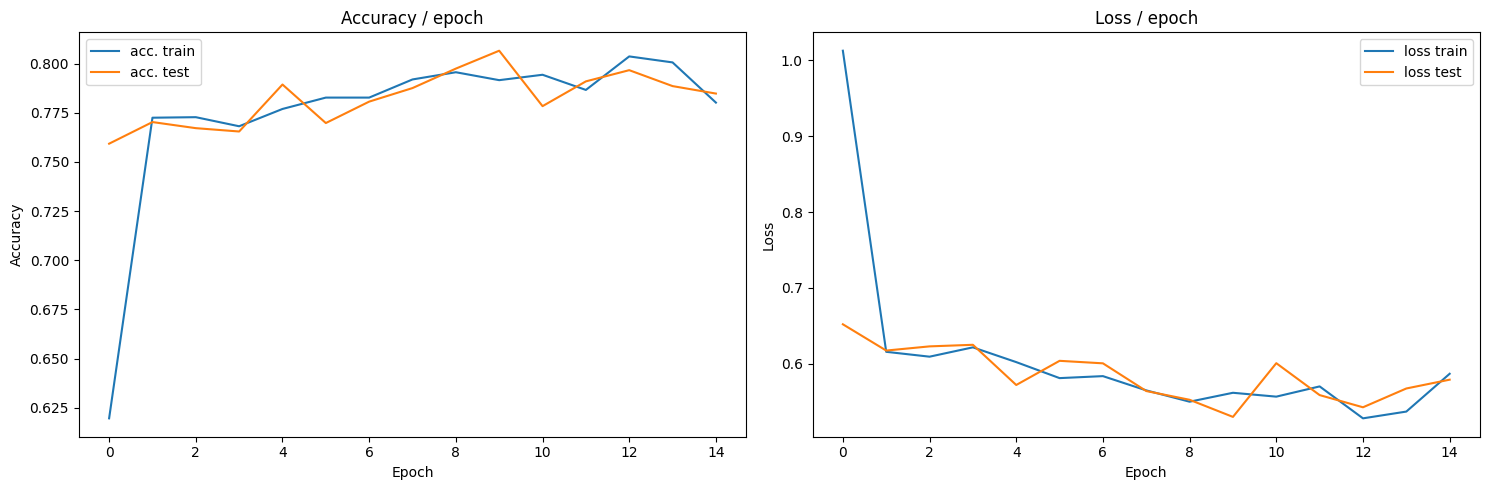

In [37]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_pretrained[0]), label="acc. train")
plt.plot(np.array(stats_pretrained[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_pretrained[2]), label="loss train")
plt.plot(np.array(stats_pretrained[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_pretrained_15.pdf", dpi=100, bbox_inches="tight")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.